# Macro-nutrient estimation for recipes
Final project for Data Science Workshop  
Daniel Anderson, ID 304866726

## 0. Introduction and motivation
Meal-logging applications have seen a great rise in popularity in the last few years, as part of the general trend of data-collecting applications for self-improvement. These applications can use meal data, alongside other lifestyle datapoints (such as weight loss/gain, tiredness, mood, physical activity etc.) to provide suggestions and recommendations regarding food habits in order to optimize one or several of the user's goals.

An important aspect of any logged meal is the meal's nutritional values, especially the calories and macro-nutrients: carbohydrates, fat, and protein. Any meal-logging application would benefit from access to the meal's macro-nutrients; however this is difficult for two reasons:
1. Users are generally not very skilled at estimating nutrients, including macro-nutrients.
2. While users voluntarily use the application, they usually wish to minimize interaction with it, making many accurate logging designs (such as a specific dish search UI component) deterring for many users.

Ideally such meal-logging applications should contain models capable of accurately estimating nutrient values given either an image of a dish or a simple textual description / name of the dish. As such data (nutrients + image / name) is rare, training such a model can be done in two phases:
1. Training a model to predict nutrients using more detailed dish information, for example a recipe book which also contains nutritional values.
2. Using the model trained in phase 1 to generate training data for the name / image -> nutrients model; for the above example, using the recipe -> nutrients model on recipe books which don't contain nutritional information to create a large dataset of names / images along with their nutrients.

This project proposes to tackle the first phase: using publicly available recipe books with nutritional information, train a model to predict a recipe's macro-nutrients based on the ingredients and preparation instructions.

### Project data
For the project I hope to use three publicly-available recipe books which contain nutritional information:
1. [MyFitnessPal's "Log It Now" recipes](https://1y2u3hx8yml32svgcf0087imj-wpengine.netdna-ssl.com/cookbook-30-recipes-under-400-calories.pdf)
2. ["Gourmet Nutrition" by Dr. John M. Berardi and Dr. John K. Williams](https://iron-body.com/wp-content/uploads/2012/08/gourmet_nutrition.pdf)
3. ["Everyday Healthy Meals" by Champions for Change](https://www.sccoe.org/depts/Human-Resources/Health-Wellness/Documents/Everyday-Healthy-Meals-Cookbook.pdf)

These are intended to provide the core data for the project; additional data might be necessary / useful along the way.

### Approach and project outline
1. Write scripts to extract recipe data from the books. For each recipe we would like to have its name (string), description (string), macro-nutrient values (numeric; values for calories, carbs, fat, and protein [the last three in grams]), ingredients (list of strings), and preparation instructions (string).
2. Preliminary analysis to assess the importance of the next steps and possibly adjust the outline.
3. Perform pre-processing, using NLP and unsupervised learning methods, to extract unique ingredients and measurements for ingredient text, and be able to parse each ingredient string to 3-tuple of amount, measurement, ingredient. For example "2 tablespoons finely chopped red onion" would be mapped to (2, "tablespoon", "red onion").
Theoretically if we had a lot of data we could just "throw" all the ingredient text at a NN, but since we expect to have relatively little data there's reason to hope preprocessing will improve the model's performance.
4. Train regression model (either simple or NN-based) to predict macro-nutrients based on ingredients and preparation instructions (perhaps also using recipes' name and description).

## 1. Extracting the data
### 1a. "Log It Now" cookbook

In [5]:
# Hand-picking recipe pages
recipe_pages = sorted(list(set(range(10, 44)) - {15, 21, 27, 33}))

In [6]:
from PyPDF2 import PdfFileReader, PdfFileWriter
from os import system
from time import sleep
import re
from itertools import takewhile
import string

with open('cookbook-30-recipes-under-400-calories.pdf', 'rb') as log_it_now_book:
    log_it_now_reader = PdfFileReader(log_it_now_book)

    def parse_log_it_now_recipe(page_no): # Parse only one page at a time (easier for the pdf2text utility)
        writer = PdfFileWriter()
        writer.addPage(log_it_now_reader.getPage(page_no - 1))
        with open('temp.pdf', 'wb') as f:
            writer.write(f)
        system('pdf2txt.py temp.pdf > temp.txt') # PDFMiner library converts pdf to text better
        with open('temp.txt', 'r') as f:
            recipe_txt = f.read()
            
        system('rm temp.pdf temp.txt')
        
        flat_recipe_txt = re.sub(r'\s+', ' ', recipe_txt)
        flat_recipe_txt = fix_dozen(flat_recipe_txt)
        
        servings, serving_start_index = get_recipe_servings(flat_recipe_txt)
        name = get_recipe_name(flat_recipe_txt)
        description = flat_recipe_txt[:serving_start_index].replace(name, '').strip()
        
        return {
            'name': name,
            'description': description,
            # Nutrients are per serving (and ingredient amounts are for several servings)
            'macros': {k: v * servings for k, v in get_recipe_macros(flat_recipe_txt).items()},
            'ingredients': get_recipe_ingredients(flat_recipe_txt),
            'instructions': get_recipe_instructions(flat_recipe_txt)
        }
    
    def fix_dozen(flat_recipe_txt):
        m = re.search(r'(\d+) DOZEN', flat_recipe_txt)
        if not m:
            return flat_recipe_txt
        
        n = int(m.groups()[0]) * 12
        return re.sub(r'\d+ DOZEN', '%d SERVINGS' % n, flat_recipe_txt)
    
    def get_recipe_name(flat_recipe_txt):
        return ' '.join(takewhile(lambda x: x.isupper() or x in string.punctuation, flat_recipe_txt.split()))
    
    def get_recipe_servings(recipe_txt):
        match = re.search(r'(\d+) SERVINGS', recipe_txt)
        return int(match.groups()[0]), match.span()[0]
    
    def get_recipe_ingredients(flat_recipe_txt):
        bullet = '•'
        return [x.strip() for x in
                flat_recipe_txt[flat_recipe_txt.index('INGREDIENTS') + len('INGREDIENTS'):
                                min(flat_recipe_txt.index('INSTRUCTIONS'), 
                                    flat_recipe_txt.index('CLICK TO LOG'))].split(bullet) if x.strip()]
    
    def get_recipe_instructions(flat_recipe_txt):
        instructions_index = flat_recipe_txt.index('INSTRUCTIONS')
        click_to_log_index = flat_recipe_txt.index('CLICK TO LOG')
        myfitnesspal_index = flat_recipe_txt.index('myfitnesspal')
        return flat_recipe_txt[instructions_index + len('INSTRUCTIONS'):
                               min(click_to_log_index if click_to_log_index > instructions_index else myfitnesspal_index,
                                   flat_recipe_txt.index('CALORIES'))]. \
                                    replace('myfitnesspal', '').strip()
    
    def get_recipe_macros(flat_recipe_txt):
        m = re.search(r'CALORIES(?:\s+[a-zA-Z]+)+\s(\d+)(?:\s\d+)?((?:\s\d+g)+)', flat_recipe_txt)
        cals = int(m.groups()[0])
        other_nutrients = list(map(int, re.findall(r'(\d+)g', m.groups()[1])))
        fat_index = 0
        protein_index = 4
        carbs_index = 5
        return {'calories': cals, 
                'carbs': other_nutrients[carbs_index],
                'protein': other_nutrients[protein_index],
                'fat': other_nutrients[fat_index]}

    recipes = [parse_log_it_now_recipe(page) for page in recipe_pages]

In [7]:
# Hand-fix problematic ingredients
recipes[26]['ingredients']

['Cooking spray',
 '4 bone-in chicken thighs, skinned 1/3 cup chopped fresh cilantro, divided 1 cup frozen corn kernels, thawed 1/3 cup (3 ounces) 1/3-less-fat cream cheese, softened 1/2 teaspoon ground red pepper 1/2 teaspoon ground cumin 1/4 teaspoon kosher salt 1/4 teaspoon black pepper 2 cups chopped onion, divided 6 garlic cloves, minced and divided 1 cup fat-free, lower-sodium chicken broth 2/3 cup salsa verde 1/4 cup water 2 tablespoons chopped pickled jalapeño pepper 9 (6-inch) corn tortillas 1/4 cup (1 ounce) shredded sharp cheddar cheese']

In [8]:
recipes[26]['ingredients'] = ['Cooking spray',
                              '4 bone-in chicken thighs, skinned',
                              '1/3 cup chopped fresh cilantro, divided',
                              '1 cup frozen corn kernels, thawed',
                              '1/3 cup (3 ounces) 1/3-less-fat cream cheese, softened',
                              '1/2 teaspoon ground red pepper',
                              '1/2 teaspoon ground cumin',
                              '1/4 teaspoon kosher salt',
                              '1/4 teaspoon black pepper',
                              '2 cups chopped onion, divided',
                              '6 garlic cloves, minced and divided',
                              '1 cup fat-free, lower-sodium chicken broth',
                              '2/3 cup salsa verde',
                              '1/4 cup water',
                              '2 tablespoons chopped pickled jalapeño pepper',
                              '9 (6-inch) corn tortillas',
                              '1/4 cup (1 ounce) shredded sharp cheddar cheese']

In [9]:
import pandas as pd
log_it_now_recipe_df = pd.DataFrame(recipes)
log_it_now_recipe_df = pd.concat([log_it_now_recipe_df.drop(['macros'], axis=1),
                                  log_it_now_recipe_df['macros'].apply(pd.Series)], axis=1)
log_it_now_recipe_df.head()

description  \
0  These pumpkin seeds make a delicious snack del...   
1  Serve this quick after-school snack to your ki...   
2  Craving a crunchy munchy but tired of salted p...   
3  The rich and creamy combination of bacon, crea...   
4  go-to appetizer for parties, this spinach and ...   

                                         ingredients  \
0  [1 cup unsalted pumpkin seed kernels, 1 tables...   
1  [1/3 cup panko (Japanese breadcrumbs), 3 (1-ou...   
2  [2 (15 1/2-ounce) cans organic chickpeas (garb...   
3  [2 center-cut bacon slices, 4 ounces cream che...   
4  [1/2 cup fat-free sour cream, 1/4 teaspoon fre...   

                                        instructions  \
0  1. Place 1 cup pumpkin seeds in a large skille...   
1  1. Preheat oven to 425°F. 2. Heat a medium ski...   
2  1. Preheat oven to 300°F. 2. Wrap chickpeas in...   
3  1. Preheat grill to medium-high heat. 2. Cook ...   
4  1. Preheat oven to 350°F. 2. Combine first 7 i...   

                          name  calories  carbs  protein  fat  
0  SWEET & SPICY PUMPKIN SEEDS      1320     24       72  104  
1       BAKED MOZZARELLA BITES       392     28       28   20  
2            CRUNCHY CHICKPEAS       960    144       40   40  
3    GRILLED STUFFED JALEPEÑOS       798     28       42   56  
4      SPINACH ARTICHOKE DIP A      1650     88      132   88

In [10]:
log_it_now_recipe_df.to_csv('data/log_it_now.csv', index=False)

### 1b. "Gourmet Nutrition"
pdf2txt doesn't work very well on this book. Fortunately, recipe pages are structured in a fixed way, so we can crop the relevant part for each recipe and use OCR to extract the data, using the pdf2image and tesseract libraries.

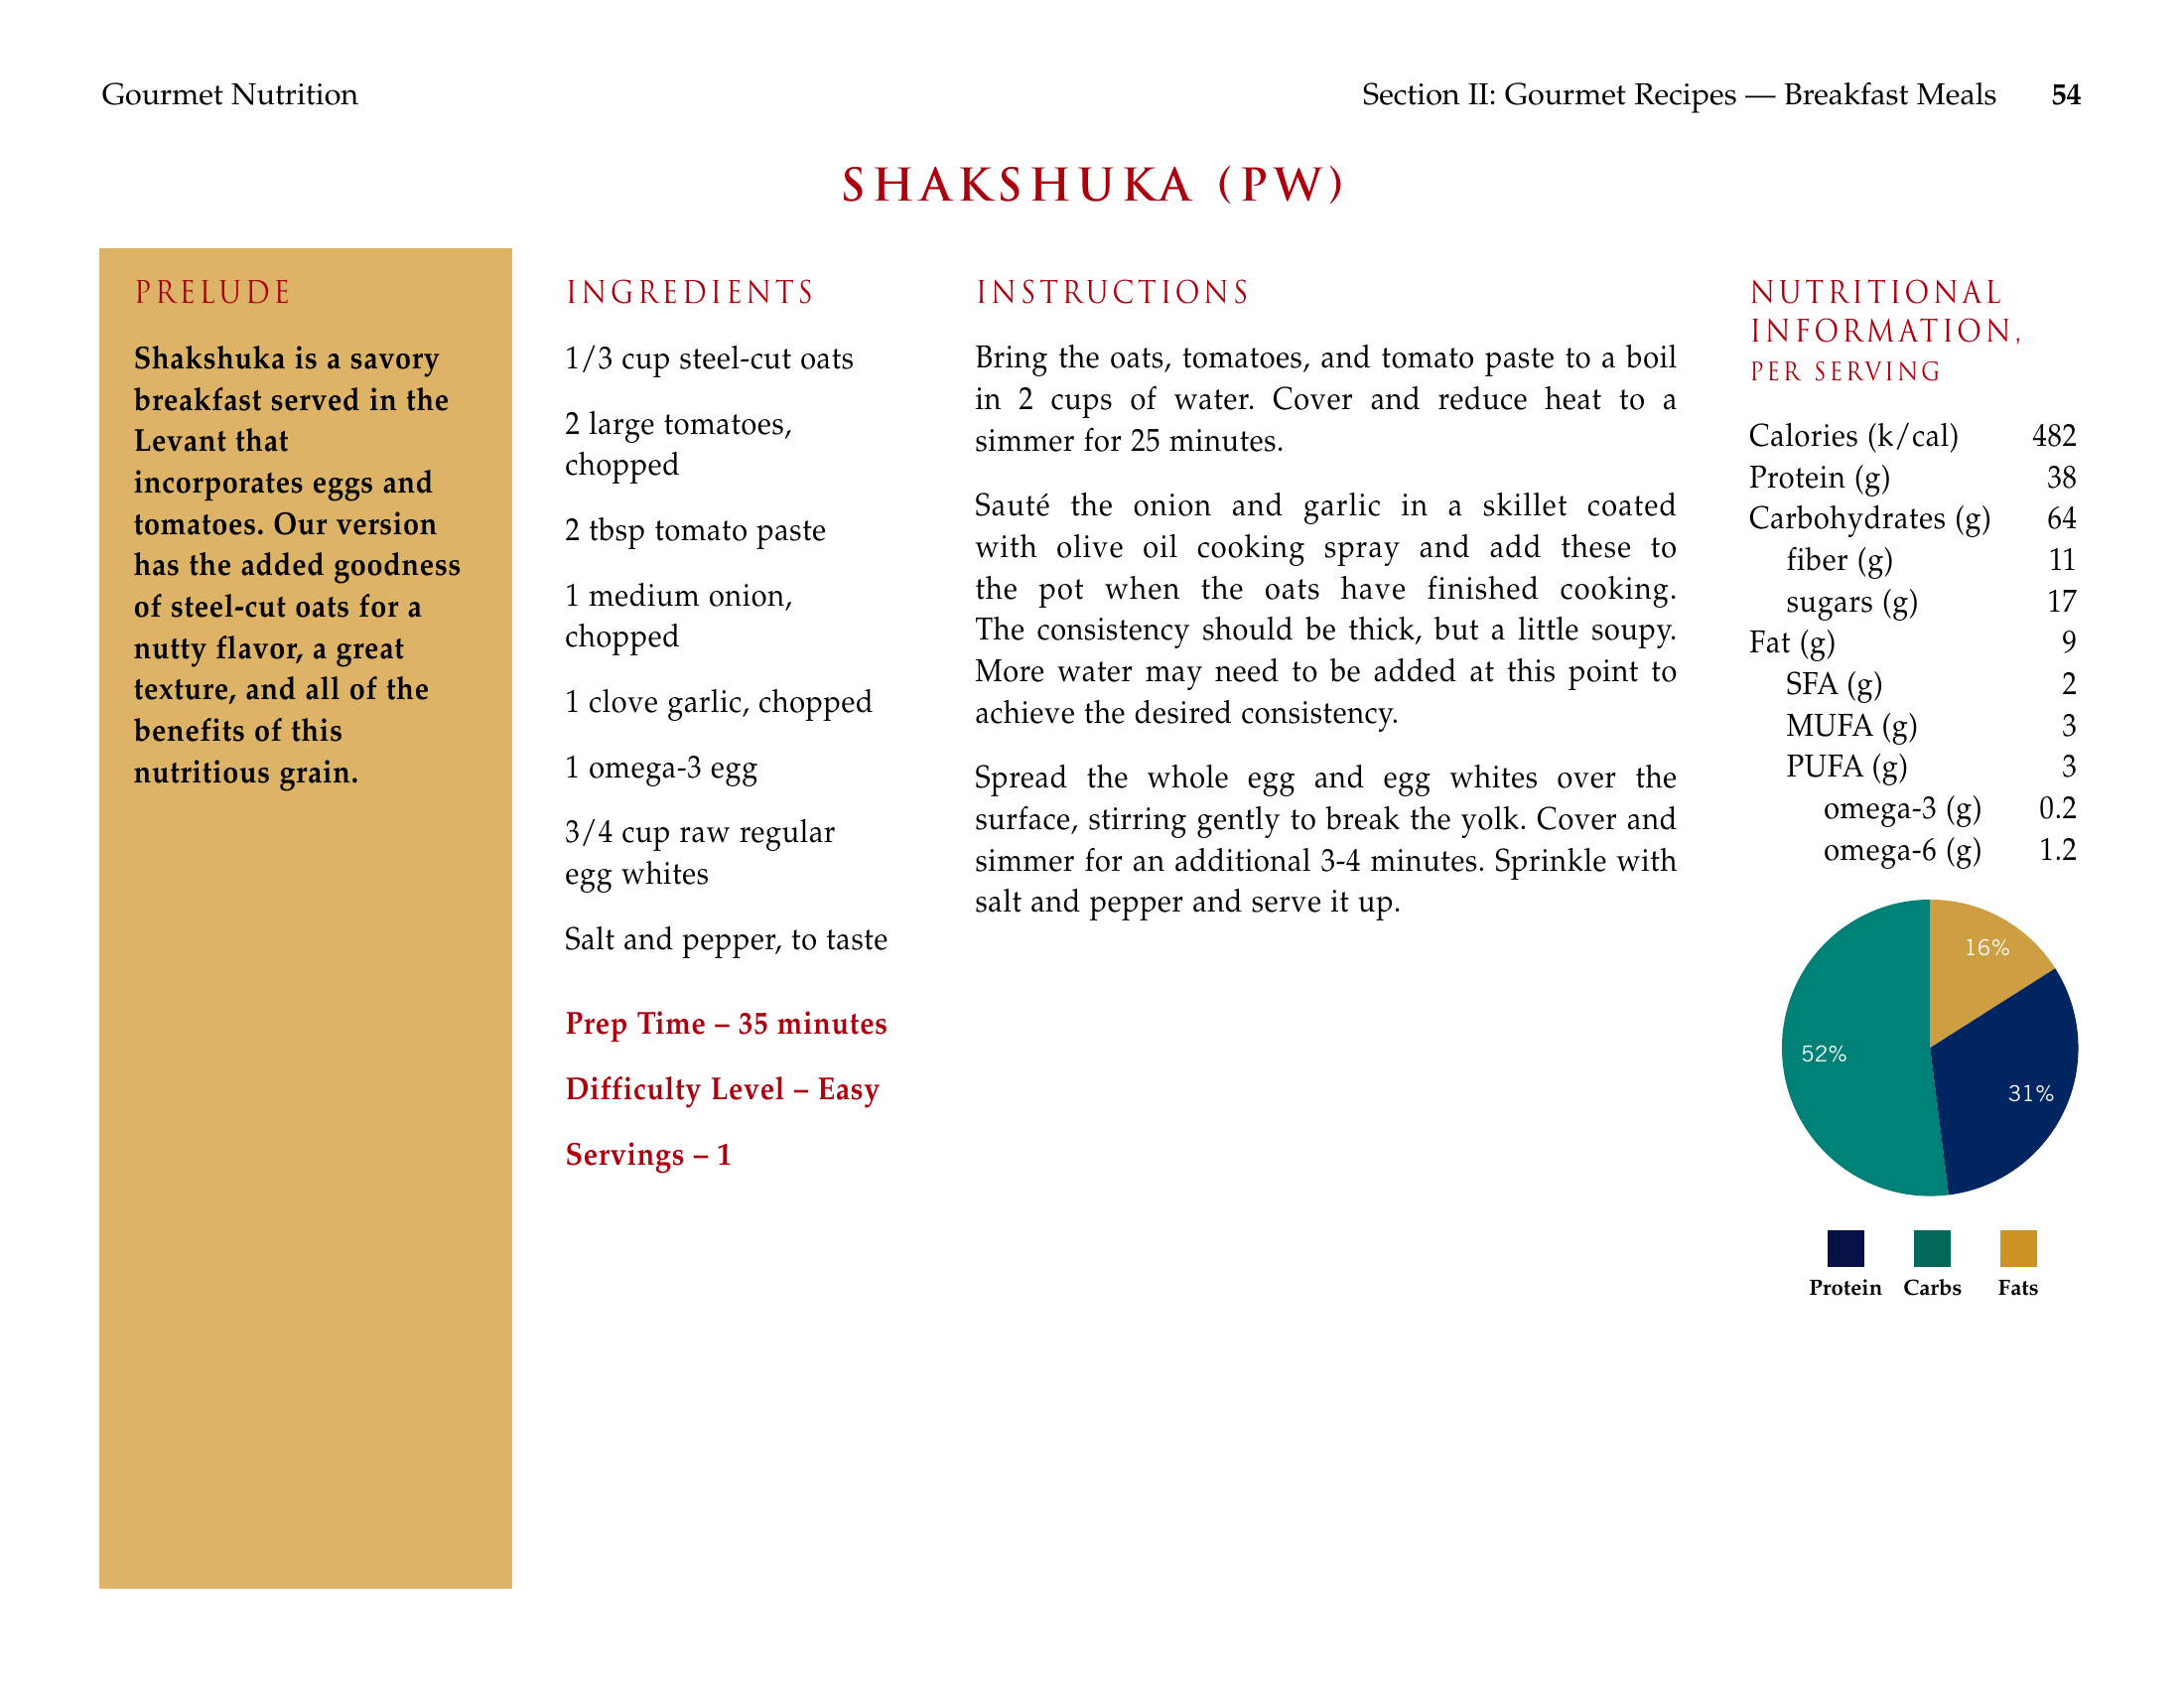

In [7]:
from pdf2image import convert_from_path

pages = convert_from_path('gourmet_nutrition.pdf')
pages[53]

Next let's find the bounding boxes for each section:

In [7]:
from PIL import ImageDraw

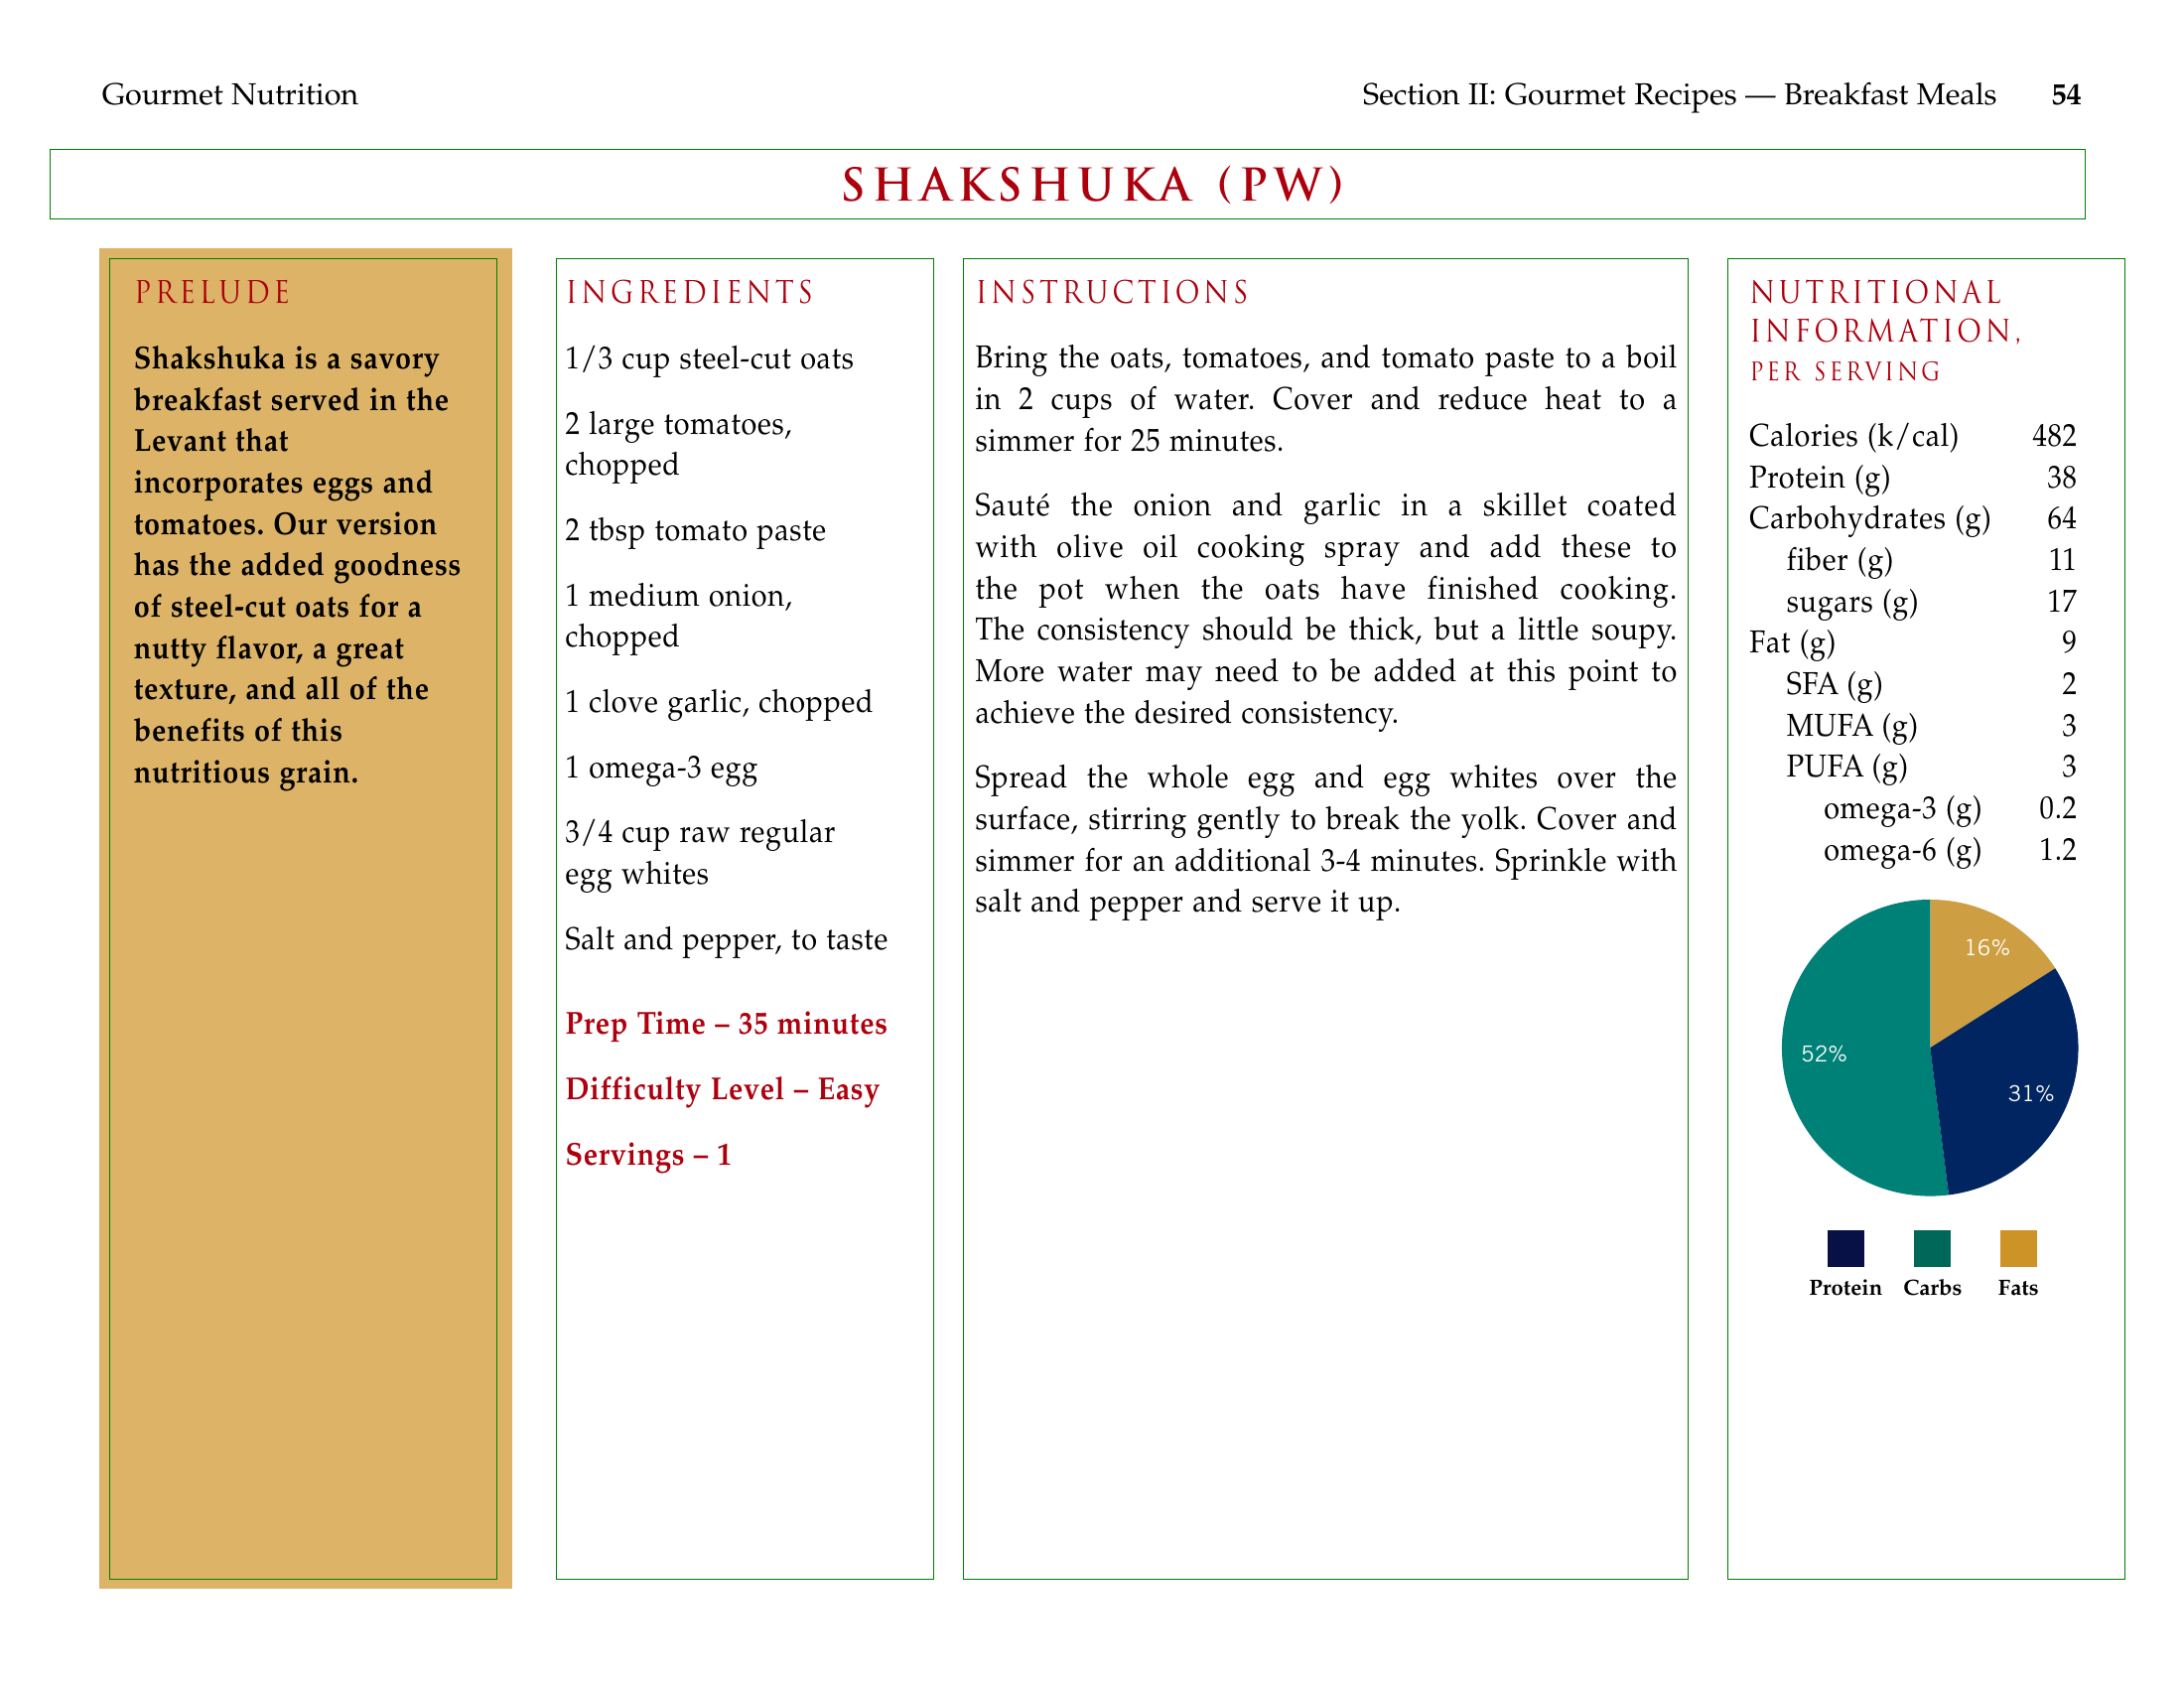

In [77]:
bb = {
    'title': [50, 150, 2100, 220],
    'description': [110, 260, 500, 1590],
    'ingredients': [560, 260, 940, 1590],
    'instructions': [970, 260, 1700, 1590],
    'nutrition': [1740, 260, 2140, 1590]
}

test_img = pages[53].copy()
draw = ImageDraw.Draw(test_img)
for k, rect in bb.items():
    draw.rectangle(rect, outline='green')
test_img

Let's try the OCR now:

In [5]:
import locale
locale.setlocale(locale.LC_ALL, 'C')
from tesserocr import PyTessBaseAPI, iterate_level, RIL

In [78]:
test_img = pages[53].copy()
test_img_ingredients = test_img.crop(bb['ingredients'])
test_img_ingredients

api = PyTessBaseAPI()
api.SetImage(test_img_ingredients)

print(api.GetUTF8Text())

INGREDIENTS
1/3 cup steel-cut oats

2 large tomatoes,
chopped

2 tbsp tomato paste

1 medium onion,
chopped

1 clove garlic, chopped
1 omega-3 egg

3/4 cup raw regular
egg whites

Salt and pepper, to taste

Prep Time - 35 minutes
Difficulty Level - Easy

Servings - 1



Looks good - let's parse all the recipes:

In [79]:
recipe_pages = [46, 49, *range(51, 55),
               56, 58, 59, 61, 63, 64, 65,
               69, 71, 72, 74, 75, 77, 78, 80, 82, 83, *range(87, 99),
               101, 102, 104, 106, 107, 109, 111, 112, 115,
               *range(118, 126), 128, *range(129, 134), 
               135, 137, 138, 139, 141, 142,
               146, 148, *range(150, 160),
               *range(162, 178),
               179, *range(181, 186), 187, 188, 189]

In [80]:
def extract_section_text(img, bounding_box):
    api.SetImage(img.crop(bounding_box))
    return api.GetUTF8Text().strip('\n')

In [131]:
import re

def parse_gourmet_nutrition_recipe(page_no):
    page = pages[page_no - 1]
    
    raw_text = {k: extract_section_text(page, rect) for k, rect in bb.items()}
    
    def get_name(title):
        return title.replace('(PW)', '').replace('(ANYTIME)', '').strip()
    
    def get_description(description):
        return ' '.join(description.split('\n')[1:]).strip()
    
    def get_instructions(instructions):
        return ' '.join(instructions.split('\n')[1:]).strip()
    
    def get_macros(nutrition, servings):
        nutrition = nutrition.split('\n')
        calories = carbs = protein = fat = 0
        for nut in nutrition:
            m = re.search(r'calories[^\d]*(\d+)', nut.lower())
            if m:
                calories = int(m.groups()[0])
                
            m = re.search(r'carbohydrate[^\d]*(\d+)', nut.lower())
            if m:
                carbs = int(m.groups()[0])
                
            m = re.search(r'protein[^\d]*(\d+)', nut.lower())
            if m:
                protein = int(m.groups()[0])
                
            m = re.search(r'fat\s\(g\)[^\d]*(\d+)', nut.lower())
            if m:
                fat = int(m.groups()[0])

        return {'calories': calories * servings, 
                'carbs': carbs * servings,
                'protein': protein * servings,
                'fat': fat * servings}
    
    def get_servings(text):
        m = re.search(r'servings\s?[-—]\s?(\d+)', text.lower())
        if not m:
            return 1
        
        return int(m.groups()[0])
    
    def get_ingredients(ingredients):
        ingredients = ingredients[ingredients.index('\n'):].strip('\n')
        ingredient_list = []
        curr_ingredient = ''
        while '\n' in ingredients:
            i = ingredients.index('\n')
            curr_ingredient += ' ' + ingredients[:i]
            ingredients = ingredients[i + 1:]
            if ingredients[0] == '\n' or ingredients[0].isdigit():
                ingredient_list.append(curr_ingredient.strip())
                curr_ingredient = ''
                
                if ingredients[0] == '\n':
                    ingredients = ingredients[1:]
                
        curr_ingredient += ' ' + ingredients
        ingredient_list.append(curr_ingredient.strip())
                
        
        return ingredient_list
    
    def remove_noise(text):
        if 'prep time' in text.lower():
            return text[:text.lower().index('prep time')].strip()
        
        return text
    
    servings = get_servings(' '.join([raw_text['ingredients'], raw_text['instructions']]))
    
    raw_text['ingredients'] = remove_noise(raw_text['ingredients'])
    raw_text['instructions'] = remove_noise(raw_text['instructions'])
    
    return {
        'name': get_name(raw_text['title']),
        'description': get_description(raw_text['description']),
        # Nutrients are per serving (and ingredient amounts are for several servings)
        'macros': get_macros(raw_text['nutrition'], servings),
        'ingredients': get_ingredients(raw_text['ingredients']),
        'instructions': get_instructions(raw_text['instructions'])
    }

In [135]:
gourmet_nutrition_recipes = [parse_gourmet_nutrition_recipe(page) for page in recipe_pages]

In [136]:
import pandas as pd
gourmet_nutrition_recipe_df = pd.DataFrame(gourmet_nutrition_recipes)
gourmet_nutrition_recipe_df = pd.concat([gourmet_nutrition_recipe_df.drop(['macros'], axis=1),
                                         gourmet_nutrition_recipe_df['macros'].apply(pd.Series)], axis=1)
gourmet_nutrition_recipe_df.head()

description  \
0  This is a staple meal that is consistently fou...   
1  Here is a guilt-free version of a traditional ...   
2  Does a 500 calorie egg white omelet with fat f...   
3  This is a quick and easy recipe that provides ...   
4  Head south of the border with this revved-up v...   

                                         ingredients  \
0  [6 large egg whites (1 cup) plus one whole ome...   
1  [6 large egg whites (1 cup) plus one whole ome...   
2  [6 egg whites (1 cup), plus 3 whole omega-3 eg...   
3  [6 egg whites, plus, 2 whole omega-3 eggs, bea...   
4  [6 egg whites (1 cup), plus 1 whole omega-3 eg...   

                                        instructions  \
0  Stir-fry the chopped turkey, onions, and mushr...   
1  In a large skillet, brown the onions and turke...   
2  In a large skillet, sauté turkey sausage and o...   
3  In a skillet or wok on medium-high heat, brown...   
4  Combine the eggs and paprika in a bowl and bea...   

                        name  calories  carbs  protein  fat  
0  SPINACH AND CHEESE OMELET       408     14       58   12  
1              DENVER OMELET       477     11       71   14  
2            BULKER’S OMELET       953     13      107   50  
3       ASIAN SCRAMBLED EGGS       433     27       40   19  
4           MEXICAN FRITTATA       689     22       76   32

In [137]:
gourmet_nutrition_recipe_df.to_csv('data/gourmet_nutrition.csv', index=False)

### 1c. "Everyday Healthy Meals"

This book is the trickiest: pdf2txt doesn't work well on it, recipe pages are unstructured, and some pages contain two recipes. Hopefully we'll be able to work around those challenges.

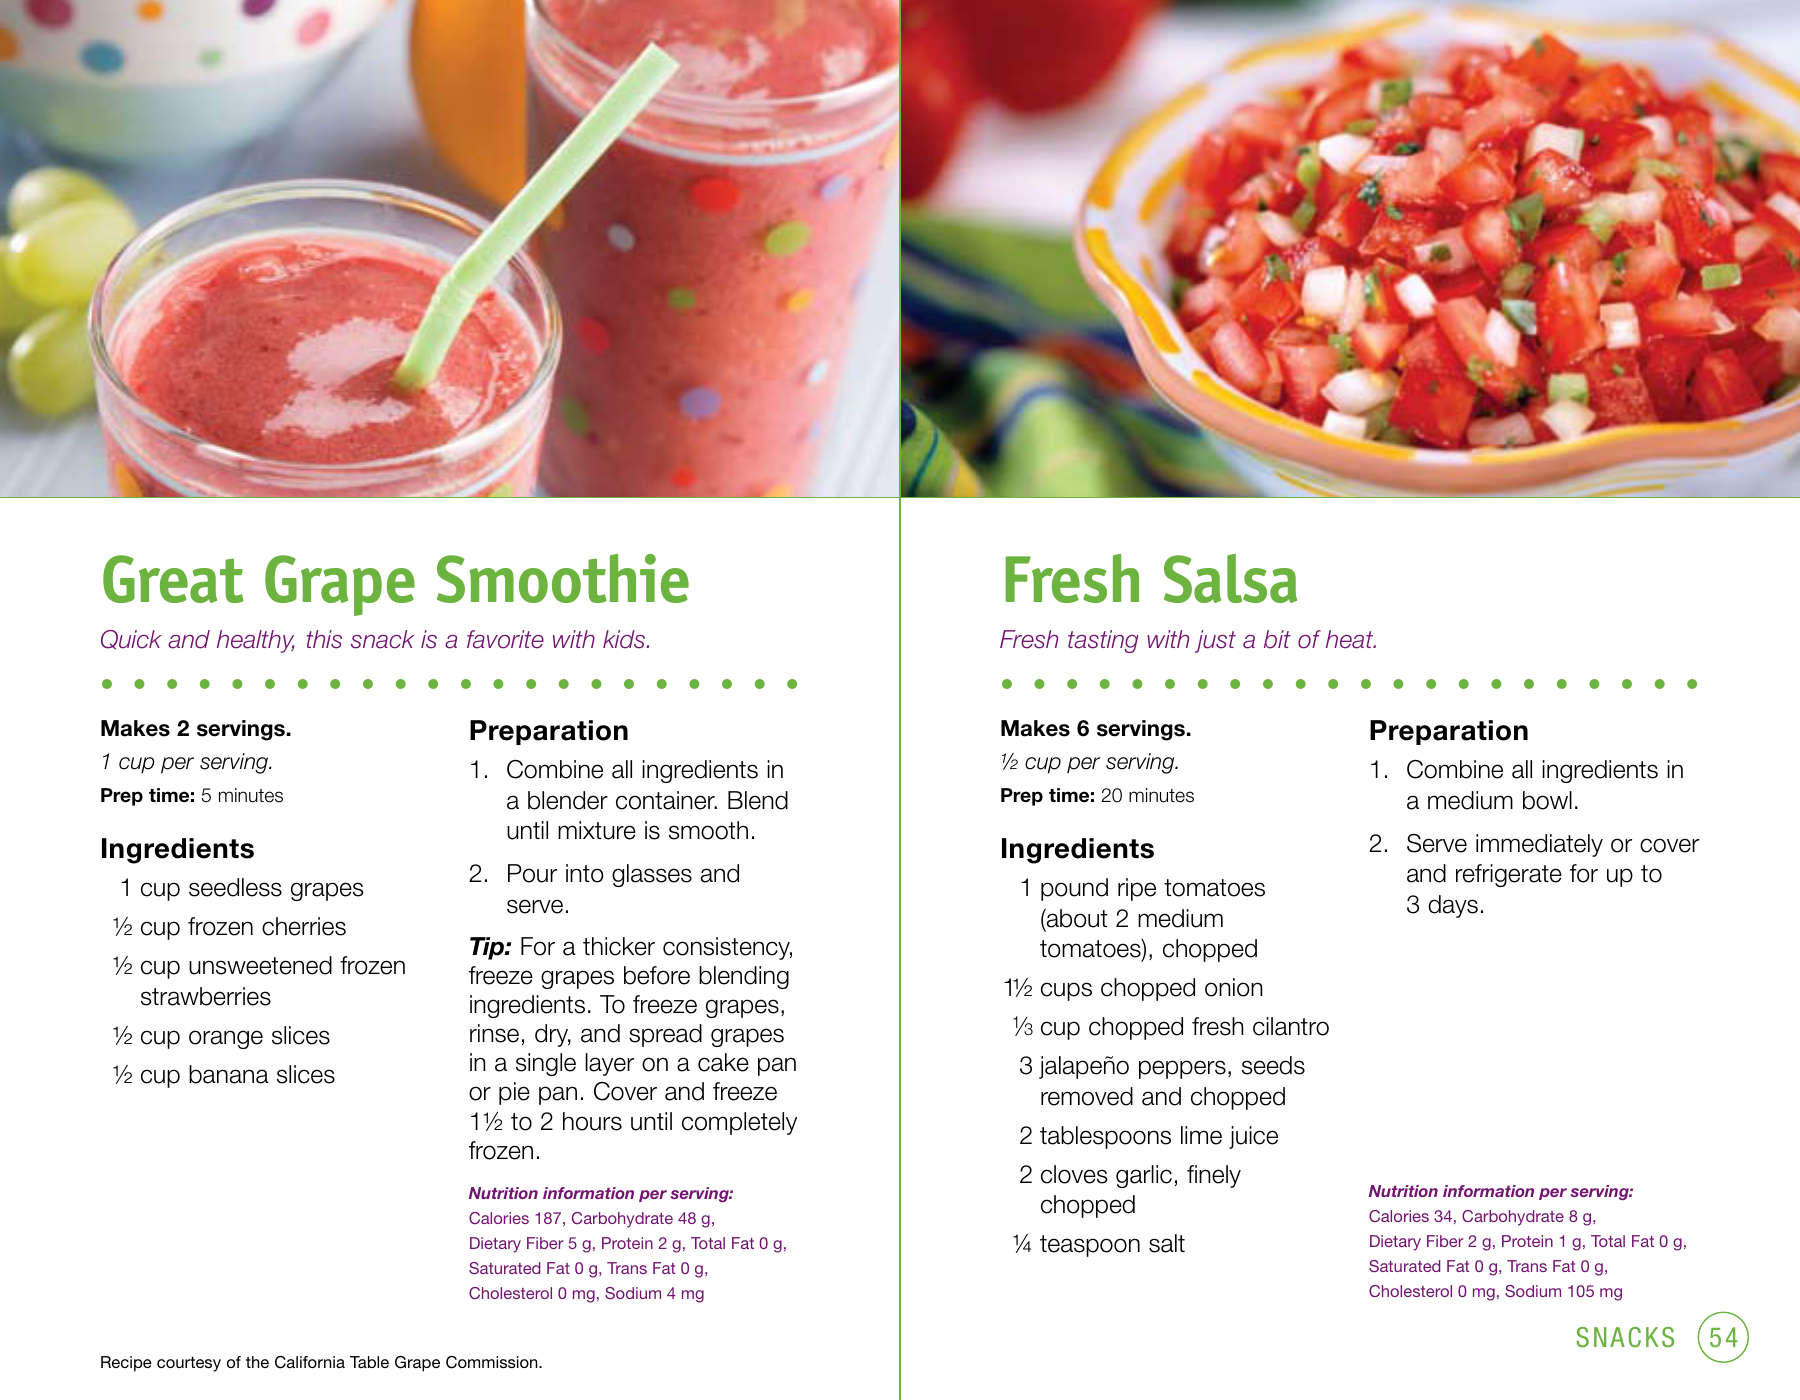

In [1]:
from pdf2image import convert_from_path

pages = convert_from_path('Everyday-Healthy-Meals-Cookbook.pdf')
pages[55]

All pages the contain two recipes are luckily divided vertically in the center, so we could manually specify those pages and automatically split them:

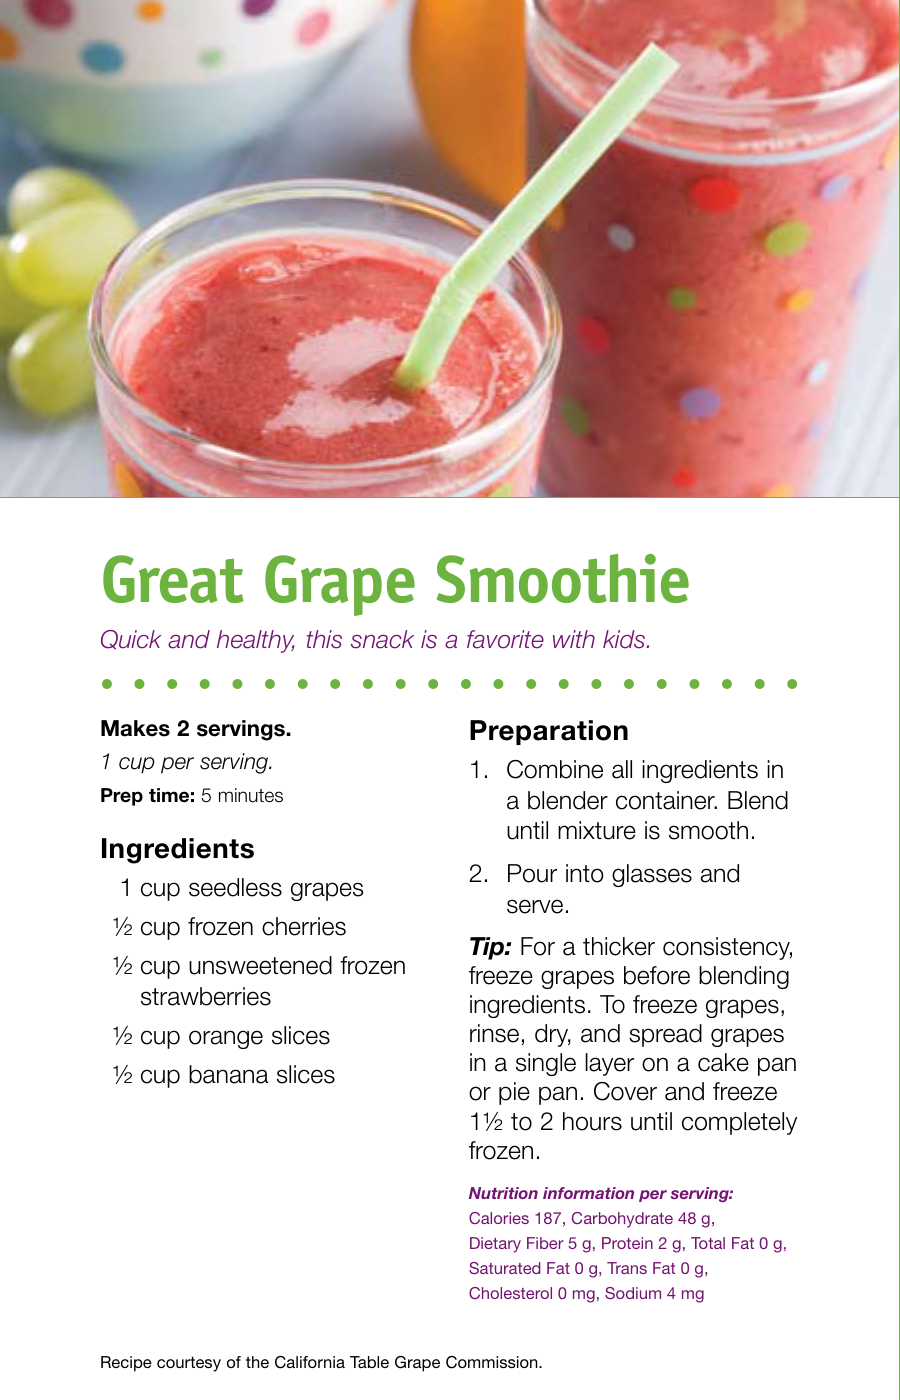

In [2]:
split_test_page = pages[55]
split_test_first_half = pages[55].crop((0, 0, split_test_page.size[0] / 2, split_test_page.size[1]))
split_test_first_half

Now we just need a way to properly parse an image containing a recipe. Since we're also planning to use Tesseract and the fonts in this book are more colorful, we'll convert images to grayscale before scanning for text.

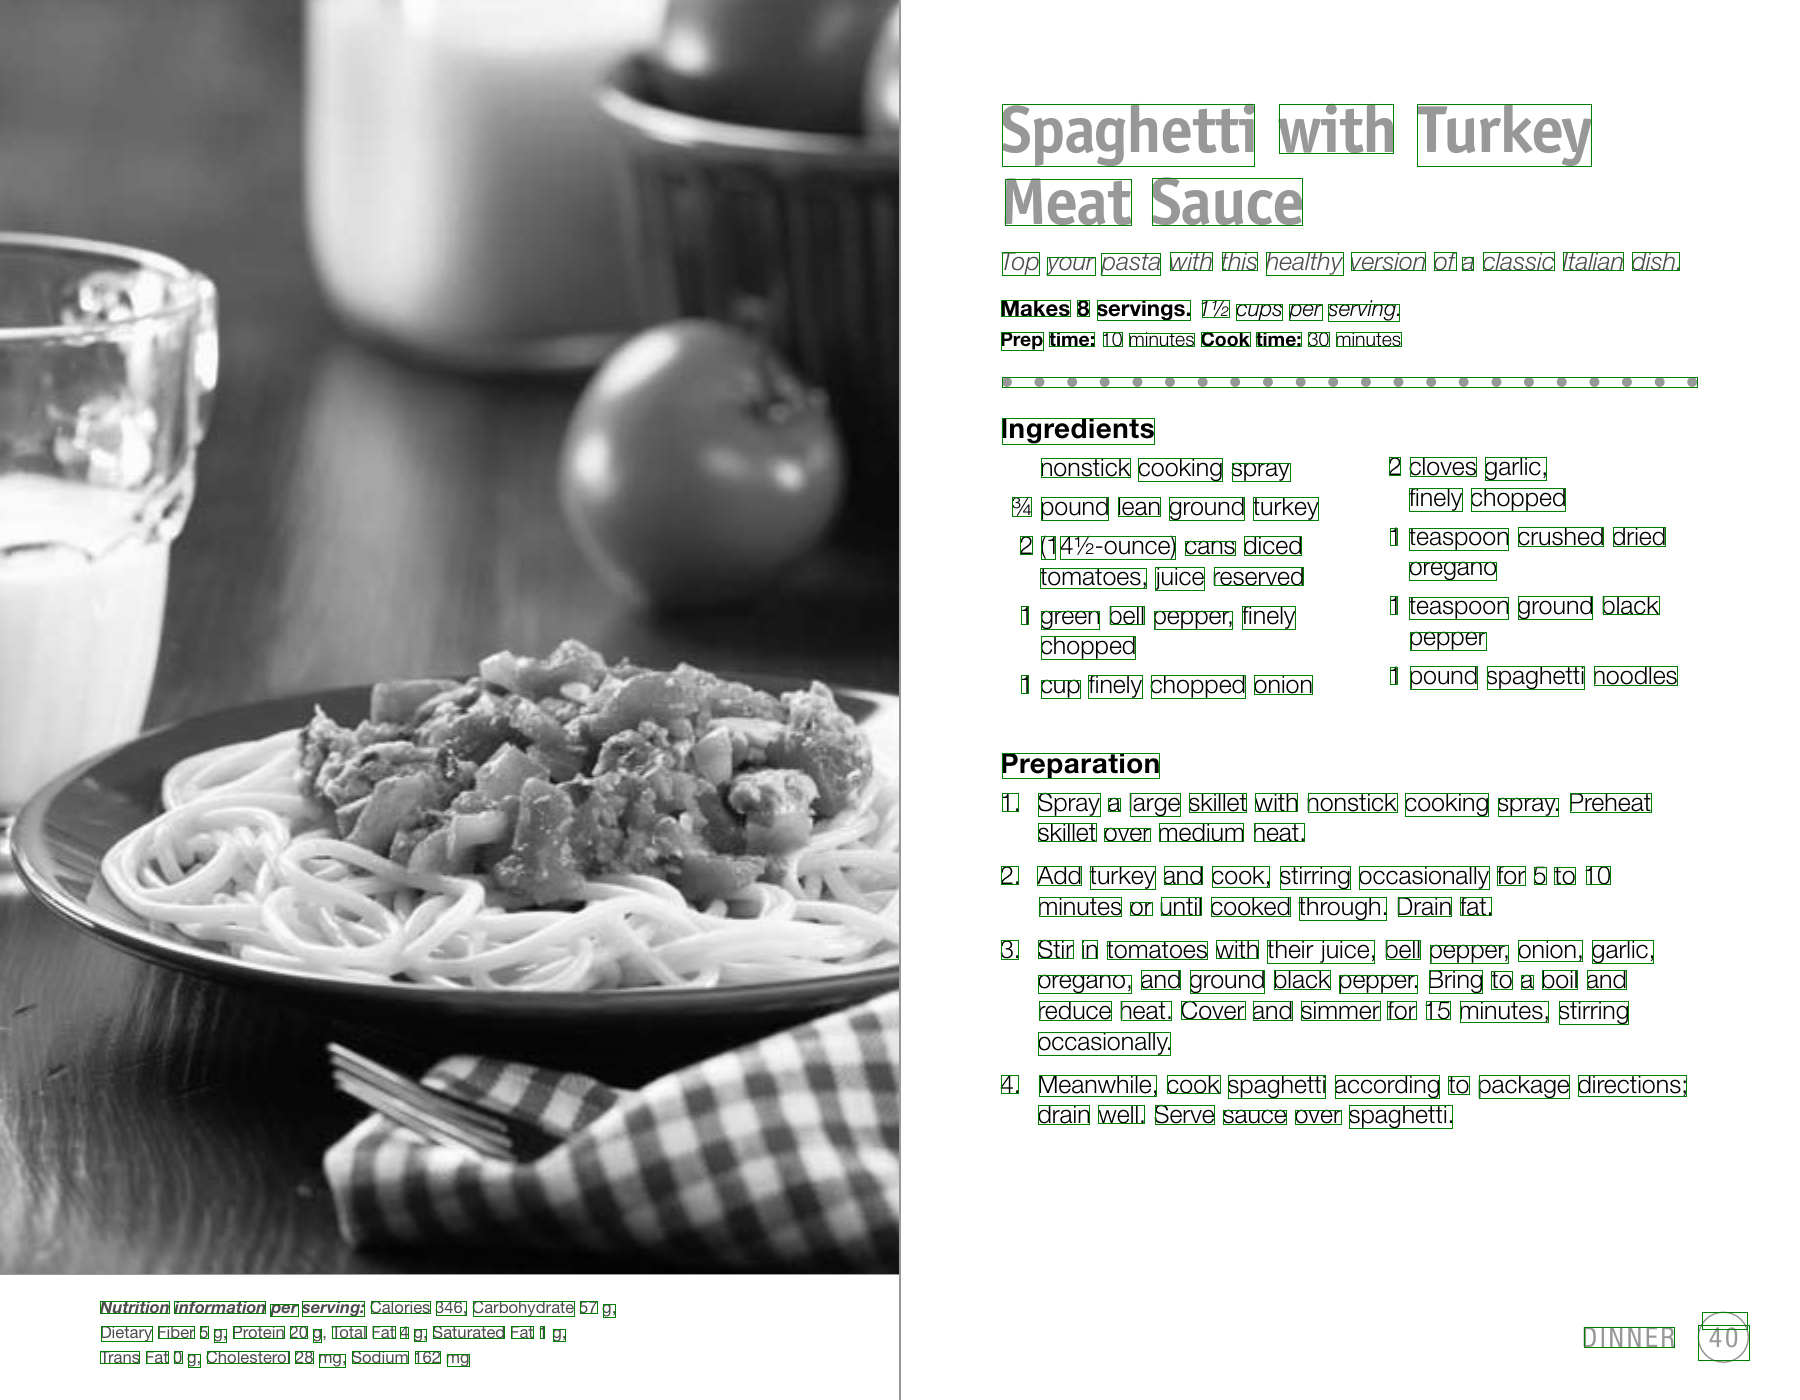

In [17]:
test_image = pages[41].copy().convert('LA').convert('RGB')
api = PyTessBaseAPI()
draw = ImageDraw.Draw(test_image)
api.SetImage(test_image)
boxes = api.GetComponentImages(RIL.WORD, True)
for i, (im, box, _, _) in enumerate(boxes):
    draw.rectangle([box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']], outline='green')
    
test_image

The parsing turned out to be quite long and complicated, so it was run separately from the notebook. The general process involved using Tesseract to recognize word positions on the page (as in the cell above), using a simplified version of clustering to group words to blocks, and extracting the relevant fields from those blocks, using also corrections from `pdf2txt` where OCR text was not very good. The code for this process can be found in the same [github repo](https://github.com/AndersonDaniel/macro-nutrient-estimation) as this notebook. The data has beed saved to `data/everyday_healthy_meals.csv`.

## 2. Preliminary analysis

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

In [2]:
recipes_df = pd.concat([
    pd.read_csv('data/everyday_healthy_meals.csv'),
    pd.read_csv('data/gourmet_nutrition.csv'),
    pd.read_csv('data/log_it_now.csv')
]).reset_index(drop=True).sample(frac=1.).reset_index(drop=True)

In [3]:
recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval).apply(lambda x: list(map(lambda y: y.replace('⁄', '/'), x)))

In [4]:
recipes_df.head()

description  \
0  The Indians have mastered the art of combining...   
1  This foolproof recipe combines the harmony of ...   
2  These quesadillas make a great meatless meal f...   
3  This zesty mustard sauce dresses chicken breas...   
4  Sea scallops provide a large dose of protein w...   

                                         ingredients  \
0  [1 Ib sirloin, cut into, 1-inch cubes, 10 oz s...   
1  [1.5 lbs beef round, trimmed to 1/4 inch fat, ...   
2  [nonstick cooking spray, 1/2 cup chopped green...   
3  [2 tablespoons olive oil, divided, 4 (6-ounce)...   
4  [Almond-Crusted Sea Scallops Ingredients:, 1.5...   

                                        instructions  \
0  Put the onion, ginger, and garlic in a food pr...   
1  Heat a large nonstick pot on medium heat, coat...   
2  1. Spray a medium skillet with nonstick cookin...   
3  1. Preheat oven to 450°F. 2. Heat a large oven...   
4  In a large bowl, toss the onions, tomatoes, ol...   

                                                name  calories  carbs  \
0            SAUTEED BEEF IN AN INDIAN SPINACH SAUCE      1400     60   
1                   BRAISED BEEF WITH WINE AND HERBS      2076     60   
2                              VEGETABLE QUESADILLAS       536     80   
3      CHICKEN WITH BRUSSELS SPROUTS & MUSTARD SAUCE      1420     36   
4  ALMOND-CRUSTED SEA SCALLOPS WITH TOMATO-ONION ...      1434     46   

   protein  fat  
0      144   64  
1      261   72  
2       28   12  
3      168   68  
4      146   74

### General macro-nutrient distribution
First let's examine the general macro-nutrient distribution:

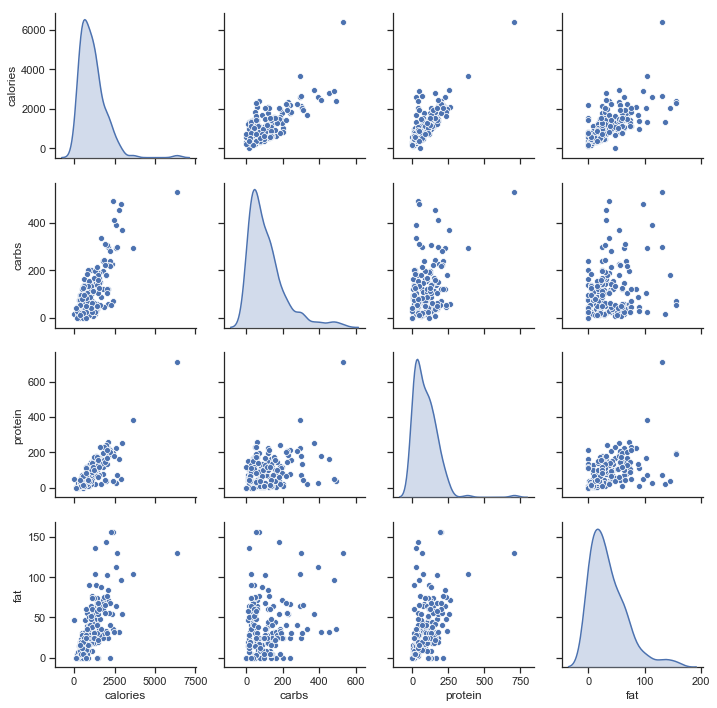

In [5]:
sns.set(style='ticks')
sns.pairplot(recipes_df, vars=['calories', 'carbs', 'protein', 'fat'], diag_kind='kde')
plt.show()

Seems reasonable: generally larger meals contain more of all nutrients, but there isn't a really strong correlation. Except of course the calories variable, which is increased by any increase in the other macro-nutrients.

Theoretically the calories could be estimated using the famous "4-4-9" rule (each gram of protein or carbs contains 4 calories; each gram of fat contains 9 calories) - let's test it:

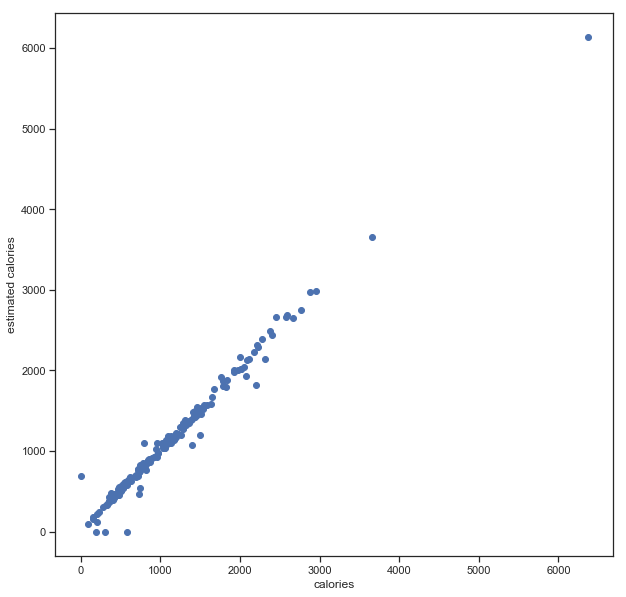

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(recipes_df['calories'], np.dot(recipes_df[['carbs', 'protein', 'fat']].values, np.array([4, 4, 9])))
plt.xlabel('calories')
plt.ylabel('estimated calories')
plt.show()

As expected the data follows almost exactly an identity relation; deviations are probably due to rounding errors and nutrient data presented as integers. Therefore we can safely drop the calories from the predictions and focus on macro-nutrients. There are some outliers, but as they are not significant we'll ignore them for the moment.

### Ingredient effect on macro-nutrients
Let's try to examine the effect of several ingredients on the macro-nutrients

In [7]:
def examine_ingredient(ingredient):
    recipe_w_ingredient_df = recipes_df.copy()
    recipe_w_ingredient_df[ingredient] = np.array([any([ingredient in x.lower()
                                                           for x in row['ingredients']])
                                                      for _, row in recipes_df.iterrows()])
    plt.figure(figsize=(10, 5))
    sns.swarmplot(x='macro-nutrient', y='amount', hue=ingredient,
                  data=pd.melt(recipe_w_ingredient_df[[ingredient, 'carbs', 'protein', 'fat']], 
                               id_vars=[ingredient], 
                               var_name='macro-nutrient', 
                               value_name='amount'))
    plt.show()

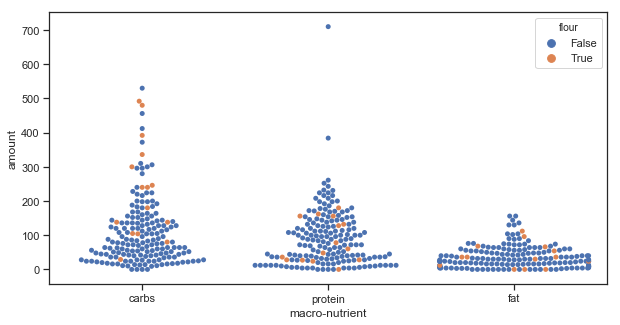

In [8]:
examine_ingredient('flour')

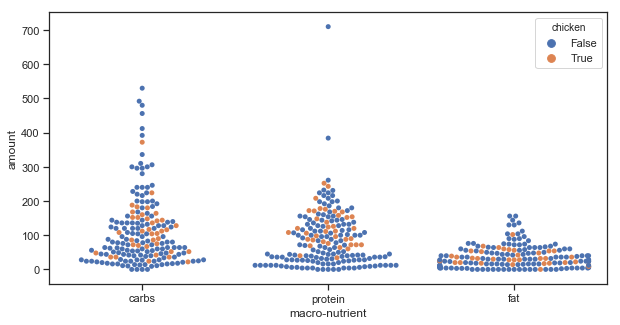

In [9]:
examine_ingredient('chicken')

There's relatively little data so it's impossible to see definite patterns. It does seem that recipes with flour tend to be slighthly higher on carbs and lower on protein, while recipes with chicken tend to have a little more protein. The evidence at this stage seems promising but very weak - perhaps more obvious patterns will emerge after preprocessing the ingredients.

## 3. Ingredient preprocessing

In [10]:
all_ingredients = [ingredient for _, row in recipes_df.iterrows()
                   for ingredient in row['ingredients'] if ingredient.strip()]

In [11]:
all_ingredients[:10]

['1 Ib sirloin, cut into',
 '1-inch cubes',
 '10 oz spinach, fresh or frozen',
 '1 large onion, quartered',
 '2 1-inch cubes of fresh ginger, peeled',
 '6 cloves garlic',
 '1 cup frozen green peas',
 '1 cup whole plain yogurt',
 '1 tbsp olive oil',
 '1/4 cup water']

Let's remove everything in parenthesis for the time being, to simplify the analysis

In [12]:
all_ingredients = [re.sub(r'\([^\)]*\)', '', ingredient).strip() for ingredient in all_ingredients]
all_ingredients[:10]

['1 Ib sirloin, cut into',
 '1-inch cubes',
 '10 oz spinach, fresh or frozen',
 '1 large onion, quartered',
 '2 1-inch cubes of fresh ginger, peeled',
 '6 cloves garlic',
 '1 cup frozen green peas',
 '1 cup whole plain yogurt',
 '1 tbsp olive oil',
 '1/4 cup water']

### Amount extraction
Almost all ingredient descriptions begin with the amount. Let's first extract and remove it.

In [13]:
def extract_amount(ingredient):
    m = re.search(r'([^a-zA-Z]*\d)', ingredient)
    if not m:
        return ''
    temp_res = m.groups()[0]
    res = ''
    for c in temp_res:
        if c.lower() == 'l': # Replace 'L' with '1'
            c = '1'
        if c.isdigit() or c in ['/', '.']:
            res += c
            
    if res.startswith('/'):
        res = '1' + res
        
    return res

amounts_strings = [extract_amount(ingredient) for ingredient in all_ingredients]

# Replace fractions with their value
def handle_fractions(amount_text):
    m = re.search(r'(\d+)/(\d+)', amount_text)
    if not m:
        return amount_text
    
    a, b = map(float, m.groups())
    return '%s %f' % (amount_text[:m.span()[0]], a / b)

amounts = [handle_fractions(amount) for amount in amounts_strings]

# Add numbers separated by space; if no numbers are specified we assume the amount is 1
amounts = [sum(map(float, amount.split())) if amount != '' else 1 for amount in amounts]

print(amounts[:10])

[1.0, 1.0, 10.0, 1.0, 21.0, 6.0, 1.0, 1.0, 1.0, 0.25]


Now that we have the amounts we can remove them from the original ingredient text

In [14]:
for i in range(len(all_ingredients)):
    all_ingredients[i] = all_ingredients[i][len(amounts_strings[i]):].strip()
    
all_ingredients[:10]

['Ib sirloin, cut into',
 '-inch cubes',
 'oz spinach, fresh or frozen',
 'large onion, quartered',
 '1-inch cubes of fresh ginger, peeled',
 'cloves garlic',
 'cup frozen green peas',
 'cup whole plain yogurt',
 'tbsp olive oil',
 'cup water']

### Textual analysis
Next let's examine the textual composition of ingredient description and try to extract measurements and ingredients.

In [15]:
all_ingredients = [x.lower() for x in all_ingredients]
all_ingredients[:10]

['ib sirloin, cut into',
 '-inch cubes',
 'oz spinach, fresh or frozen',
 'large onion, quartered',
 '1-inch cubes of fresh ginger, peeled',
 'cloves garlic',
 'cup frozen green peas',
 'cup whole plain yogurt',
 'tbsp olive oil',
 'cup water']

In [16]:
from wordcloud import WordCloud

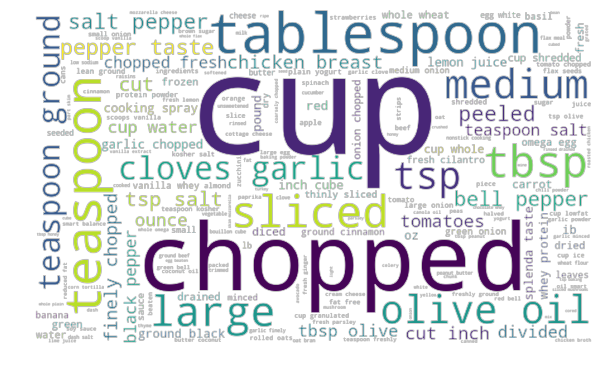

In [17]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(all_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It seems that measurement names and processing methods mostly dominate, which makes sense (ingredients will probably be more diverse). Also most of the processing methods seem to be mechanical ("sliced", "divided", "ground", etc.) and thus unlikely to affect nutritional value. Seems like we could start with isolating measurements somehow and then remove processing methods to isolate the ingredients as well. Also unlike ingredients, which might be defined by more than one word, hopefully most measurements will be limited to a single word.

We'll use NLTK to tokenize the ingredients and remove stop-words and punctuation, then use NLTK's PorterStemmer to group together variations of the same word.

In [18]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer
stop = stopwords.words('english') + list(string.punctuation)
porter_stemmer = PorterStemmer()

In [19]:
tokenized_stemmed_ingredients = [' '.join([porter_stemmer.stem(x) for x in word_tokenize(ingredient) if x not in stop])
                                 for ingredient in all_ingredients]

In [20]:
tokenized_stemmed_ingredients[30:40]

['cup slice green onion',
 'cup chop tomato',
 'tablespoon oliv oil divid',
 'skinless boneless chicken breast halv',
 'teaspoon salt divid',
 'teaspoon freshli ground black pepper',
 'cup fat-fre lower-sodium chicken broth divid',
 'cup unfilt appl cider',
 'tablespoon whole-grain dijon mustard',
 'tablespoon butter divid']

In [21]:
pd.DataFrame([{'word': k, 'count': v} 
              for k, v in FreqDist(' '.join(tokenized_stemmed_ingredients).split()).items()]). \
    sort_values('count', ascending=False).reset_index(drop=True).head(20)

count        word
0     450         cup
1     222        chop
2     166    teaspoon
3     114      pepper
4     108        salt
5     105  tablespoon
6     101       slice
7      99        tbsp
8      94         tsp
9      88       fresh
10     81      ground
11     80         oil
12     78        larg
13     75       onion
14     71      garlic
15     66      medium
16     60       clove
17     57        tast
18     56        oliv
19     52         cut

In [22]:
# Common measurements
stemmed_measurements = {'teaspoon', 'cup', 'tablespoon', 'ounc',
                        'slice', 'tbsp', 'tsp', 'clove', 'whole', 
                        'scoop', 'ib', 'pound', 'dash', 'lb', 'piec',
                        'large', 'medium', 'small', 'can'}

ingredient_measurements = []
clean_ingredients = []
for ingredient in all_ingredients:
    if not ingredient.strip():
        continue
    ingredient_words = word_tokenize(ingredient)
    measurement = ''
    if porter_stemmer.stem(ingredient_words[0]) in stemmed_measurements:
        measurement = porter_stemmer.stem(ingredient_words[0])
    ingredient_measurements.append(measurement)
    clean_ingredients.append(' '.join([x for x in ingredient_words 
                                       if porter_stemmer.stem(x) not in stemmed_measurements]))
    

# Any ingredient for which we didn't find a proper measurement can be considered "unit"

ingredient_measurements = [measurement if measurement else 'unit' for measurement in ingredient_measurements]

# Some measurements are equivalents (either shortname or OCR error), let's fix them
equivalent_measurements = {
    'tsp': 'teaspoon',
    'tbsp': 'tablespoon',
    'ib': 'pound',
    'lb': 'pound'
}

for i in range(len(ingredient_measurements)):
    if ingredient_measurements[i] in equivalent_measurements:
        ingredient_measurements[i] = equivalent_measurements[ingredient_measurements[i]]

ingredient_measurements[:10]

['pound',
 'unit',
 'unit',
 'unit',
 'unit',
 'clove',
 'cup',
 'cup',
 'tablespoon',
 'cup']

In [23]:
clean_ingredients[:10]

['sirloin , cut into',
 '-inch cubes',
 'oz spinach , fresh or frozen',
 'large onion , quartered',
 '1-inch cubes of fresh ginger , peeled',
 'garlic',
 'frozen green peas',
 'plain yogurt',
 'olive oil',
 'water']

The measurements seem quite good, and the remaining (cleaned) ingredients also seem quite good.

We now want to "choose" an n-gram from each ingredient, such that we'll group together as much as possible similar ingredients without losing too much variation.

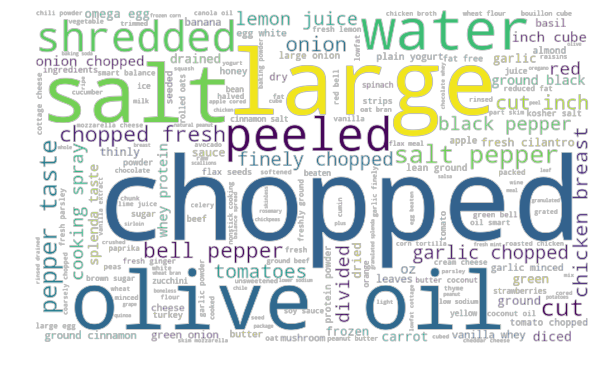

In [24]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(clean_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's try to use NLTK to remove verbs, adverbs and adjectives, and see how well that isolates the ingredients.

In [25]:
from nltk import pos_tag

In [26]:
# All POS tags
set([elem for ingredient in clean_ingredients for elem in [x[1] for x in pos_tag(ingredient.split())]])

{'(',
 ')',
 ',',
 '.',
 ':',
 'CC',
 'CD',
 'DT',
 'IN',
 'JJ',
 'JJR',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PRP',
 'RB',
 'RP',
 'TO',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WRB'}

In [27]:
# Choose desired POS tags; also remove some words which are confusing.
# We'll also remove stop words and punctuation marks.
desired_pos_tags = ['NN', 'NNS']
to_remove = ['ground', 'meal', 'water', 'chunk', 'plain', 'cook']

filtered_ingredients = []
for ingredient in clean_ingredients:
    for term_to_remove in to_remove:
        ingredient = ingredient.replace(term_to_remove, '').strip()
    filtered = []
    for token, tag in pos_tag(ingredient.split()):
        if tag in desired_pos_tags and token not in stop:
            filtered.append(token)
            
    filtered_ingredients.append(' '.join(filtered))

filtered_ingredients[:10]

['sirloin',
 '-inch cubes',
 'spinach',
 'onion',
 'cubes ginger',
 'garlic',
 'peas',
 'yogurt',
 'oil',
 '']

In [28]:
# Let's also stem
stemmed_ingredients = [' '.join([porter_stemmer.stem(token)
                                 for token in word_tokenize(ingredient)]) 
                       for ingredient in filtered_ingredients]

stemmed_ingredients[:10]

['sirloin',
 '-inch cube',
 'spinach',
 'onion',
 'cube ginger',
 'garlic',
 'pea',
 'yogurt',
 'oil',
 '']

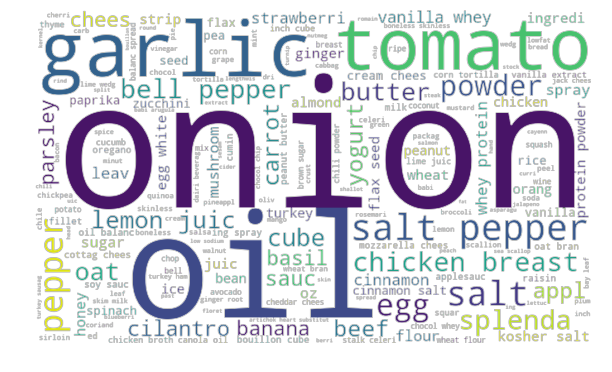

In [29]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(stemmed_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Looks quite good! Now let's try to choose the "best" n-grams (however we'll define that).

In [30]:
from nltk import bigrams

The approach we'll try is as follows: we'll simultaneously construct a list of raw ingredients and assign them to the recipes' ingredients. At each iteration we'll take all of the ingredients with no assigned raw ingredient, count 1- and 2-grams, and add the most common term to the list of ingredients. We'll also add a secondary sort by string length to handle cases like "cooking spray", which appears in the same instances as "spray". While not strictly necessary it makes the ingredients more interpretable.
Let's first try out the 1- and 2-gram counting:

In [31]:
one_and_two_ngram_counts = list(FreqDist(' '.join(stemmed_ingredients).split()).items()) + \
                           list(FreqDist([' '.join(y) 
                                          for x in [bigrams(ingredient.split())
                                                    for ingredient in stemmed_ingredients] 
                                          for y in x]).items())
(pd.DataFrame([{'term': k, 'count': v} 
              for k, v in one_and_two_ngram_counts]). 
    pipe(lambda df: df.assign(term_length=df['term'].str.len())).
    sort_values(['count', 'term_length'], ascending=[False, False]).reset_index(drop=True)).head(15)

count         term  term_length
0     108         salt            4
1     107       pepper            6
2      80          oil            3
3      75        onion            5
4      56       garlic            6
5      51        chees            5
6      49       tomato            6
7      46       powder            6
8      43          egg            3
9      42      chicken            7
10     39         juic            4
11     36         cube            4
12     32  salt pepper           11
13     31      vanilla            7
14     31       breast            6

This looks fine, let's go for the approach described above:

In [32]:
raw_ingredients = []
assigned_ingredients = [None for ingredient in stemmed_ingredients]
unassigned_ingredients = stemmed_ingredients
while unassigned_ingredients:
    one_and_two_ngram_counts = list(FreqDist(' '.join(unassigned_ingredients).split()).items()) + \
                           list(FreqDist([' '.join(y) 
                                          for x in [bigrams(ingredient.split())
                                                    for ingredient in unassigned_ingredients] 
                                          for y in x]).items())
    chosen_term = (pd.DataFrame([{'term': k, 'count': v} 
                                 for k, v in one_and_two_ngram_counts]). 
                pipe(lambda df: df.assign(term_length=df['term'].str.len())).
                sort_values(['count', 'term_length'], 
                            ascending=[False, False]).reset_index(drop=True)).term.values[0]
    raw_ingredients.append(chosen_term)
    unassigned_ingredients = []
    for i, stemmed_ingredient in enumerate(stemmed_ingredients):
        if assigned_ingredients[i]:
            continue
        if (stemmed_ingredient.startswith(chosen_term) or
            stemmed_ingredient.endswith(chosen_term) or
            ' %s ' % chosen_term in stemmed_ingredient):
            assigned_ingredients[i] = chosen_term
        elif stemmed_ingredient:
            unassigned_ingredients.append(stemmed_ingredient)

print(raw_ingredients[:15])

['salt', 'oil', 'onion', 'pepper', 'garlic', 'chees', 'tomato', 'chicken', 'egg', 'powder', 'juic', 'oat', 'cube', 'cinnamon', 'splenda']


Looks quite good as well!  
To summarise - so far we have extracted the ingredient, measurement and amount for each of the ingredient descriptions. The extraction is definitely not perfect but I think it's good enough for the moment:

In [33]:
pd.DataFrame({'amount': amounts,
              'measurement': ingredient_measurements, 
              'ingredient': assigned_ingredients}).head(15)

amount measurement ingredient
0     1.00       pound    sirloin
1     1.00        unit       cube
2    10.00        unit    spinach
3     1.00        unit      onion
4    21.00        unit       cube
5     6.00       clove     garlic
6     1.00         cup        pea
7     1.00         cup     yogurt
8     1.00  tablespoon        oil
9     0.25         cup       None
10    1.00    teaspoon     powder
11    1.00    teaspoon     powder
12    1.00        unit       salt
13    1.50       pound       cube
14    2.00        unit   mushroom

In [34]:
(pd.DataFrame({'amount': amounts,
              'measurement': ingredient_measurements, 
              'ingredient': assigned_ingredients}).groupby(['ingredient', 'measurement']).
             count()['amount'].
             reset_index(name='count').sort_values('count', ascending=False)).head(15)

ingredient measurement  count
270       salt    teaspoon     66
194        oil  tablespoon     48
129     garlic       clove     47
234     pepper    teaspoon     35
271       salt        unit     33
58       chees         cup     30
114        egg        unit     30
191        oat         cup     29
204      onion        unit     27
195        oil    teaspoon     23
157       juic  tablespoon     23
84    cinnamon    teaspoon     22
235     pepper        unit     21
325     tomato        unit     21
304      spray        unit     20

## 4. Naïve attempt at macro-nutrient estimation
For the moment, we'll ignore all other feature and focus on the ingredients' predictive ability on macro-nutrients, which we expect to be relatively large. The simplest model we can assume is a linear relationship - any amount of some ingredient contains some amount of protein, fat, and carbohydrates. We can therefore try to use linear regression to infer those amounts, with the important observation that coefficients must be non-negative. As the data is sparse we don't necessarily expect good results yet, but this seems like a good reality check for the feasibility of the project.
First we'll construct a dataset containing the ingredient data (joint measurement and ingredient with the amount as the value) and macro-nutrient data. Keep in mind that the order of the ingredient data in the flat lists matches the ingredient in the recipes.

In [35]:
recipes = recipes_df.to_dict(orient='rows')
for recipe in recipes:
    recipe['macros'] = {
        'calories': recipe['calories'],
        'carbs': recipe['carbs'],
        'protein': recipe['protein'],
        'fat': recipe['fat']
    }

In [36]:
index = 0
data = []
for recipe in recipes:
    row = {}
    for ingredient in recipe['ingredients']:
        if not ingredient.strip():
            continue
        raw_ingredient = assigned_ingredients[index]
        measurement = ingredient_measurements[index]
        amount = amounts[index]
        index += 1
        if raw_ingredient:
            k = ' '.join([measurement, raw_ingredient])
            if k not in row:
                row[k] = 0
            row[k] += amount
    
    row.update(recipe['macros'])
    del row['calories']
    data.append(row)
    
data_df = pd.DataFrame(data).fillna(0)
data_df.head()

can artichok heart  can bean  can chicken  can juic  can orang  can pea  \
0                 0.0       0.0          0.0       0.0        0.0      0.0   
1                 0.0       0.0          0.0       0.0        0.0      0.0   
2                 0.0       0.0          0.0       0.0        0.0      0.0   
3                 0.0       0.0          0.0       0.0        0.0      0.0   
4                 0.0       0.0          0.0       0.0        0.0      0.0   

   can salt  can tomato  can tuna  carbs  ...  unit vanilla  unit wa  \
0       0.0         0.0       0.0     60  ...           0.0      0.0   
1       0.0         0.0       0.0     60  ...           0.0      0.0   
2       0.0         0.0       0.0     80  ...           0.0      0.0   
3       0.0         0.0       0.0     36  ...           0.0      0.0   
4       0.0         0.0       0.0     46  ...           0.0      0.0   

   unit wedg  unit white  unit y2 veget  unit zucchini  whole egg  whole leav  \
0        0.0         0.0            0.0            0.0        0.0         0.0   
1        0.0         0.0            0.0            0.0        0.0         0.0   
2        0.0         0.0            0.0            0.0        0.0         0.0   
3        0.0         0.0            0.0            0.0        0.0         0.0   
4        0.0         0.0            0.0            0.0        0.0         0.0   

   whole salt  whole wheat  
0         0.0          0.0  
1         0.0          0.0  
2         0.0          0.0  
3         0.0          0.0  
4         0.0          0.0  

[5 rows x 365 columns]

In [37]:
X = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]
X.head()

can artichok heart  can bean  can chicken  can juic  can orang  can pea  \
0                 0.0       0.0          0.0       0.0        0.0      0.0   
1                 0.0       0.0          0.0       0.0        0.0      0.0   
2                 0.0       0.0          0.0       0.0        0.0      0.0   
3                 0.0       0.0          0.0       0.0        0.0      0.0   
4                 1.0       0.0          0.0       0.0        0.0      0.0   

   can salt  can tomato  can tuna  clove garlic  ...  unit vanilla  unit wa  \
0       0.0         0.0       0.0           1.0  ...           0.0      0.0   
1       0.0         0.0       0.0           0.0  ...           0.0      0.0   
2       0.0         0.0       0.0           2.0  ...           0.0      0.0   
3       0.0         0.0       0.0           2.0  ...           0.0      0.0   
4       0.0         0.0       0.0           0.0  ...           0.0      0.0   

   unit wedg  unit white  unit y2 veget  unit zucchini  whole egg  whole leav  \
0        0.0         0.0            0.0            0.0        0.0         0.0   
1        0.0         0.0            0.0            0.0        2.0         0.0   
2        0.0         0.0            0.0            0.0        0.0         0.0   
3        0.0         0.0            0.0            0.0        0.0         0.0   
4        0.0         0.0            0.0            0.0        0.0         0.0   

   whole salt  whole wheat  
0         0.0          0.0  
1         0.0          0.0  
2         0.0          0.0  
3         0.0          0.0  
4         0.0          0.0  

[5 rows x 361 columns]

In [38]:
y = data_df[['carbs', 'protein', 'fat']]

Let's examine the resulting dataframe to assess the quality of all the preprocessing up to this point

In [39]:
res = []
for i in range(X.shape[0]):
    ingredients = []
    name = recipes_df.loc[i, 'name']
    original_ingredients = recipes_df.loc[i, 'ingredients']
    for j in range(X.shape[1]):
        if X.iloc[i, j] != 0:
            ingredients.append('%.2f %s' % (X.iloc[i, j], X.columns[j]))
            
    res.append({'recipe': name,
                'ingredients': ' + '.join(ingredients), 
                'original ingredients': original_ingredients})
    
preprocessed_df = pd.DataFrame(res)[['recipe', 'ingredients', 'original ingredients']]
preprocessed_df.to_csv('data/preprocessed.csv', index=False)
preprocessed_df.head()

recipe  \
0                           TOMATO AND GARLIC OMELET   
1                                      MIXED NUT BAR   
2  MASHED GARLIC CAULIFLOWER (MOCK MASHED POTATOE...   
3                            CHICAGO DEEP DISH PIZZA   
4                            SPINACH ARTICHOKE DIP A   

                                         ingredients  \
0  1.00 clove garlic + 0.75 cup egg + 0.50 slice ...   
1  0.75 cup almond + 0.25 cup walnut + 6.00 scoop...   
2  2.00 clove garlic + 1.00 tablespoon oil + 1.00...   
3  2.00 clove garlic + 0.50 cup mozzarella + 1.00...   
4  1.00 can artichok heart + 0.50 cup cream + 7.0...   

                                original ingredients  
0  [1/2 slice whole wheat bread, 2 tablespoons gr...  
1  [3/4 cup pecan meal, 3/4 cup almond meal, 1/4 ...  
2  [1 large head cauliflower, 1 tbsp butter, coco...  
3  [Crust:, /2 cup whole wheat flour, cup wheat b...  
4  [1/2 cup fat-free sour cream, 1/4 teaspoon fre...

We can try to use scipy's nnls (Non-Negative Least Squares) as a linear regression with non-negative coefficients. Due to the small amount of data, we'll run several rounds of fit-predict and record the prediction-vs-ground truth, as well as the resulting coefficients.

In [40]:
from scipy.optimize import nnls

In [37]:
from sklearn.model_selection import train_test_split

In [42]:
carbs_predicted = []
carbs_gt = []
protein_predicted = []
protein_gt = []
fat_predicted = []
fat_gt = []
coef = {'carbs': [], 'protein': [], 'fat': []}
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    x_carbs, r = nnls(X_train, y_train['carbs'])
    x_protein, r = nnls(X_train, y_train['protein'])
    x_fat, r = nnls(X_train, y_train['fat'])
    carbs_predicted += list(np.dot(X_test, x_carbs))
    carbs_gt += list(y_test['carbs'])
    protein_predicted += list(np.dot(X_test, x_protein))
    protein_gt += list(y_test['protein'])
    fat_predicted += list(np.dot(X_test, x_fat))
    fat_gt += list(y_test['fat'])
    coef['carbs'].append(list(x_carbs))
    coef['protein'].append(list(x_protein))
    coef['fat'].append(list(x_fat))

In [43]:
original_carbs_predicted = np.array(carbs_predicted)
original_protein_predicted = np.array(protein_predicted)
original_fat_predicted = np.array(fat_predicted)

carbs_predicted = np.minimum(carbs_predicted, y_train['carbs'].max())
protein_predicted = np.minimum(protein_predicted, y_train['protein'].max())
fat_predicted = np.minimum(protein_predicted, y_train['fat'].max())

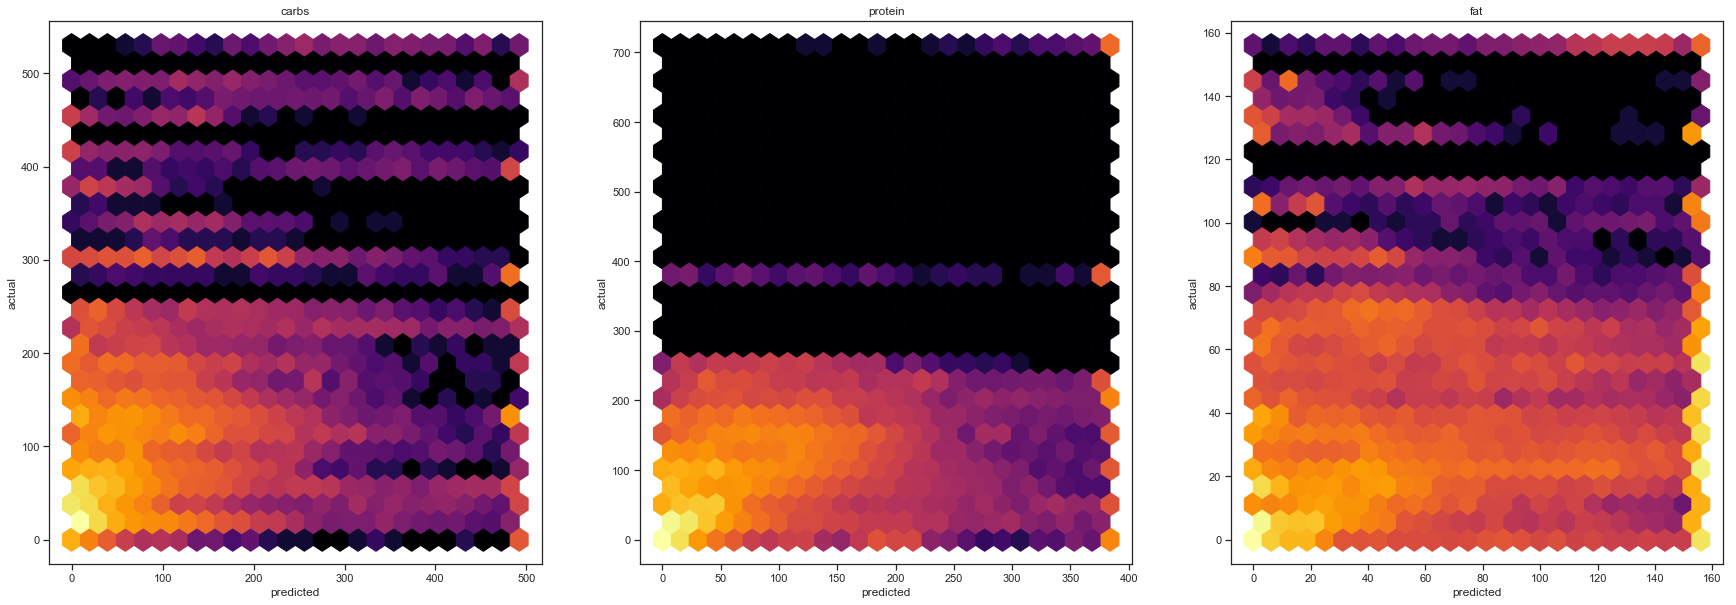

In [44]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.hexbin(carbs_predicted, carbs_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('carbs')

plt.subplot(1, 3, 2)
plt.hexbin(protein_predicted, protein_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('protein')

plt.subplot(1, 3, 3)
plt.hexbin(fat_predicted, fat_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('fat')

plt.show()

The results don't seem too accurate, but maybe a good start. This might be due to lack of data - let's try to plot the learning curve (over many rounds, the average train and test error by trainin set size) to see if we can hope to improve the result using more data.  
I will note that it seems that most of the errors lie above the f(x) = x line, indicating (perhaps) that many ingredients are too rare to be properly learned, leading to an estimation that is too small. But that's just one possible interpretation.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_carbs, r_train = nnls(X_train, y_train['carbs'])
r_test = np.linalg.norm(np.dot(X_test, x_carbs) - y_test['carbs'])

In [46]:
n_training_set = []
r_trains = []
r_tests = []
r_trains_mean = []
r_tests_mean = []
N = 500
RANGE = range(50, 131, 10)
for i in RANGE:
    for j in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        indices = np.random.choice(np.arange(X_train.shape[0]), i)
        X_train = X_train.iloc[indices]
        y_train = y_train.iloc[indices]
        x_carbs, r_train = nnls(X_train, y_train['carbs'])
        r_test = np.linalg.norm(np.dot(X_test, x_carbs) - y_test['carbs'])
        r_trains.append(r_train)
        r_tests.append(r_test)
        n_training_set.append(i)
        
    r_trains_mean.append(np.mean(r_trains[-N:]))
    r_tests_mean.append(np.mean(r_tests[-N:]))
        

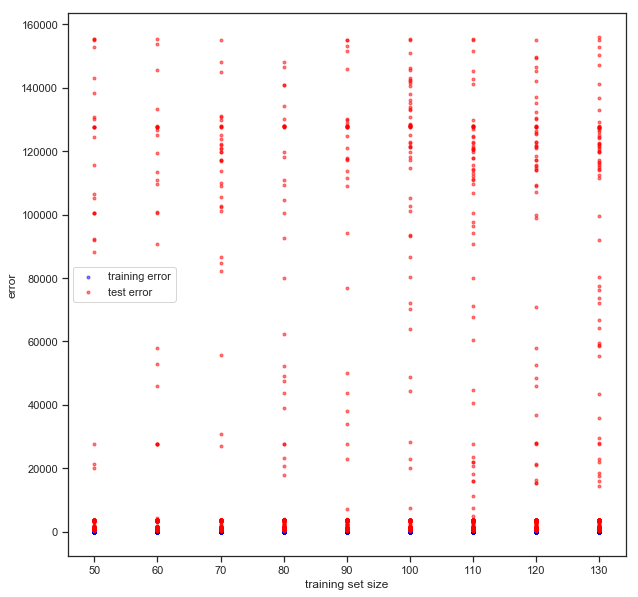

In [47]:
plt.figure(figsize=(10, 10))
plt.scatter(n_training_set, r_trains, c='blue', label='training error', alpha=0.5, marker='.')
plt.scatter(n_training_set, r_tests, c='red', label='test error', alpha=0.5, marker='.')
plt.legend()
plt.xlabel('training set size')
plt.ylabel('error')
plt.show()

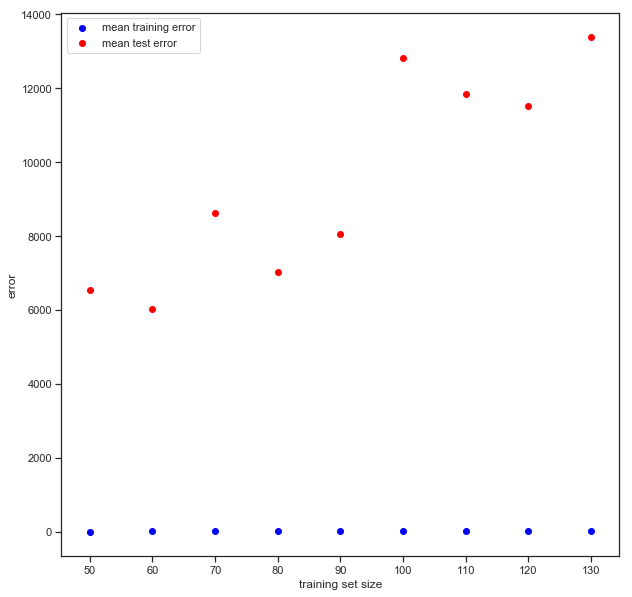

In [48]:
plt.figure(figsize=(10, 10))
plt.scatter(RANGE, r_trains_mean, c='blue', label='mean training error')
plt.scatter(RANGE, r_tests_mean, c='red', label='mean test error')
plt.legend()
plt.xlabel('training set size')
plt.ylabel('error')
plt.show()

Very strangely it seems like the error is increasing with training set size!
This will require investigation. We also see quite astronomical errors due to very very large estimations. Probably some regularization is required to constrain the amounts of nutrients that are expected to be in ingredients.

One last thing - the coefficients for a certain ingredient (measurement + raw ingredient) should match the amount of respective macro-nutrient in that ingredient.

In [49]:
mean_carbs = np.array(coef['carbs']).mean(axis=0)
mean_protein = np.array(coef['protein']).mean(axis=0)
mean_fat = np.array(coef['fat']).mean(axis=0)

def examine_macros(ingredient):
    ingredient_index = list(X.columns).index(ingredient)
    carbs = mean_carbs[ingredient_index]
    protein = mean_protein[ingredient_index]
    fat = mean_fat[ingredient_index]
    print('Estimated macros for %s: %.2fg carbs, %.2fg protein, %.2fg fat' % (ingredient, carbs, protein, fat))

In [50]:
examine_macros('cup flour')

Estimated macros for cup flour: 138.69g carbs, 19.57g protein, 3.78g fat


In [51]:
examine_macros('unit egg')

Estimated macros for unit egg: 0.05g carbs, 0.15g protein, 0.04g fat


In [52]:
examine_macros('ounc chees')

Estimated macros for ounc chees: 0.98g carbs, 0.60g protein, 1.61g fat


In [53]:
examine_macros('tablespoon oil')

Estimated macros for tablespoon oil: 0.00g carbs, 0.01g protein, 0.13g fat


In [54]:
examine_macros('cup sugar')

Estimated macros for cup sugar: 91.61g carbs, 1.96g protein, 2.86g fat


So while the data is far from accurate, we do see some promising trends.

In [55]:
X.columns[np.argmax(mean_fat)]

'cup pine nut'

## 5. Simple deep learning approach
Let's try to tackle the problem with a very simple deep learning model, using LSTM's, which are usually useful for sequence data. The first approach will be very simple and just feed the network the recipe's text (e.g. ingredients followed by instructions). As we have very little data we'll try to regularize the network and decrease the amount of hidden nodes.  
Due to the extremely small amount of data (compared to the dimensionality) I don't really expect this model to work well, but it could serve as a basis for more advanced models.

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os # Necessary to avoid funny bug on Mac with Tensorflow
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [57]:
recipes_text = [('NAME: %s ! INGREDIENTS: %s ! INSTRUCTIONS: %s' % (row['name'],
                                                             ' ;;; '.join(row['ingredients']),
                                                             row['instructions'])).lower()
                for _, row in recipes_df.iterrows()]

In [82]:
MAX_WORDS = 1500
tokenizer = Tokenizer(num_words=MAX_WORDS)

In [83]:
tokenizer.fit_on_texts(recipes_text)
print('Total %d tokens' % len(tokenizer.word_index))

Total 1781 tokens


In [84]:
X = tokenizer.texts_to_sequences(recipes_text)
X = pad_sequences(X, maxlen=400)
X.shape

(178, 400)

In [85]:
Y = recipes_df[['carbs', 'protein', 'fat']]
Y.shape

(178, 3)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [87]:
model = Sequential()
model.add(Embedding(MAX_WORDS, 64, input_length=X.shape[1]))
model.add(LSTM(8))
model.add(Dropout(0.5))
model.add(Dense(16))
model.add(Dropout(0.5))
model.add(Dense(3))

model.compile(loss='mse', optimizer='adam')

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 64)           96000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 2336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 98,531
Traina

In [90]:
model.fit(X_train, Y_train, epochs=200)
print('Test loss: %f' % model.evaluate(X_test, Y_test))

Epoch 1/200
133/133 [==============================] - 2s 17ms/step - loss: 5961.0445
Epoch 2/200
133/133 [==============================] - 2s 17ms/step - loss: 5755.3326
Epoch 3/200
133/133 [==============================] - 2s 17ms/step - loss: 5636.7422
Epoch 4/200
133/133 [==============================] - 2s 17ms/step - loss: 5668.8627
Epoch 5/200
133/133 [==============================] - 2s 17ms/step - loss: 4938.9349
Epoch 6/200
133/133 [==============================] - 2s 17ms/step - loss: 5110.8666
Epoch 7/200
133/133 [==============================] - 3s 22ms/step - loss: 5213.0832
Epoch 8/200
133/133 [==============================] - 3s 23ms/step - loss: 5584.4549
Epoch 9/200
133/133 [==============================] - 3s 22ms/step - loss: 5448.5121
Epoch 10/200
133/133 [==============================] - 3s 21ms/step - loss: 5758.7022
Epoch 11/200
133/133 [==============================] - 3s 23ms/step - loss: 5659.8449
Epoch 12/200
133/133 [==============================

133/133 [==============================] - 3s 22ms/step - loss: 4034.3489
Epoch 189/200
133/133 [==============================] - 3s 22ms/step - loss: 4473.9291
Epoch 190/200
133/133 [==============================] - 3s 22ms/step - loss: 4716.1021
Epoch 191/200
133/133 [==============================] - 3s 23ms/step - loss: 3969.8907
Epoch 192/200
133/133 [==============================] - 3s 23ms/step - loss: 3977.6189
Epoch 193/200
133/133 [==============================] - 3s 23ms/step - loss: 3846.3780
Epoch 194/200
133/133 [==============================] - 3s 21ms/step - loss: 4055.6992
Epoch 195/200
133/133 [==============================] - 3s 23ms/step - loss: 4548.6231
Epoch 196/200
133/133 [==============================] - 4s 27ms/step - loss: 4584.1013
Epoch 197/200
133/133 [==============================] - 3s 25ms/step - loss: 4643.8924
Epoch 198/200
133/133 [==============================] - 3s 23ms/step - loss: 3849.7019
Epoch 199/200
133/133 [=======================

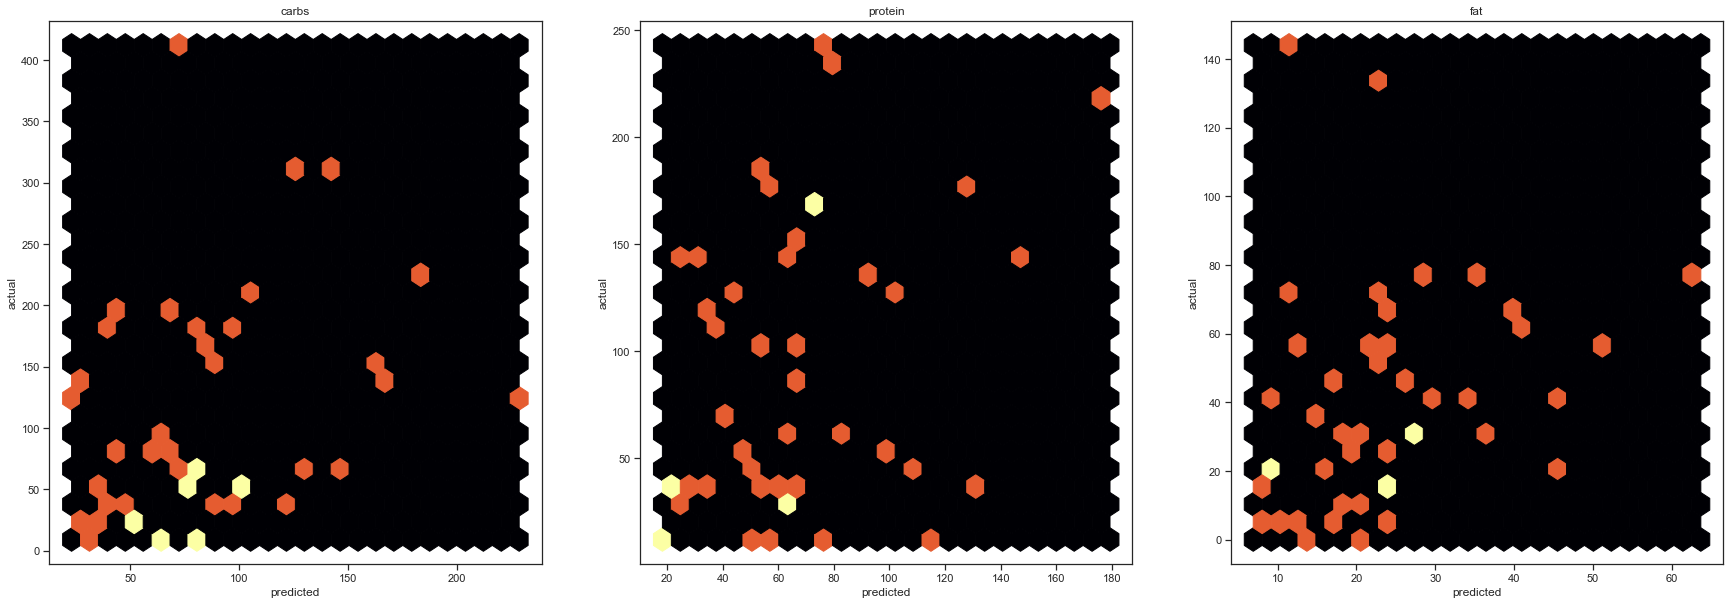

In [91]:
Y_pred = model.predict(X_test)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.hexbin(Y_pred[:, 0], Y_test.values[:, 0], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('carbs')

plt.subplot(1, 3, 2)
plt.hexbin(Y_pred[:, 1], Y_test.values[:, 1], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('protein')

plt.subplot(1, 3, 3)
plt.hexbin(Y_pred[:, 2], Y_test.values[:, 2], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('fat')

plt.show()

Doesn't look amazing but it does seem to learn something at least a little meaningful. This gives hope that more advanced models would be able to better fit the data - this model doesn't even have a real "understanding" of numbers in the ingredients section as they're just part of the text fed to the embedding layer.

## 6. More thourough deep learning approach
Let's try to incorporate the results of the ingredients preprocessing with a deep-learning-based approach. I'll start by feeding the recipe ingredients to a small, dense NN and see how it performs compared to the NNLS. After that we can try to construct a more sophisticated model which takes both the preprocessed ingredients as well as the instructions text as input.

In [291]:
X = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]
Y = data_df[['carbs', 'protein', 'fat']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [292]:
model = Sequential()
model.add(Dense(5, input_shape=(X.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(3))

model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 5)                 1810      
_________________________________________________________________
dropout_123 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_96 (Dense)             (None, 3)                 18        
Total params: 1,828
Trainable params: 1,828
Non-trainable params: 0
_________________________________________________________________


In [293]:
model.fit(X_train, Y_train, epochs=1000)
print('Test loss: %f' % model.evaluate(X_test, Y_test))

Epoch 1/1000
133/133 [==============================] - 6s 46ms/step - loss: 14961.3306
Epoch 2/1000
133/133 [==============================] - 0s 105us/step - loss: 14896.4277
Epoch 3/1000
133/133 [==============================] - 0s 95us/step - loss: 14989.2774
Epoch 4/1000
133/133 [==============================] - 0s 147us/step - loss: 14529.1008
Epoch 5/1000
133/133 [==============================] - 0s 118us/step - loss: 15356.3103
Epoch 6/1000
133/133 [==============================] - 0s 122us/step - loss: 14954.2772
Epoch 7/1000
133/133 [==============================] - 0s 111us/step - loss: 15163.6571
Epoch 8/1000
133/133 [==============================] - 0s 112us/step - loss: 15266.3481
Epoch 9/1000
133/133 [==============================] - 0s 121us/step - loss: 14537.1870
Epoch 10/1000
133/133 [==============================] - 0s 110us/step - loss: 15177.6171
Epoch 11/1000
133/133 [==============================] - 0s 102us/step - loss: 14527.1123
Epoch 12/1000
133/133

133/133 [==============================] - 0s 103us/step - loss: 9235.5147
Epoch 183/1000
133/133 [==============================] - 0s 122us/step - loss: 9351.7559
Epoch 184/1000
133/133 [==============================] - 0s 100us/step - loss: 10331.5151
Epoch 185/1000
133/133 [==============================] - 0s 108us/step - loss: 9878.3182
Epoch 186/1000
133/133 [==============================] - 0s 152us/step - loss: 9598.8017
Epoch 187/1000
133/133 [==============================] - 0s 145us/step - loss: 8524.6874
Epoch 188/1000
133/133 [==============================] - 0s 130us/step - loss: 8836.6875
Epoch 189/1000
133/133 [==============================] - 0s 118us/step - loss: 9127.2989
Epoch 190/1000
133/133 [==============================] - 0s 114us/step - loss: 8956.1211
Epoch 191/1000
133/133 [==============================] - 0s 118us/step - loss: 9330.1778
Epoch 192/1000
133/133 [==============================] - 0s 115us/step - loss: 8866.5964
Epoch 193/1000
133/133 [

133/133 [==============================] - 0s 123us/step - loss: 6022.4196
Epoch 365/1000
133/133 [==============================] - 0s 166us/step - loss: 5972.7633
Epoch 366/1000
133/133 [==============================] - 0s 118us/step - loss: 7546.4729
Epoch 367/1000
133/133 [==============================] - 0s 125us/step - loss: 5529.3112
Epoch 368/1000
133/133 [==============================] - 0s 112us/step - loss: 6041.8848
Epoch 369/1000
133/133 [==============================] - 0s 119us/step - loss: 6166.2288
Epoch 370/1000
133/133 [==============================] - 0s 100us/step - loss: 6586.9545
Epoch 371/1000
133/133 [==============================] - 0s 113us/step - loss: 5959.9463
Epoch 372/1000
133/133 [==============================] - 0s 125us/step - loss: 7122.1381
Epoch 373/1000
133/133 [==============================] - 0s 124us/step - loss: 5685.0567
Epoch 374/1000
133/133 [==============================] - 0s 113us/step - loss: 5990.2014
Epoch 375/1000
133/133 [=

133/133 [==============================] - 0s 148us/step - loss: 6639.1476
Epoch 547/1000
133/133 [==============================] - 0s 112us/step - loss: 6615.7981
Epoch 548/1000
133/133 [==============================] - 0s 118us/step - loss: 5912.3476
Epoch 549/1000
133/133 [==============================] - 0s 113us/step - loss: 5395.5475
Epoch 550/1000
133/133 [==============================] - 0s 113us/step - loss: 5219.1023
Epoch 551/1000
133/133 [==============================] - 0s 118us/step - loss: 5221.6926
Epoch 552/1000
133/133 [==============================] - 0s 115us/step - loss: 5722.2189
Epoch 553/1000
133/133 [==============================] - 0s 119us/step - loss: 5395.5693
Epoch 554/1000
133/133 [==============================] - 0s 124us/step - loss: 5308.9476
Epoch 555/1000
133/133 [==============================] - 0s 119us/step - loss: 4572.3975
Epoch 556/1000
133/133 [==============================] - 0s 119us/step - loss: 4681.3903
Epoch 557/1000
133/133 [=

133/133 [==============================] - 0s 140us/step - loss: 4778.1555
Epoch 729/1000
133/133 [==============================] - 0s 113us/step - loss: 5581.3844
Epoch 730/1000
133/133 [==============================] - 0s 117us/step - loss: 5270.2639
Epoch 731/1000
133/133 [==============================] - 0s 115us/step - loss: 6117.8045
Epoch 732/1000
133/133 [==============================] - 0s 115us/step - loss: 4392.6438
Epoch 733/1000
133/133 [==============================] - 0s 119us/step - loss: 5041.0975
Epoch 734/1000
133/133 [==============================] - 0s 123us/step - loss: 6064.0872
Epoch 735/1000
133/133 [==============================] - 0s 126us/step - loss: 5948.6554
Epoch 736/1000
133/133 [==============================] - 0s 119us/step - loss: 4687.8891
Epoch 737/1000
133/133 [==============================] - 0s 115us/step - loss: 5337.4124
Epoch 738/1000
133/133 [==============================] - 0s 108us/step - loss: 4574.4190
Epoch 739/1000
133/133 [=

133/133 [==============================] - 0s 113us/step - loss: 4789.8679
Epoch 911/1000
133/133 [==============================] - 0s 118us/step - loss: 4262.5477
Epoch 912/1000
133/133 [==============================] - 0s 118us/step - loss: 4565.4407
Epoch 913/1000
133/133 [==============================] - 0s 121us/step - loss: 5331.1591
Epoch 914/1000
133/133 [==============================] - 0s 121us/step - loss: 5531.1961
Epoch 915/1000
133/133 [==============================] - 0s 113us/step - loss: 6445.9571
Epoch 916/1000
133/133 [==============================] - 0s 115us/step - loss: 4511.1066
Epoch 917/1000
133/133 [==============================] - 0s 121us/step - loss: 6352.0908
Epoch 918/1000
133/133 [==============================] - 0s 116us/step - loss: 4551.2508
Epoch 919/1000
133/133 [==============================] - 0s 115us/step - loss: 4764.2431
Epoch 920/1000
133/133 [==============================] - 0s 96us/step - loss: 4175.5675
Epoch 921/1000
133/133 [==

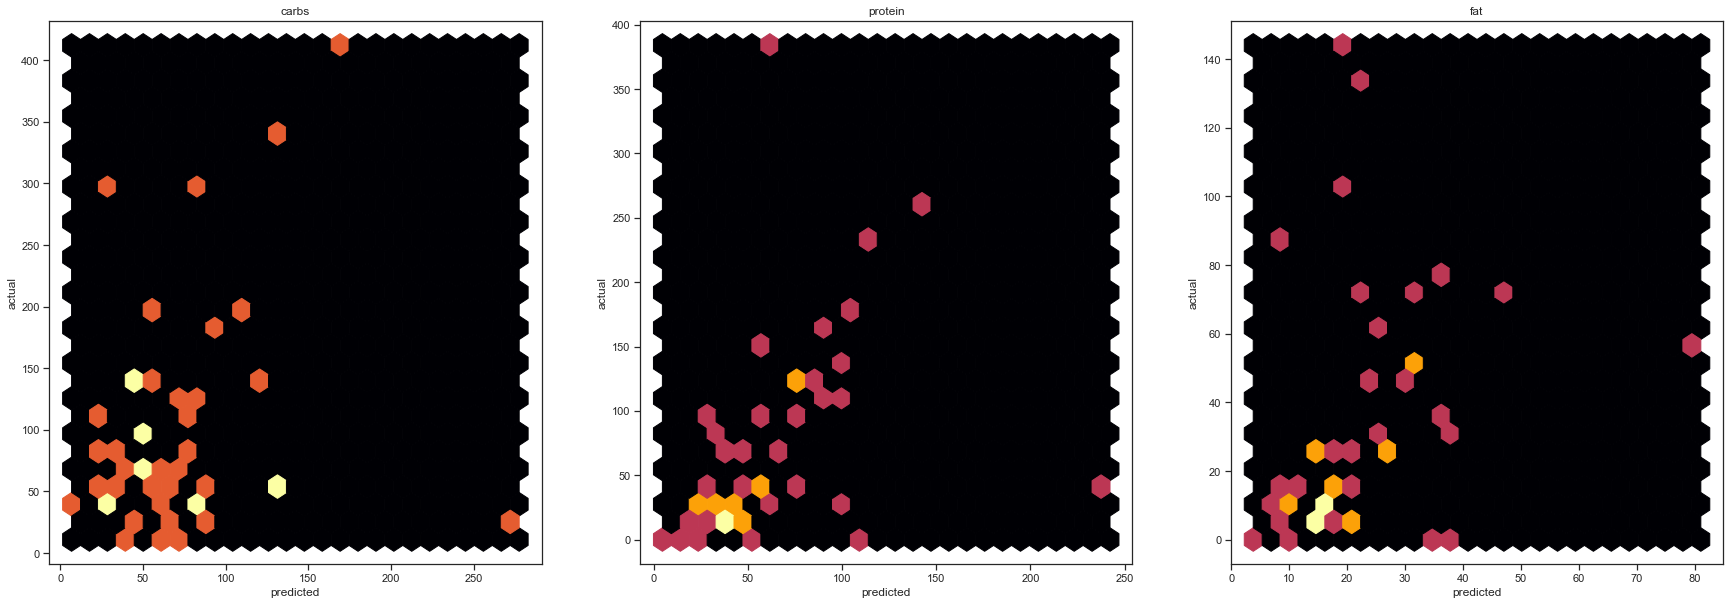

In [294]:
Y_pred = model.predict(X_test)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.hexbin(Y_pred[:, 0], Y_test.values[:, 0], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('carbs')

plt.subplot(1, 3, 2)
plt.hexbin(Y_pred[:, 1], Y_test.values[:, 1], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('protein')

plt.subplot(1, 3, 3)
plt.hexbin(Y_pred[:, 2], Y_test.values[:, 2], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('fat')

plt.show()

For some runs the results look promising, while for others the model is severly overfitting. In general this method does seem hopeful.

### Training data augmentation
We can try to augment the training data by "multiplying" recipes by some amount, and adjusting both the ingredient amounts and the macronutrients accordingly.

In [303]:
import random

In [324]:
X = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]
Y = data_df[['carbs', 'protein', 'fat']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

N = Y_train.shape[0]
for i in range(N):
    # Duplicate the recipe with different amounts between 5-10 times
    for j in range(random.randint(5, 10)):
        amount = np.random.random() * 10 + 0.5
        X_train = \
            X_train.append([X_train.iloc[i, :] * amount])
        Y_train = Y_train.append([Y_train.iloc[i, :] * amount])
        
X_train.shape, Y_train.shape

((1133, 361), (1133, 3))

In [342]:
from keras.optimizers import adam

In [345]:
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],)))
model.add(Dropout(0.5))

model.add(Dense(3))

model.compile(loss='mse', optimizer=adam(lr=0.0001))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 16)                5792      
_________________________________________________________________
dropout_140 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 3)                 51        
Total params: 5,843
Trainable params: 5,843
Non-trainable params: 0
_________________________________________________________________


In [346]:
model.fit(X_train, Y_train, epochs=10000)
print('Test loss: %f' % model.evaluate(X_test, Y_test))

Epoch 1/10000
1133/1133 [==============================] - 7s 6ms/step - loss: 448365.5948
Epoch 2/10000
1133/1133 [==============================] - 0s 105us/step - loss: 447287.6980
Epoch 3/10000
1133/1133 [==============================] - 0s 249us/step - loss: 447489.3315
Epoch 4/10000
1133/1133 [==============================] - 0s 115us/step - loss: 444844.0323
Epoch 5/10000
1133/1133 [==============================] - 0s 104us/step - loss: 441408.1574
Epoch 6/10000
1133/1133 [==============================] - 0s 112us/step - loss: 445771.9876
Epoch 7/10000
1133/1133 [==============================] - 0s 102us/step - loss: 442252.4798
Epoch 8/10000
1133/1133 [==============================] - 0s 113us/step - loss: 444891.9547
Epoch 9/10000
1133/1133 [==============================] - 0s 109us/step - loss: 445447.6863
Epoch 10/10000
1133/1133 [==============================] - 0s 113us/step - loss: 441225.1460
Epoch 11/10000
1133/1133 [==============================] - 0s 101us/st

1133/1133 [==============================] - 0s 132us/step - loss: 269944.6742
Epoch 175/10000
1133/1133 [==============================] - 0s 118us/step - loss: 274443.1277
Epoch 176/10000
1133/1133 [==============================] - 0s 122us/step - loss: 265850.8093
Epoch 177/10000
1133/1133 [==============================] - 0s 110us/step - loss: 276628.5995
Epoch 178/10000
1133/1133 [==============================] - 0s 115us/step - loss: 263411.1145
Epoch 179/10000
1133/1133 [==============================] - 0s 122us/step - loss: 264589.7006
Epoch 180/10000
1133/1133 [==============================] - 0s 121us/step - loss: 269061.2508
Epoch 181/10000
1133/1133 [==============================] - 0s 262us/step - loss: 266107.0808
Epoch 182/10000
1133/1133 [==============================] - 0s 371us/step - loss: 260927.4574
Epoch 183/10000
1133/1133 [==============================] - 0s 111us/step - loss: 268211.4772
Epoch 184/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 117us/step - loss: 126887.1034
Epoch 347/10000
1133/1133 [==============================] - 0s 130us/step - loss: 133614.3874
Epoch 348/10000
1133/1133 [==============================] - 0s 121us/step - loss: 135742.7133
Epoch 349/10000
1133/1133 [==============================] - 0s 183us/step - loss: 132928.6153
Epoch 350/10000
1133/1133 [==============================] - 1s 448us/step - loss: 135892.4980
Epoch 351/10000
1133/1133 [==============================] - 0s 121us/step - loss: 134328.7639
Epoch 352/10000
1133/1133 [==============================] - 0s 116us/step - loss: 142778.1562
Epoch 353/10000
1133/1133 [==============================] - 0s 123us/step - loss: 135179.7356
Epoch 354/10000
1133/1133 [==============================] - 0s 119us/step - loss: 136793.5131
Epoch 355/10000
1133/1133 [==============================] - 0s 125us/step - loss: 140446.8926
Epoch 356/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 125us/step - loss: 94091.9630
Epoch 519/10000
1133/1133 [==============================] - 0s 157us/step - loss: 100748.7787
Epoch 520/10000
1133/1133 [==============================] - 0s 152us/step - loss: 96480.8825
Epoch 521/10000
1133/1133 [==============================] - 0s 160us/step - loss: 96453.8202
Epoch 522/10000
1133/1133 [==============================] - 0s 154us/step - loss: 100261.0747
Epoch 523/10000
1133/1133 [==============================] - 0s 128us/step - loss: 97697.3564
Epoch 524/10000
1133/1133 [==============================] - 0s 245us/step - loss: 101417.0487
Epoch 525/10000
1133/1133 [==============================] - 0s 292us/step - loss: 95922.0306
Epoch 526/10000
1133/1133 [==============================] - 0s 275us/step - loss: 99441.4594
Epoch 527/10000
1133/1133 [==============================] - 0s 115us/step - loss: 93141.1783
Epoch 528/10000
1133/1133 [==============================] - 0s 124us/ste

1133/1133 [==============================] - 0s 119us/step - loss: 88614.9754
Epoch 606/10000
1133/1133 [==============================] - 0s 123us/step - loss: 87722.4187
Epoch 607/10000
1133/1133 [==============================] - 0s 123us/step - loss: 93813.0411
Epoch 608/10000
1133/1133 [==============================] - 0s 125us/step - loss: 85637.8225
Epoch 609/10000
1133/1133 [==============================] - 0s 258us/step - loss: 84571.7327
Epoch 610/10000
1133/1133 [==============================] - 0s 336us/step - loss: 90356.6175
Epoch 611/10000
1133/1133 [==============================] - 0s 110us/step - loss: 86221.7384
Epoch 612/10000
1133/1133 [==============================] - 0s 118us/step - loss: 87029.3026
Epoch 613/10000
1133/1133 [==============================] - 0s 113us/step - loss: 87942.6206
Epoch 614/10000
1133/1133 [==============================] - 0s 127us/step - loss: 88937.7108
Epoch 615/10000
1133/1133 [==============================] - 0s 125us/step -

1133/1133 [==============================] - 0s 125us/step - loss: 75276.8407
Epoch 780/10000
1133/1133 [==============================] - 0s 119us/step - loss: 84328.1996
Epoch 781/10000
1133/1133 [==============================] - 0s 112us/step - loss: 78302.6188
Epoch 782/10000
1133/1133 [==============================] - 0s 121us/step - loss: 76490.1889
Epoch 783/10000
1133/1133 [==============================] - 0s 115us/step - loss: 86104.4568
Epoch 784/10000
1133/1133 [==============================] - 0s 400us/step - loss: 79311.1217
Epoch 785/10000
1133/1133 [==============================] - 0s 105us/step - loss: 80149.8386
Epoch 786/10000
1133/1133 [==============================] - 0s 263us/step - loss: 73451.6092
Epoch 787/10000
1133/1133 [==============================] - 0s 114us/step - loss: 79773.0720
Epoch 788/10000
1133/1133 [==============================] - 0s 119us/step - loss: 76315.2722
Epoch 789/10000
1133/1133 [==============================] - 0s 109us/step -

1133/1133 [==============================] - 0s 120us/step - loss: 81715.2105
Epoch 954/10000
1133/1133 [==============================] - 0s 120us/step - loss: 74341.2469
Epoch 955/10000
1133/1133 [==============================] - 0s 120us/step - loss: 64179.9847
Epoch 956/10000
1133/1133 [==============================] - 0s 387us/step - loss: 63439.7551
Epoch 957/10000
1133/1133 [==============================] - 0s 115us/step - loss: 72171.1439
Epoch 958/10000
1133/1133 [==============================] - 0s 110us/step - loss: 72782.3829
Epoch 959/10000
1133/1133 [==============================] - 0s 275us/step - loss: 75161.1280
Epoch 960/10000
1133/1133 [==============================] - 0s 111us/step - loss: 67136.3034
Epoch 961/10000
1133/1133 [==============================] - 0s 138us/step - loss: 65928.0716
Epoch 962/10000
1133/1133 [==============================] - 0s 110us/step - loss: 70382.6828
Epoch 963/10000
1133/1133 [==============================] - 0s 120us/step -

1133/1133 [==============================] - 0s 244us/step - loss: 67131.1375
Epoch 1126/10000
1133/1133 [==============================] - 0s 111us/step - loss: 61810.1899
Epoch 1127/10000
1133/1133 [==============================] - 0s 122us/step - loss: 70653.3665
Epoch 1128/10000
1133/1133 [==============================] - 0s 119us/step - loss: 69783.2912
Epoch 1129/10000
1133/1133 [==============================] - 0s 125us/step - loss: 68148.6860
Epoch 1130/10000
1133/1133 [==============================] - 0s 124us/step - loss: 69200.1972
Epoch 1131/10000
1133/1133 [==============================] - 0s 125us/step - loss: 59501.9955
Epoch 1132/10000
1133/1133 [==============================] - 1s 476us/step - loss: 65616.7108
Epoch 1133/10000
1133/1133 [==============================] - 0s 118us/step - loss: 59972.0705
Epoch 1134/10000
1133/1133 [==============================] - 0s 115us/step - loss: 63161.6214
Epoch 1135/10000
1133/1133 [==============================] - 0s 12

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161004). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 0s 105us/step - loss: 62763.0998
Epoch 1288/10000
1133/1133 [==============================] - 0s 98us/step - loss: 61973.6003
Epoch 1289/10000
1133/1133 [==============================] - 0s 120us/step - loss: 59831.9960
Epoch 1290/10000
1133/1133 [==============================] - 0s 114us/step - loss: 65294.0112
Epoch 1291/10000
1133/1133 [==============================] - 0s 374us/step - loss: 61103.0289
Epoch 1292/10000
1133/1133 [==============================] - 0s 123us/step - loss: 59195.2379
Epoch 1293/10000
1133/1133 [==============================] - 0s 113us/step - loss: 66478.1179
Epoch 1294/10000
1133/1133 [==============================] - 0s 123us/step - loss: 61360.2205
Epoch 1295/10000
1133/1133 [==============================] - 0s 124us/step - loss: 58577.9096
Epoch 1296/10000
1133/1133 [==============================] - 0s 302us/step - loss: 56587.8066
Epoch 1297/10000
1133/1133 [==============================] - 0s 359

1133/1133 [==============================] - 0s 386us/step - loss: 53348.1083
Epoch 1460/10000
1133/1133 [==============================] - 0s 287us/step - loss: 56273.9990
Epoch 1461/10000
1133/1133 [==============================] - 0s 126us/step - loss: 56779.1736
Epoch 1462/10000
1133/1133 [==============================] - 0s 126us/step - loss: 63236.9595
Epoch 1463/10000
1133/1133 [==============================] - 0s 122us/step - loss: 68589.7694
Epoch 1464/10000
1133/1133 [==============================] - 0s 130us/step - loss: 53709.1941
Epoch 1465/10000
1133/1133 [==============================] - 0s 303us/step - loss: 62590.8197
Epoch 1466/10000
1133/1133 [==============================] - 0s 204us/step - loss: 55821.8025
Epoch 1467/10000
1133/1133 [==============================] - 0s 123us/step - loss: 57641.7305
Epoch 1468/10000
1133/1133 [==============================] - 0s 122us/step - loss: 58859.1365
Epoch 1469/10000
1133/1133 [==============================] - 0s 13

1133/1133 [==============================] - 1s 481us/step - loss: 50746.0728
Epoch 1632/10000
1133/1133 [==============================] - 0s 108us/step - loss: 65029.0964
Epoch 1633/10000
1133/1133 [==============================] - 0s 115us/step - loss: 58080.2043
Epoch 1634/10000
1133/1133 [==============================] - 0s 108us/step - loss: 52983.4769
Epoch 1635/10000
1133/1133 [==============================] - 0s 435us/step - loss: 64704.0114
Epoch 1636/10000
1133/1133 [==============================] - 0s 112us/step - loss: 52795.7711
Epoch 1637/10000
1133/1133 [==============================] - 0s 108us/step - loss: 61918.9006
Epoch 1638/10000
1133/1133 [==============================] - 0s 115us/step - loss: 56912.3448
Epoch 1639/10000
1133/1133 [==============================] - 0s 107us/step - loss: 63496.9235
Epoch 1640/10000
1133/1133 [==============================] - 1s 457us/step - loss: 58949.2814
Epoch 1641/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 293us/step - loss: 54045.8982
Epoch 1804/10000
1133/1133 [==============================] - 0s 211us/step - loss: 53721.7181
Epoch 1805/10000
1133/1133 [==============================] - 0s 93us/step - loss: 52215.6506
Epoch 1806/10000
1133/1133 [==============================] - 0s 105us/step - loss: 50191.3113
Epoch 1807/10000
1133/1133 [==============================] - 0s 100us/step - loss: 54843.3904
Epoch 1808/10000
1133/1133 [==============================] - 0s 247us/step - loss: 54984.4116
Epoch 1809/10000
1133/1133 [==============================] - 0s 118us/step - loss: 55909.5801
Epoch 1810/10000
1133/1133 [==============================] - 0s 361us/step - loss: 53079.1888
Epoch 1811/10000
1133/1133 [==============================] - 0s 112us/step - loss: 51431.0162
Epoch 1812/10000
1133/1133 [==============================] - 0s 104us/step - loss: 65586.9619
Epoch 1813/10000
1133/1133 [==============================] - 0s 105

1133/1133 [==============================] - 0s 102us/step - loss: 52016.7012
Epoch 1976/10000
1133/1133 [==============================] - 0s 98us/step - loss: 57052.6482
Epoch 1977/10000
1133/1133 [==============================] - 0s 109us/step - loss: 49862.5986
Epoch 1978/10000
1133/1133 [==============================] - 0s 108us/step - loss: 53082.2405
Epoch 1979/10000
1133/1133 [==============================] - 1s 456us/step - loss: 54644.5012
Epoch 1980/10000
1133/1133 [==============================] - 0s 100us/step - loss: 53825.0419
Epoch 1981/10000
1133/1133 [==============================] - 0s 94us/step - loss: 53162.0422
Epoch 1982/10000
1133/1133 [==============================] - 0s 105us/step - loss: 57692.9839
Epoch 1983/10000
1133/1133 [==============================] - 0s 96us/step - loss: 55938.7895
Epoch 1984/10000
1133/1133 [==============================] - 0s 106us/step - loss: 60472.5565
Epoch 1985/10000
1133/1133 [==============================] - 0s 101us

1133/1133 [==============================] - 0s 125us/step - loss: 55222.1405
Epoch 2148/10000
1133/1133 [==============================] - 0s 120us/step - loss: 47546.1111
Epoch 2149/10000
1133/1133 [==============================] - 0s 257us/step - loss: 47852.2978
Epoch 2150/10000
1133/1133 [==============================] - 0s 327us/step - loss: 50311.7520
Epoch 2151/10000
1133/1133 [==============================] - 0s 118us/step - loss: 53849.1388
Epoch 2152/10000
1133/1133 [==============================] - 0s 136us/step - loss: 53820.0916
Epoch 2153/10000
1133/1133 [==============================] - 0s 128us/step - loss: 50483.7406
Epoch 2154/10000
1133/1133 [==============================] - 0s 114us/step - loss: 50368.3686
Epoch 2155/10000
1133/1133 [==============================] - 0s 278us/step - loss: 55659.8381
Epoch 2156/10000
1133/1133 [==============================] - 0s 230us/step - loss: 55573.9033
Epoch 2157/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 125us/step - loss: 56933.3786
Epoch 2320/10000
1133/1133 [==============================] - 0s 400us/step - loss: 53562.4714
Epoch 2321/10000
1133/1133 [==============================] - 0s 264us/step - loss: 51569.0602
Epoch 2322/10000
1133/1133 [==============================] - 0s 117us/step - loss: 55815.4030
Epoch 2323/10000
1133/1133 [==============================] - 0s 131us/step - loss: 49397.6380
Epoch 2324/10000
1133/1133 [==============================] - 0s 123us/step - loss: 57026.8951
Epoch 2325/10000
1133/1133 [==============================] - 0s 309us/step - loss: 49069.0952
Epoch 2326/10000
1133/1133 [==============================] - 0s 202us/step - loss: 56778.8547
Epoch 2327/10000
1133/1133 [==============================] - 0s 108us/step - loss: 57464.7122
Epoch 2328/10000
1133/1133 [==============================] - 0s 120us/step - loss: 42023.0379
Epoch 2329/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 207us/step - loss: 58780.3424
Epoch 2492/10000
1133/1133 [==============================] - 0s 309us/step - loss: 49229.3689
Epoch 2493/10000
1133/1133 [==============================] - 0s 90us/step - loss: 56159.9897
Epoch 2494/10000
1133/1133 [==============================] - 0s 103us/step - loss: 49421.0771
Epoch 2495/10000
1133/1133 [==============================] - 0s 98us/step - loss: 47615.1902
Epoch 2496/10000
1133/1133 [==============================] - 0s 104us/step - loss: 52031.4532
Epoch 2497/10000
1133/1133 [==============================] - 0s 101us/step - loss: 54324.1382
Epoch 2498/10000
1133/1133 [==============================] - 0s 124us/step - loss: 48626.3376
Epoch 2499/10000
1133/1133 [==============================] - 0s 124us/step - loss: 49945.5418
Epoch 2500/10000
1133/1133 [==============================] - 1s 498us/step - loss: 53878.2646
Epoch 2501/10000
1133/1133 [==============================] - 0s 109u

1133/1133 [==============================] - 0s 110us/step - loss: 46847.2657
Epoch 2664/10000
1133/1133 [==============================] - 0s 117us/step - loss: 48462.7274
Epoch 2665/10000
1133/1133 [==============================] - 0s 110us/step - loss: 56930.9478
Epoch 2666/10000
1133/1133 [==============================] - 0s 207us/step - loss: 54009.5110
Epoch 2667/10000
1133/1133 [==============================] - 0s 327us/step - loss: 44464.9449
Epoch 2668/10000
1133/1133 [==============================] - 0s 109us/step - loss: 52101.0970
Epoch 2669/10000
1133/1133 [==============================] - 0s 119us/step - loss: 49427.1330
Epoch 2670/10000
1133/1133 [==============================] - 0s 112us/step - loss: 52914.1590
Epoch 2671/10000
1133/1133 [==============================] - 0s 402us/step - loss: 55369.4567
Epoch 2672/10000
1133/1133 [==============================] - 0s 293us/step - loss: 52433.3958
Epoch 2673/10000
1133/1133 [==============================] - 0s 11

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138520). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 1s 450us/step - loss: 49196.3281
Epoch 2727/10000
1133/1133 [==============================] - 0s 113us/step - loss: 49557.9894 0s - loss: 42815.54
Epoch 2728/10000
1133/1133 [==============================] - 0s 121us/step - loss: 52117.1611
Epoch 2729/10000
1133/1133 [==============================] - 0s 122us/step - loss: 57538.2155
Epoch 2730/10000
1133/1133 [==============================] - 0s 336us/step - loss: 49584.2668
Epoch 2731/10000
1133/1133 [==============================] - 0s 220us/step - loss: 48653.7900
Epoch 2732/10000
1133/1133 [==============================] - 0s 106us/step - loss: 60659.1756
Epoch 2733/10000
1133/1133 [==============================] - 0s 114us/step - loss: 48632.9538
Epoch 2734/10000
1133/1133 [==============================] - 0s 264us/step - loss: 47052.5795
Epoch 2735/10000
1133/1133 [==============================] - 0s 403us/step - loss: 44606.7280
Epoch 2736/10000
1133/1133 [===================

1133/1133 [==============================] - 0s 121us/step - loss: 50703.7028
Epoch 2899/10000
1133/1133 [==============================] - 0s 118us/step - loss: 48048.1989
Epoch 2900/10000
1133/1133 [==============================] - 0s 327us/step - loss: 45369.9741
Epoch 2901/10000
1133/1133 [==============================] - 0s 332us/step - loss: 47358.7857
Epoch 2902/10000
1133/1133 [==============================] - 0s 112us/step - loss: 53899.7243
Epoch 2903/10000
1133/1133 [==============================] - 0s 110us/step - loss: 48405.1888
Epoch 2904/10000
1133/1133 [==============================] - 0s 116us/step - loss: 50965.2509
Epoch 2905/10000
1133/1133 [==============================] - 0s 116us/step - loss: 48487.1478
Epoch 2906/10000
1133/1133 [==============================] - 0s 243us/step - loss: 49374.8402
Epoch 2907/10000
1133/1133 [==============================] - 0s 251us/step - loss: 54739.1868
Epoch 2908/10000
1133/1133 [==============================] - 0s 11

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132443). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 0s 123us/step - loss: 55900.2794
Epoch 3041/10000
1133/1133 [==============================] - 0s 115us/step - loss: 54736.1992
Epoch 3042/10000
1133/1133 [==============================] - 0s 128us/step - loss: 46785.0243
Epoch 3043/10000
1133/1133 [==============================] - 0s 116us/step - loss: 53014.8061
Epoch 3044/10000
1133/1133 [==============================] - 0s 123us/step - loss: 55248.8655
Epoch 3045/10000
1133/1133 [==============================] - 1s 451us/step - loss: 50344.4372
Epoch 3046/10000
1133/1133 [==============================] - 0s 129us/step - loss: 46227.3219
Epoch 3047/10000
1133/1133 [==============================] - 0s 105us/step - loss: 45897.8776
Epoch 3048/10000
1133/1133 [==============================] - 0s 268us/step - loss: 48718.9517
Epoch 3049/10000
1133/1133 [==============================] - 0s 231us/step - loss: 54070.1535
Epoch 3050/10000
1133/1133 [==============================] - 0s 31

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162516). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 1s 516us/step - loss: 59313.1277
Epoch 3132/10000
1133/1133 [==============================] - 0s 112us/step - loss: 43113.3270
Epoch 3133/10000
1133/1133 [==============================] - 0s 123us/step - loss: 55856.9315
Epoch 3134/10000
1133/1133 [==============================] - 0s 122us/step - loss: 49629.3738
Epoch 3135/10000
1133/1133 [==============================] - 0s 123us/step - loss: 46771.8217
Epoch 3136/10000
1133/1133 [==============================] - 0s 184us/step - loss: 49060.6466
Epoch 3137/10000
1133/1133 [==============================] - 0s 366us/step - loss: 46870.2515
Epoch 3138/10000
1133/1133 [==============================] - 0s 267us/step - loss: 57247.9469
Epoch 3139/10000
1133/1133 [==============================] - 0s 116us/step - loss: 49651.4555
Epoch 3140/10000
1133/1133 [==============================] - 0s 131us/step - loss: 43466.2444
Epoch 3141/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 275us/step - loss: 46919.5239
Epoch 3304/10000
1133/1133 [==============================] - 0s 124us/step - loss: 47530.7195
Epoch 3305/10000
1133/1133 [==============================] - 0s 115us/step - loss: 50874.0363
Epoch 3306/10000
1133/1133 [==============================] - 0s 241us/step - loss: 54969.5789
Epoch 3307/10000
1133/1133 [==============================] - 0s 308us/step - loss: 43363.1021
Epoch 3308/10000
1133/1133 [==============================] - 0s 116us/step - loss: 52717.0494
Epoch 3309/10000
1133/1133 [==============================] - 0s 121us/step - loss: 48002.7679
Epoch 3310/10000
1133/1133 [==============================] - 0s 125us/step - loss: 48248.1379
Epoch 3311/10000
1133/1133 [==============================] - 0s 120us/step - loss: 47856.2408
Epoch 3312/10000
1133/1133 [==============================] - 0s 311us/step - loss: 46255.9195
Epoch 3313/10000
1133/1133 [==============================] - 0s 29

1133/1133 [==============================] - 0s 117us/step - loss: 42299.1893
Epoch 3476/10000
1133/1133 [==============================] - 0s 115us/step - loss: 48402.7481
Epoch 3477/10000
1133/1133 [==============================] - 0s 159us/step - loss: 45027.0211
Epoch 3478/10000
1133/1133 [==============================] - 0s 362us/step - loss: 44522.8388
Epoch 3479/10000
1133/1133 [==============================] - 0s 101us/step - loss: 48509.6914
Epoch 3480/10000
1133/1133 [==============================] - 0s 112us/step - loss: 50545.4208
Epoch 3481/10000
1133/1133 [==============================] - 0s 110us/step - loss: 49455.9299
Epoch 3482/10000
1133/1133 [==============================] - 0s 118us/step - loss: 59155.7322
Epoch 3483/10000
1133/1133 [==============================] - 0s 258us/step - loss: 48369.7320
Epoch 3484/10000
1133/1133 [==============================] - 0s 401us/step - loss: 48338.5500
Epoch 3485/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 117us/step - loss: 54375.8706
Epoch 3648/10000
1133/1133 [==============================] - 0s 130us/step - loss: 39924.5375
Epoch 3649/10000
1133/1133 [==============================] - 0s 119us/step - loss: 48272.5126
Epoch 3650/10000
1133/1133 [==============================] - 0s 124us/step - loss: 52650.0280
Epoch 3651/10000
1133/1133 [==============================] - 0s 119us/step - loss: 48595.5294
Epoch 3652/10000
1133/1133 [==============================] - 0s 129us/step - loss: 45556.0071
Epoch 3653/10000
1133/1133 [==============================] - 0s 207us/step - loss: 45594.1405
Epoch 3654/10000
1133/1133 [==============================] - 0s 341us/step - loss: 44326.9160
Epoch 3655/10000
1133/1133 [==============================] - 0s 125us/step - loss: 46184.3174
Epoch 3656/10000
1133/1133 [==============================] - 0s 118us/step - loss: 42471.6584
Epoch 3657/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 262us/step - loss: 46943.8960
Epoch 3820/10000
1133/1133 [==============================] - 0s 122us/step - loss: 48465.4319
Epoch 3821/10000
1133/1133 [==============================] - 0s 423us/step - loss: 50337.8507
Epoch 3822/10000
1133/1133 [==============================] - 0s 121us/step - loss: 42578.2885
Epoch 3823/10000
1133/1133 [==============================] - 0s 116us/step - loss: 53987.0844
Epoch 3824/10000
1133/1133 [==============================] - 0s 122us/step - loss: 47328.8574
Epoch 3825/10000
1133/1133 [==============================] - 0s 127us/step - loss: 43601.9473
Epoch 3826/10000
1133/1133 [==============================] - 0s 119us/step - loss: 45356.6630
Epoch 3827/10000
1133/1133 [==============================] - 0s 234us/step - loss: 51893.5726
Epoch 3828/10000
1133/1133 [==============================] - 0s 339us/step - loss: 57477.0870
Epoch 3829/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 106us/step - loss: 47488.3456
Epoch 3992/10000
1133/1133 [==============================] - 0s 436us/step - loss: 41679.7225
Epoch 3993/10000
1133/1133 [==============================] - 0s 124us/step - loss: 44061.4411
Epoch 3994/10000
1133/1133 [==============================] - 0s 105us/step - loss: 45626.0214
Epoch 3995/10000
1133/1133 [==============================] - 0s 115us/step - loss: 42535.6725
Epoch 3996/10000
1133/1133 [==============================] - 0s 108us/step - loss: 51001.4115
Epoch 3997/10000
1133/1133 [==============================] - 0s 109us/step - loss: 45785.3652
Epoch 3998/10000
1133/1133 [==============================] - 1s 473us/step - loss: 45282.1137
Epoch 3999/10000
1133/1133 [==============================] - 0s 127us/step - loss: 46237.7691
Epoch 4000/10000
1133/1133 [==============================] - 0s 102us/step - loss: 46450.4212
Epoch 4001/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 112us/step - loss: 52610.8575
Epoch 4164/10000
1133/1133 [==============================] - 0s 125us/step - loss: 48958.8207
Epoch 4165/10000
1133/1133 [==============================] - 0s 119us/step - loss: 51892.3114
Epoch 4166/10000
1133/1133 [==============================] - 0s 115us/step - loss: 48801.3349
Epoch 4167/10000
1133/1133 [==============================] - 0s 125us/step - loss: 54314.2772
Epoch 4168/10000
1133/1133 [==============================] - 0s 124us/step - loss: 49865.1211
Epoch 4169/10000
1133/1133 [==============================] - 0s 134us/step - loss: 46602.1985
Epoch 4170/10000
1133/1133 [==============================] - 0s 435us/step - loss: 60874.5570
Epoch 4171/10000
1133/1133 [==============================] - 0s 109us/step - loss: 40860.0223
Epoch 4172/10000
1133/1133 [==============================] - 0s 123us/step - loss: 42209.0074
Epoch 4173/10000
1133/1133 [==============================] - 0s 11

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161535). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 0s 122us/step - loss: 50396.7564
Epoch 4230/10000
1133/1133 [==============================] - 0s 120us/step - loss: 40993.3264
Epoch 4231/10000
1133/1133 [==============================] - 0s 119us/step - loss: 41652.5773
Epoch 4232/10000
1133/1133 [==============================] - 0s 314us/step - loss: 46943.4242
Epoch 4233/10000
1133/1133 [==============================] - 0s 201us/step - loss: 41385.3130
Epoch 4234/10000
1133/1133 [==============================] - 0s 109us/step - loss: 45849.1800
Epoch 4235/10000
1133/1133 [==============================] - 0s 110us/step - loss: 40060.7597
Epoch 4236/10000
1133/1133 [==============================] - 0s 115us/step - loss: 52238.1602
Epoch 4237/10000
1133/1133 [==============================] - 0s 109us/step - loss: 51558.8332
Epoch 4238/10000
1133/1133 [==============================] - 0s 259us/step - loss: 49551.2061
Epoch 4239/10000
1133/1133 [==============================] - 0s 34

1133/1133 [==============================] - 0s 190us/step - loss: 51659.8042
Epoch 4402/10000
1133/1133 [==============================] - 0s 335us/step - loss: 42115.2843
Epoch 4403/10000
1133/1133 [==============================] - 0s 106us/step - loss: 48183.8877
Epoch 4404/10000
1133/1133 [==============================] - 0s 118us/step - loss: 52099.5839
Epoch 4405/10000
1133/1133 [==============================] - 0s 268us/step - loss: 45181.4322
Epoch 4406/10000
1133/1133 [==============================] - 0s 109us/step - loss: 50185.0415
Epoch 4407/10000
1133/1133 [==============================] - 0s 122us/step - loss: 48897.6388
Epoch 4408/10000
1133/1133 [==============================] - 0s 121us/step - loss: 45438.9799
Epoch 4409/10000
1133/1133 [==============================] - 0s 213us/step - loss: 49374.4257
Epoch 4410/10000
1133/1133 [==============================] - 0s 310us/step - loss: 47372.6410
Epoch 4411/10000
1133/1133 [==============================] - 0s 11

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143979). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 0s 392us/step - loss: 40390.5371
Epoch 4474/10000
1133/1133 [==============================] - 0s 120us/step - loss: 44938.7045
Epoch 4475/10000
1133/1133 [==============================] - 0s 115us/step - loss: 48404.0903
Epoch 4476/10000
1133/1133 [==============================] - 0s 127us/step - loss: 48970.1039
Epoch 4477/10000
1133/1133 [==============================] - 0s 115us/step - loss: 42747.2548
Epoch 4478/10000
1133/1133 [==============================] - 0s 132us/step - loss: 57472.3199
Epoch 4479/10000
1133/1133 [==============================] - 0s 114us/step - loss: 46038.7009
Epoch 4480/10000
1133/1133 [==============================] - 0s 254us/step - loss: 42926.2892
Epoch 4481/10000
1133/1133 [==============================] - 0s 280us/step - loss: 44821.4393
Epoch 4482/10000
1133/1133 [==============================] - 0s 274us/step - loss: 51180.1350
Epoch 4483/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 114us/step - loss: 52086.8076
Epoch 4646/10000
1133/1133 [==============================] - 0s 122us/step - loss: 42747.7237
Epoch 4647/10000
1133/1133 [==============================] - 0s 406us/step - loss: 48962.4503
Epoch 4648/10000
1133/1133 [==============================] - 0s 137us/step - loss: 41834.9104
Epoch 4649/10000
1133/1133 [==============================] - 0s 116us/step - loss: 50186.7966
Epoch 4650/10000
1133/1133 [==============================] - 0s 120us/step - loss: 45203.5615
Epoch 4651/10000
1133/1133 [==============================] - 0s 269us/step - loss: 56172.2894
Epoch 4652/10000
1133/1133 [==============================] - 0s 117us/step - loss: 59417.0847
Epoch 4653/10000
1133/1133 [==============================] - 0s 119us/step - loss: 49249.5759
Epoch 4654/10000
1133/1133 [==============================] - 0s 112us/step - loss: 46512.7532
Epoch 4655/10000
1133/1133 [==============================] - 0s 14

1133/1133 [==============================] - 0s 359us/step - loss: 41720.0075
Epoch 4818/10000
1133/1133 [==============================] - 0s 268us/step - loss: 46902.5596
Epoch 4819/10000
1133/1133 [==============================] - 0s 115us/step - loss: 46909.2598
Epoch 4820/10000
1133/1133 [==============================] - 0s 123us/step - loss: 47201.1615
Epoch 4821/10000
1133/1133 [==============================] - 0s 126us/step - loss: 47984.5360
Epoch 4822/10000
1133/1133 [==============================] - 0s 119us/step - loss: 44850.9696
Epoch 4823/10000
1133/1133 [==============================] - 0s 216us/step - loss: 49238.1938
Epoch 4824/10000
1133/1133 [==============================] - 0s 352us/step - loss: 40574.3637
Epoch 4825/10000
1133/1133 [==============================] - 0s 93us/step - loss: 47423.0810
Epoch 4826/10000
1133/1133 [==============================] - 0s 98us/step - loss: 53954.8860
Epoch 4827/10000
1133/1133 [==============================] - 0s 99us

1133/1133 [==============================] - 0s 111us/step - loss: 48559.3578
Epoch 4990/10000
1133/1133 [==============================] - 0s 258us/step - loss: 41718.8077
Epoch 4991/10000
1133/1133 [==============================] - 0s 108us/step - loss: 48837.4786
Epoch 4992/10000
1133/1133 [==============================] - 0s 114us/step - loss: 52075.2845
Epoch 4993/10000
1133/1133 [==============================] - 0s 248us/step - loss: 50634.5808
Epoch 4994/10000
1133/1133 [==============================] - 1s 480us/step - loss: 47419.5307
Epoch 4995/10000
1133/1133 [==============================] - 1s 608us/step - loss: 58092.8201
Epoch 4996/10000
1133/1133 [==============================] - 0s 217us/step - loss: 53452.5790
Epoch 4997/10000
1133/1133 [==============================] - 0s 105us/step - loss: 50427.0542
Epoch 4998/10000
1133/1133 [==============================] - 0s 112us/step - loss: 46657.7759
Epoch 4999/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 116us/step - loss: 43199.4871
Epoch 5162/10000
1133/1133 [==============================] - 0s 110us/step - loss: 46978.7957
Epoch 5163/10000
1133/1133 [==============================] - 0s 111us/step - loss: 45210.6828
Epoch 5164/10000
1133/1133 [==============================] - 0s 109us/step - loss: 46700.6707
Epoch 5165/10000
1133/1133 [==============================] - 0s 211us/step - loss: 44471.3300
Epoch 5166/10000
1133/1133 [==============================] - 1s 590us/step - loss: 46413.2014
Epoch 5167/10000
1133/1133 [==============================] - 0s 121us/step - loss: 45196.2860
Epoch 5168/10000
1133/1133 [==============================] - 0s 121us/step - loss: 47974.3190
Epoch 5169/10000
1133/1133 [==============================] - 0s 97us/step - loss: 47199.5570
Epoch 5170/10000
1133/1133 [==============================] - 0s 104us/step - loss: 51132.3875
Epoch 5171/10000
1133/1133 [==============================] - 0s 101

1133/1133 [==============================] - 0s 103us/step - loss: 46723.5825
Epoch 5334/10000
1133/1133 [==============================] - 0s 112us/step - loss: 39859.5765
Epoch 5335/10000
1133/1133 [==============================] - 0s 106us/step - loss: 46228.0529
Epoch 5336/10000
1133/1133 [==============================] - 0s 116us/step - loss: 45181.1380
Epoch 5337/10000
1133/1133 [==============================] - 0s 110us/step - loss: 46225.9010
Epoch 5338/10000
1133/1133 [==============================] - 0s 256us/step - loss: 45565.9592
Epoch 5339/10000
1133/1133 [==============================] - 0s 115us/step - loss: 44005.4462
Epoch 5340/10000
1133/1133 [==============================] - 0s 107us/step - loss: 40218.1872
Epoch 5341/10000
1133/1133 [==============================] - 0s 117us/step - loss: 46440.8749
Epoch 5342/10000
1133/1133 [==============================] - 0s 111us/step - loss: 40270.4791
Epoch 5343/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 142us/step - loss: 41432.5969
Epoch 5506/10000
1133/1133 [==============================] - 0s 112us/step - loss: 48650.9958
Epoch 5507/10000
1133/1133 [==============================] - 0s 133us/step - loss: 47133.4221
Epoch 5508/10000
1133/1133 [==============================] - 0s 121us/step - loss: 45744.8721
Epoch 5509/10000
1133/1133 [==============================] - 0s 141us/step - loss: 47981.9413
Epoch 5510/10000
1133/1133 [==============================] - 0s 126us/step - loss: 42768.7043
Epoch 5511/10000
1133/1133 [==============================] - 0s 131us/step - loss: 46754.7769
Epoch 5512/10000
1133/1133 [==============================] - 1s 626us/step - loss: 47191.2410
Epoch 5513/10000
1133/1133 [==============================] - 1s 473us/step - loss: 43559.6327
Epoch 5514/10000
1133/1133 [==============================] - 1s 478us/step - loss: 44833.5229
Epoch 5515/10000
1133/1133 [==============================] - 0s 33

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137108). Check your callbacks.
  % delta_t_median)


1133/1133 [==============================] - 1s 605us/step - loss: 43840.6560
Epoch 5614/10000
1133/1133 [==============================] - 1s 473us/step - loss: 44389.6224
Epoch 5615/10000
1133/1133 [==============================] - 0s 270us/step - loss: 49456.0911
Epoch 5616/10000
1133/1133 [==============================] - 0s 105us/step - loss: 55277.5103
Epoch 5617/10000
1133/1133 [==============================] - 0s 109us/step - loss: 52885.2344
Epoch 5618/10000
1133/1133 [==============================] - 0s 247us/step - loss: 49978.9338
Epoch 5619/10000
1133/1133 [==============================] - 0s 106us/step - loss: 46978.7640
Epoch 5620/10000
1133/1133 [==============================] - 0s 111us/step - loss: 45077.4104
Epoch 5621/10000
1133/1133 [==============================] - 0s 109us/step - loss: 48413.3504
Epoch 5622/10000
1133/1133 [==============================] - 0s 110us/step - loss: 47025.7986
Epoch 5623/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 1s 454us/step - loss: 43668.6717
Epoch 5786/10000
1133/1133 [==============================] - 1s 476us/step - loss: 54850.4986
Epoch 5787/10000
1133/1133 [==============================] - 0s 206us/step - loss: 49121.1019
Epoch 5788/10000
1133/1133 [==============================] - 0s 249us/step - loss: 50680.8123
Epoch 5789/10000
1133/1133 [==============================] - 0s 109us/step - loss: 44425.0289
Epoch 5790/10000
1133/1133 [==============================] - 0s 108us/step - loss: 46700.3286
Epoch 5791/10000
1133/1133 [==============================] - 0s 112us/step - loss: 43787.5477
Epoch 5792/10000
1133/1133 [==============================] - 0s 106us/step - loss: 45170.3843
Epoch 5793/10000
1133/1133 [==============================] - 0s 120us/step - loss: 49908.4528
Epoch 5794/10000
1133/1133 [==============================] - 0s 105us/step - loss: 54177.3869
Epoch 5795/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 107us/step - loss: 56876.4352
Epoch 5958/10000
1133/1133 [==============================] - 0s 113us/step - loss: 57430.5437
Epoch 5959/10000
1133/1133 [==============================] - 0s 107us/step - loss: 50948.5855
Epoch 5960/10000
1133/1133 [==============================] - 0s 115us/step - loss: 43662.7235
Epoch 5961/10000
1133/1133 [==============================] - 0s 113us/step - loss: 48831.7599
Epoch 5962/10000
1133/1133 [==============================] - 0s 115us/step - loss: 43700.4306
Epoch 5963/10000
1133/1133 [==============================] - 0s 104us/step - loss: 49388.2914
Epoch 5964/10000
1133/1133 [==============================] - 0s 112us/step - loss: 55629.3342
Epoch 5965/10000
1133/1133 [==============================] - 0s 108us/step - loss: 39046.0881
Epoch 5966/10000
1133/1133 [==============================] - 0s 110us/step - loss: 49308.1485
Epoch 5967/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 109us/step - loss: 50973.3390
Epoch 6130/10000
1133/1133 [==============================] - 0s 412us/step - loss: 48920.3571
Epoch 6131/10000
1133/1133 [==============================] - 1s 475us/step - loss: 42348.2688
Epoch 6132/10000
1133/1133 [==============================] - 1s 619us/step - loss: 52208.3811
Epoch 6133/10000
1133/1133 [==============================] - 0s 255us/step - loss: 41960.5790
Epoch 6134/10000
1133/1133 [==============================] - 0s 104us/step - loss: 42138.4043
Epoch 6135/10000
1133/1133 [==============================] - 0s 103us/step - loss: 44083.0349
Epoch 6136/10000
1133/1133 [==============================] - 0s 112us/step - loss: 39223.5541
Epoch 6137/10000
1133/1133 [==============================] - 0s 108us/step - loss: 48325.7389
Epoch 6138/10000
1133/1133 [==============================] - 0s 113us/step - loss: 46120.4406
Epoch 6139/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 118us/step - loss: 51032.2357
Epoch 6302/10000
1133/1133 [==============================] - 0s 110us/step - loss: 51732.4203
Epoch 6303/10000
1133/1133 [==============================] - 0s 115us/step - loss: 48980.5434
Epoch 6304/10000
1133/1133 [==============================] - 0s 109us/step - loss: 45003.1449
Epoch 6305/10000
1133/1133 [==============================] - 0s 323us/step - loss: 47665.1916
Epoch 6306/10000
1133/1133 [==============================] - 1s 615us/step - loss: 48146.1423
Epoch 6307/10000
1133/1133 [==============================] - 1s 483us/step - loss: 47698.7178
Epoch 6308/10000
1133/1133 [==============================] - 0s 440us/step - loss: 46495.1574
Epoch 6309/10000
1133/1133 [==============================] - 0s 111us/step - loss: 47230.5195
Epoch 6310/10000
1133/1133 [==============================] - 0s 106us/step - loss: 48590.3423
Epoch 6311/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 335us/step - loss: 50458.5176
Epoch 6474/10000
1133/1133 [==============================] - 1s 477us/step - loss: 55603.7155
Epoch 6475/10000
1133/1133 [==============================] - 1s 608us/step - loss: 48193.9548
Epoch 6476/10000
1133/1133 [==============================] - 1s 468us/step - loss: 54652.9220
Epoch 6477/10000
1133/1133 [==============================] - 0s 109us/step - loss: 43962.3981
Epoch 6478/10000
1133/1133 [==============================] - 0s 106us/step - loss: 47445.6018
Epoch 6479/10000
1133/1133 [==============================] - 0s 104us/step - loss: 44607.5436
Epoch 6480/10000
1133/1133 [==============================] - 0s 113us/step - loss: 49354.1487
Epoch 6481/10000
1133/1133 [==============================] - 0s 102us/step - loss: 51902.3058
Epoch 6482/10000
1133/1133 [==============================] - 0s 108us/step - loss: 49872.1975
Epoch 6483/10000
1133/1133 [==============================] - 0s 25

1133/1133 [==============================] - 0s 108us/step - loss: 41792.7271
Epoch 6646/10000
1133/1133 [==============================] - 0s 115us/step - loss: 44537.6798
Epoch 6647/10000
1133/1133 [==============================] - 0s 116us/step - loss: 49037.1468
Epoch 6648/10000
1133/1133 [==============================] - 0s 108us/step - loss: 44490.4029
Epoch 6649/10000
1133/1133 [==============================] - 1s 454us/step - loss: 44359.6854
Epoch 6650/10000
1133/1133 [==============================] - 1s 605us/step - loss: 45795.6810
Epoch 6651/10000
1133/1133 [==============================] - 1s 470us/step - loss: 49236.5561
Epoch 6652/10000
1133/1133 [==============================] - 0s 221us/step - loss: 44404.7230
Epoch 6653/10000
1133/1133 [==============================] - 0s 101us/step - loss: 47785.5442
Epoch 6654/10000
1133/1133 [==============================] - 0s 111us/step - loss: 34696.5829
Epoch 6655/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 107us/step - loss: 52257.6814
Epoch 6818/10000
1133/1133 [==============================] - 0s 262us/step - loss: 44896.7572
Epoch 6819/10000
1133/1133 [==============================] - 0s 110us/step - loss: 48612.2685
Epoch 6820/10000
1133/1133 [==============================] - 0s 110us/step - loss: 47812.3796
Epoch 6821/10000
1133/1133 [==============================] - 0s 114us/step - loss: 51018.5486
Epoch 6822/10000
1133/1133 [==============================] - 0s 105us/step - loss: 45972.4168
Epoch 6823/10000
1133/1133 [==============================] - 0s 109us/step - loss: 51525.9340
Epoch 6824/10000
1133/1133 [==============================] - 0s 110us/step - loss: 49543.0242
Epoch 6825/10000
1133/1133 [==============================] - 0s 111us/step - loss: 46919.1824
Epoch 6826/10000
1133/1133 [==============================] - 0s 108us/step - loss: 41091.3543
Epoch 6827/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 254us/step - loss: 54649.9296
Epoch 6990/10000
1133/1133 [==============================] - 0s 114us/step - loss: 52977.1971
Epoch 6991/10000
1133/1133 [==============================] - 0s 110us/step - loss: 50394.6169
Epoch 6992/10000
1133/1133 [==============================] - 0s 115us/step - loss: 46262.2131
Epoch 6993/10000
1133/1133 [==============================] - 0s 109us/step - loss: 43155.6333
Epoch 6994/10000
1133/1133 [==============================] - 0s 114us/step - loss: 48982.1650
Epoch 6995/10000
1133/1133 [==============================] - 0s 109us/step - loss: 46991.4237
Epoch 6996/10000
1133/1133 [==============================] - 0s 111us/step - loss: 48495.6405
Epoch 6997/10000
1133/1133 [==============================] - 0s 112us/step - loss: 46404.4756
Epoch 6998/10000
1133/1133 [==============================] - 0s 130us/step - loss: 45952.1004
Epoch 6999/10000
1133/1133 [==============================] - 1s 61

1133/1133 [==============================] - 0s 296us/step - loss: 41265.1373
Epoch 7162/10000
1133/1133 [==============================] - 0s 110us/step - loss: 43037.4679
Epoch 7163/10000
1133/1133 [==============================] - 0s 106us/step - loss: 44521.0473
Epoch 7164/10000
1133/1133 [==============================] - 0s 113us/step - loss: 46055.6484
Epoch 7165/10000
1133/1133 [==============================] - 0s 114us/step - loss: 50996.6709
Epoch 7166/10000
1133/1133 [==============================] - 0s 112us/step - loss: 46641.8694
Epoch 7167/10000
1133/1133 [==============================] - 1s 514us/step - loss: 48308.9689
Epoch 7168/10000
1133/1133 [==============================] - 0s 158us/step - loss: 49683.5602
Epoch 7169/10000
1133/1133 [==============================] - 0s 103us/step - loss: 50325.3033
Epoch 7170/10000
1133/1133 [==============================] - 0s 115us/step - loss: 43416.7991
Epoch 7171/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 338us/step - loss: 48560.3722
Epoch 7334/10000
1133/1133 [==============================] - 1s 479us/step - loss: 41445.9410
Epoch 7335/10000
1133/1133 [==============================] - 1s 472us/step - loss: 47193.8702
Epoch 7336/10000
1133/1133 [==============================] - 0s 225us/step - loss: 46198.5543
Epoch 7337/10000
1133/1133 [==============================] - 0s 101us/step - loss: 47765.7548
Epoch 7338/10000
1133/1133 [==============================] - 0s 105us/step - loss: 40243.0780
Epoch 7339/10000
1133/1133 [==============================] - 0s 101us/step - loss: 47677.8452
Epoch 7340/10000
1133/1133 [==============================] - 0s 250us/step - loss: 45377.6504
Epoch 7341/10000
1133/1133 [==============================] - 0s 110us/step - loss: 39969.1312
Epoch 7342/10000
1133/1133 [==============================] - 0s 108us/step - loss: 41982.5668
Epoch 7343/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 390us/step - loss: 47417.0975
Epoch 7506/10000
1133/1133 [==============================] - 1s 469us/step - loss: 40411.9530
Epoch 7507/10000
1133/1133 [==============================] - 0s 176us/step - loss: 45657.8612
Epoch 7508/10000
1133/1133 [==============================] - 0s 114us/step - loss: 49628.3031
Epoch 7509/10000
1133/1133 [==============================] - 0s 103us/step - loss: 44012.8466
Epoch 7510/10000
1133/1133 [==============================] - 0s 109us/step - loss: 47967.3809
Epoch 7511/10000
1133/1133 [==============================] - 0s 107us/step - loss: 48945.7251
Epoch 7512/10000
1133/1133 [==============================] - 0s 114us/step - loss: 43307.7483
Epoch 7513/10000
1133/1133 [==============================] - 1s 488us/step - loss: 45618.9330 0s - loss: 39451
Epoch 7514/10000
1133/1133 [==============================] - 0s 102us/step - loss: 43849.6402
Epoch 7515/10000
1133/1133 [======================

1133/1133 [==============================] - 0s 108us/step - loss: 43303.6540
Epoch 7678/10000
1133/1133 [==============================] - 0s 122us/step - loss: 45936.3618
Epoch 7679/10000
1133/1133 [==============================] - 0s 322us/step - loss: 45798.1431
Epoch 7680/10000
1133/1133 [==============================] - 1s 574us/step - loss: 55445.4952
Epoch 7681/10000
1133/1133 [==============================] - 0s 116us/step - loss: 46898.2312
Epoch 7682/10000
1133/1133 [==============================] - 0s 102us/step - loss: 45493.6991
Epoch 7683/10000
1133/1133 [==============================] - 0s 112us/step - loss: 49440.7141
Epoch 7684/10000
1133/1133 [==============================] - 0s 112us/step - loss: 49625.6452
Epoch 7685/10000
1133/1133 [==============================] - 0s 112us/step - loss: 45789.6046
Epoch 7686/10000
1133/1133 [==============================] - 0s 111us/step - loss: 53576.7363
Epoch 7687/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 264us/step - loss: 44969.5636
Epoch 7850/10000
1133/1133 [==============================] - 0s 110us/step - loss: 55514.9680
Epoch 7851/10000
1133/1133 [==============================] - 0s 115us/step - loss: 50875.1959
Epoch 7852/10000
1133/1133 [==============================] - 0s 113us/step - loss: 45293.4025
Epoch 7853/10000
1133/1133 [==============================] - 0s 118us/step - loss: 49182.6438
Epoch 7854/10000
1133/1133 [==============================] - 0s 436us/step - loss: 45750.6361
Epoch 7855/10000
1133/1133 [==============================] - 1s 471us/step - loss: 37768.8806
Epoch 7856/10000
1133/1133 [==============================] - 1s 604us/step - loss: 44350.9073
Epoch 7857/10000
1133/1133 [==============================] - 0s 126us/step - loss: 46018.0250
Epoch 7858/10000
1133/1133 [==============================] - 0s 111us/step - loss: 41813.3458
Epoch 7859/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 273us/step - loss: 47982.6137
Epoch 8022/10000
1133/1133 [==============================] - 1s 609us/step - loss: 43631.2658
Epoch 8023/10000
1133/1133 [==============================] - 1s 476us/step - loss: 45568.4752
Epoch 8024/10000
1133/1133 [==============================] - 1s 474us/step - loss: 47202.8854
Epoch 8025/10000
1133/1133 [==============================] - 0s 140us/step - loss: 44278.8885
Epoch 8026/10000
1133/1133 [==============================] - 0s 252us/step - loss: 46596.1064
Epoch 8027/10000
1133/1133 [==============================] - 0s 114us/step - loss: 44544.1187
Epoch 8028/10000
1133/1133 [==============================] - 0s 113us/step - loss: 43675.7650
Epoch 8029/10000
1133/1133 [==============================] - 0s 105us/step - loss: 49968.2084
Epoch 8030/10000
1133/1133 [==============================] - 0s 112us/step - loss: 45386.4517
Epoch 8031/10000
1133/1133 [==============================] - 0s 10

1133/1133 [==============================] - 0s 112us/step - loss: 54698.2865
Epoch 8194/10000
1133/1133 [==============================] - 0s 108us/step - loss: 42657.0036
Epoch 8195/10000
1133/1133 [==============================] - 0s 111us/step - loss: 43921.0414
Epoch 8196/10000
1133/1133 [==============================] - 0s 109us/step - loss: 43851.2255
Epoch 8197/10000
1133/1133 [==============================] - 0s 116us/step - loss: 38218.5766
Epoch 8198/10000
1133/1133 [==============================] - 0s 105us/step - loss: 45289.2500
Epoch 8199/10000
1133/1133 [==============================] - 0s 115us/step - loss: 46788.6753
Epoch 8200/10000
1133/1133 [==============================] - 0s 109us/step - loss: 53360.3103
Epoch 8201/10000
1133/1133 [==============================] - 0s 179us/step - loss: 44512.4300
Epoch 8202/10000
1133/1133 [==============================] - 1s 612us/step - loss: 42631.9897
Epoch 8203/10000
1133/1133 [==============================] - 1s 47

1133/1133 [==============================] - 0s 140us/step - loss: 48942.0070
Epoch 8366/10000
1133/1133 [==============================] - 0s 138us/step - loss: 49049.3855
Epoch 8367/10000
1133/1133 [==============================] - 0s 282us/step - loss: 40816.4067
Epoch 8368/10000
1133/1133 [==============================] - 0s 239us/step - loss: 45740.3981
Epoch 8369/10000
1133/1133 [==============================] - 0s 403us/step - loss: 48732.0970
Epoch 8370/10000
1133/1133 [==============================] - 0s 180us/step - loss: 41196.4543
Epoch 8371/10000
1133/1133 [==============================] - 0s 157us/step - loss: 51512.3843
Epoch 8372/10000
1133/1133 [==============================] - 0s 143us/step - loss: 51529.7246
Epoch 8373/10000
1133/1133 [==============================] - 0s 138us/step - loss: 55364.2051
Epoch 8374/10000
1133/1133 [==============================] - 0s 132us/step - loss: 46415.6770
Epoch 8375/10000
1133/1133 [==============================] - 0s 40

1133/1133 [==============================] - 0s 235us/step - loss: 42975.1882
Epoch 8538/10000
1133/1133 [==============================] - 1s 476us/step - loss: 44438.1554
Epoch 8539/10000
1133/1133 [==============================] - 1s 473us/step - loss: 52986.5799
Epoch 8540/10000
1133/1133 [==============================] - 1s 453us/step - loss: 43334.9339
Epoch 8541/10000
1133/1133 [==============================] - 0s 101us/step - loss: 42984.8155
Epoch 8542/10000
1133/1133 [==============================] - 0s 118us/step - loss: 38226.1664
Epoch 8543/10000
1133/1133 [==============================] - 0s 106us/step - loss: 42971.6136
Epoch 8544/10000
1133/1133 [==============================] - 0s 117us/step - loss: 46243.1778
Epoch 8545/10000
1133/1133 [==============================] - 0s 111us/step - loss: 46875.5766
Epoch 8546/10000
1133/1133 [==============================] - 0s 114us/step - loss: 52200.2388
Epoch 8547/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 1s 460us/step - loss: 45905.6939
Epoch 8710/10000
1133/1133 [==============================] - 0s 258us/step - loss: 49620.0463
Epoch 8711/10000
1133/1133 [==============================] - 0s 252us/step - loss: 43149.9231
Epoch 8712/10000
1133/1133 [==============================] - 0s 110us/step - loss: 51274.5885
Epoch 8713/10000
1133/1133 [==============================] - 0s 108us/step - loss: 46425.3029
Epoch 8714/10000
1133/1133 [==============================] - 0s 115us/step - loss: 43882.7382
Epoch 8715/10000
1133/1133 [==============================] - 0s 111us/step - loss: 43411.1298
Epoch 8716/10000
1133/1133 [==============================] - 0s 114us/step - loss: 58252.6074
Epoch 8717/10000
1133/1133 [==============================] - 0s 108us/step - loss: 52516.0013
Epoch 8718/10000
1133/1133 [==============================] - 0s 119us/step - loss: 46978.0743
Epoch 8719/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 108us/step - loss: 53432.4926
Epoch 8882/10000
1133/1133 [==============================] - 0s 113us/step - loss: 51624.1220
Epoch 8883/10000
1133/1133 [==============================] - 0s 107us/step - loss: 53329.3262
Epoch 8884/10000
1133/1133 [==============================] - 0s 116us/step - loss: 48884.5435
Epoch 8885/10000
1133/1133 [==============================] - 0s 110us/step - loss: 48028.5662
Epoch 8886/10000
1133/1133 [==============================] - 0s 115us/step - loss: 50539.9111
Epoch 8887/10000
1133/1133 [==============================] - 0s 289us/step - loss: 43436.4287
Epoch 8888/10000
1133/1133 [==============================] - 1s 445us/step - loss: 47617.0778
Epoch 8889/10000
1133/1133 [==============================] - 0s 109us/step - loss: 37611.4660
Epoch 8890/10000
1133/1133 [==============================] - 0s 113us/step - loss: 45047.1487
Epoch 8891/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 115us/step - loss: 45672.9812
Epoch 9054/10000
1133/1133 [==============================] - 0s 119us/step - loss: 43136.2360
Epoch 9055/10000
1133/1133 [==============================] - 0s 113us/step - loss: 52275.2780
Epoch 9056/10000
1133/1133 [==============================] - 0s 116us/step - loss: 38841.8497
Epoch 9057/10000
1133/1133 [==============================] - 0s 415us/step - loss: 46305.6336
Epoch 9058/10000
1133/1133 [==============================] - 0s 412us/step - loss: 46504.2571
Epoch 9059/10000
1133/1133 [==============================] - 0s 118us/step - loss: 55971.4165
Epoch 9060/10000
1133/1133 [==============================] - 0s 103us/step - loss: 43889.9517
Epoch 9061/10000
1133/1133 [==============================] - 0s 114us/step - loss: 45564.5728
Epoch 9062/10000
1133/1133 [==============================] - 0s 112us/step - loss: 47118.5212
Epoch 9063/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 115us/step - loss: 45798.5164
Epoch 9226/10000
1133/1133 [==============================] - 0s 126us/step - loss: 46929.8476
Epoch 9227/10000
1133/1133 [==============================] - 0s 114us/step - loss: 43688.8390
Epoch 9228/10000
1133/1133 [==============================] - 0s 119us/step - loss: 44510.3122
Epoch 9229/10000
1133/1133 [==============================] - 0s 111us/step - loss: 52948.9340
Epoch 9230/10000
1133/1133 [==============================] - 0s 116us/step - loss: 51391.6870
Epoch 9231/10000
1133/1133 [==============================] - 0s 110us/step - loss: 43177.0285
Epoch 9232/10000
1133/1133 [==============================] - 0s 260us/step - loss: 44962.0194
Epoch 9233/10000
1133/1133 [==============================] - 0s 116us/step - loss: 55407.9142
Epoch 9234/10000
1133/1133 [==============================] - 0s 110us/step - loss: 49782.8078
Epoch 9235/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 0s 119us/step - loss: 53335.1707
Epoch 9398/10000
1133/1133 [==============================] - 0s 125us/step - loss: 53259.8061
Epoch 9399/10000
1133/1133 [==============================] - 0s 123us/step - loss: 45727.0266
Epoch 9400/10000
1133/1133 [==============================] - 0s 265us/step - loss: 48164.9657
Epoch 9401/10000
1133/1133 [==============================] - 0s 119us/step - loss: 46173.1720
Epoch 9402/10000
1133/1133 [==============================] - 0s 125us/step - loss: 46852.7564
Epoch 9403/10000
1133/1133 [==============================] - 0s 118us/step - loss: 47961.8286
Epoch 9404/10000
1133/1133 [==============================] - 1s 454us/step - loss: 47609.9378
Epoch 9405/10000
1133/1133 [==============================] - 1s 482us/step - loss: 38605.8788
Epoch 9406/10000
1133/1133 [==============================] - 1s 445us/step - loss: 40410.5968
Epoch 9407/10000
1133/1133 [==============================] - 0s 11

1133/1133 [==============================] - 1s 488us/step - loss: 55296.3933
Epoch 9570/10000
1133/1133 [==============================] - 0s 396us/step - loss: 42818.8374
Epoch 9571/10000
1133/1133 [==============================] - 0s 119us/step - loss: 49452.4249
Epoch 9572/10000
1133/1133 [==============================] - 0s 116us/step - loss: 60580.4032
Epoch 9573/10000
1133/1133 [==============================] - 0s 120us/step - loss: 42456.6980
Epoch 9574/10000
1133/1133 [==============================] - 0s 116us/step - loss: 49320.2383
Epoch 9575/10000
1133/1133 [==============================] - 0s 251us/step - loss: 54980.1257
Epoch 9576/10000
1133/1133 [==============================] - 0s 199us/step - loss: 48527.4750
Epoch 9577/10000
1133/1133 [==============================] - 0s 121us/step - loss: 43669.2768
Epoch 9578/10000
1133/1133 [==============================] - 0s 113us/step - loss: 43546.4642
Epoch 9579/10000
1133/1133 [==============================] - 0s 12

1133/1133 [==============================] - 0s 125us/step - loss: 40141.8712
Epoch 9742/10000
1133/1133 [==============================] - 0s 110us/step - loss: 45491.2407
Epoch 9743/10000
1133/1133 [==============================] - 0s 117us/step - loss: 52917.7654
Epoch 9744/10000
1133/1133 [==============================] - 0s 111us/step - loss: 49094.0935
Epoch 9745/10000
1133/1133 [==============================] - 0s 121us/step - loss: 47020.4045
Epoch 9746/10000
1133/1133 [==============================] - 1s 462us/step - loss: 45173.9958
Epoch 9747/10000
1133/1133 [==============================] - 1s 627us/step - loss: 56723.5699
Epoch 9748/10000
1133/1133 [==============================] - 1s 467us/step - loss: 41018.3946
Epoch 9749/10000
1133/1133 [==============================] - 0s 130us/step - loss: 47060.8079
Epoch 9750/10000
1133/1133 [==============================] - 0s 115us/step - loss: 46235.9592
Epoch 9751/10000
1133/1133 [==============================] - 0s 13

1133/1133 [==============================] - 0s 104us/step - loss: 53372.8716
Epoch 9914/10000
1133/1133 [==============================] - 0s 120us/step - loss: 43489.9611
Epoch 9915/10000
1133/1133 [==============================] - 0s 106us/step - loss: 46212.7968
Epoch 9916/10000
1133/1133 [==============================] - 0s 118us/step - loss: 53892.7788
Epoch 9917/10000
1133/1133 [==============================] - 0s 112us/step - loss: 40772.4314
Epoch 9918/10000
1133/1133 [==============================] - 0s 254us/step - loss: 48953.7347
Epoch 9919/10000
1133/1133 [==============================] - 0s 126us/step - loss: 40664.7080
Epoch 9920/10000
1133/1133 [==============================] - 0s 118us/step - loss: 39901.8111
Epoch 9921/10000
1133/1133 [==============================] - 0s 119us/step - loss: 51970.3966
Epoch 9922/10000
1133/1133 [==============================] - 0s 117us/step - loss: 57887.8881
Epoch 9923/10000
1133/1133 [==============================] - 0s 11

Training on the augmented data seems harder, possibly because the range of macro-nutrients is much larger than on the original data. There might be a way to tune the model to properly train on the augmented data, but we'll put this aside for the moment.

### Functional model
Let's try to combine the ideas behind the previous two models: create a functional model that takes the preprocessed ingredients, ingredient text, description text, title text, and instructions text all separately.

In [347]:
recipe_names = recipes_df['name'].str.lower().values
recipe_descriptions = recipes_df['description'].str.lower().values
recipe_instructions = recipes_df['instructions'].fillna('').str.lower().values
recipe_ingredients = recipes_df['ingredients'].apply(lambda x: ' ;;; '.join(x)).str.lower().values

In [348]:
NAME_MAX_WORDS = 800
tokenizer = Tokenizer(num_words=NAME_MAX_WORDS)
tokenizer.fit_on_texts(recipe_names)
X_names = tokenizer.texts_to_sequences(recipe_names)
X_names = pad_sequences(X_names, maxlen=10)
X_names.shape

(178, 10)

In [349]:
DESCRIPTION_MAX_WORDS = 1000
tokenizer = Tokenizer(num_words=DESCRIPTION_MAX_WORDS)
tokenizer.fit_on_texts(recipe_descriptions)
X_descriptions = tokenizer.texts_to_sequences(recipe_descriptions)
X_descriptions = pad_sequences(X_descriptions, maxlen=200)
X_descriptions.shape

(178, 200)

In [350]:
INSTRUCTIONS_MAX_WORDS = 1000
tokenizer = Tokenizer(num_words=INSTRUCTIONS_MAX_WORDS)
tokenizer.fit_on_texts(recipe_instructions)
X_instructions = tokenizer.texts_to_sequences(recipe_instructions)
X_instructions = pad_sequences(X_instructions, maxlen=200)
X_instructions.shape

(178, 200)

In [351]:
X_preprocessed_ingredients = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]
Y = data_df[['carbs', 'protein', 'fat']]

X_preprocessed_ingredients.shape, Y.shape

((178, 361), (178, 3))

In [352]:
X_names_train, X_names_test, X_descriptions_train, X_descriptions_test, X_instructions_train, X_instructions_test, \
X_preprocessed_ingredients_train, X_preprocessed_ingredients_test, \
Y_train, Y_test = \
train_test_split(X_names, X_descriptions, X_instructions, X_preprocessed_ingredients, Y)

### Training the model

In [353]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model

In [361]:
names_input = Input(name='names_input', shape=(X_names.shape[1],))
names_hidden1 = Embedding(NAME_MAX_WORDS, 5)(names_input)
names_hidden2 = Dropout(0.5)(names_hidden1)
names_hidden3 = LSTM(4)(names_hidden2)
names_hidden4 = Dropout(0.5)(names_hidden3)
names_output = Dense(4)(names_hidden4)

In [362]:
description_input = Input(name='description_input', shape=(X_descriptions.shape[1],))
description_hidden1 = Embedding(DESCRIPTION_MAX_WORDS, 5)(description_input)
description_hidden2 = Dropout(0.5)(description_hidden1)
description_hidden3 = LSTM(4)(description_hidden2)
description_hidden4 = Dropout(0.5)(description_hidden3)
description_output = Dense(4)(description_hidden4)

In [363]:
instructions_input = Input(name='instruction_input', shape=(X_instructions.shape[1],))
instructions_hidden1 = Embedding(INSTRUCTIONS_MAX_WORDS, 5)(instructions_input)
instructions_hidden2 = Dropout(0.5)(instructions_hidden1)
instructions_hidden3 = LSTM(4)(instructions_hidden2)
instructions_hidden4 = Dropout(0.5)(instructions_hidden3)
instructions_output = Dense(4)(instructions_hidden4)

In [364]:
preprocessed_ingredients_input = Input(name='preprocessed_ingredient_input', shape=(X_preprocessed_ingredients.shape[1],))
preprocessed_ingredients_output = Dense(8)(preprocessed_ingredients_input)


In [365]:
concatenated = concatenate([names_output, 
                            description_output,
                            instructions_output,
                            preprocessed_ingredients_output])
hidden1 = Dropout(0.5)(concatenated)
hidden2 = Dense(8)(hidden1)
hidden3 = Dropout(0.5)(hidden2)
output = Dense(3)(hidden3)

In [366]:
model = Model(inputs=[names_input,
                      description_input,
                      instructions_input,
                      preprocessed_ingredients_input], outputs=output)

model.compile(loss='mse', optimizer=adam(lr=0.001))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
names_input (InputLayer)        (None, 10)           0                                            
__________________________________________________________________________________________________
description_input (InputLayer)  (None, 200)          0                                            
__________________________________________________________________________________________________
instruction_input (InputLayer)  (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 10, 5)        4000        names_input[0][0]                
__________________________________________________________________________________________________
embedding_

In [367]:
model.fit([X_names_train,
           X_descriptions_train,
           X_instructions_train,
           X_preprocessed_ingredients_train],
          Y_train, epochs=200)
print('Test loss: %f' % model.evaluate([X_names_test,
                                        X_descriptions_test,
                                        X_instructions_test,
                                        X_preprocessed_ingredients_test],
                                       Y_test))

Epoch 1/200
133/133 [==============================] - 15s 116ms/step - loss: 14611.7861
Epoch 2/200
133/133 [==============================] - 2s 14ms/step - loss: 14709.7978
Epoch 3/200
133/133 [==============================] - 2s 14ms/step - loss: 14523.0124
Epoch 4/200
133/133 [==============================] - 2s 14ms/step - loss: 14555.6771
Epoch 5/200
133/133 [==============================] - 2s 14ms/step - loss: 14503.6381
Epoch 6/200
133/133 [==============================] - 2s 14ms/step - loss: 14613.5771
Epoch 7/200
133/133 [==============================] - 2s 17ms/step - loss: 14443.2150
Epoch 8/200
133/133 [==============================] - 2s 19ms/step - loss: 14363.3966
Epoch 9/200
133/133 [==============================] - 3s 23ms/step - loss: 14398.5472
Epoch 10/200
133/133 [==============================] - 2s 18ms/step - loss: 14475.7061
Epoch 11/200
133/133 [==============================] - 3s 19ms/step - loss: 14370.1135
Epoch 12/200
133/133 [=================

133/133 [==============================] - 3s 22ms/step - loss: 5603.0531
Epoch 188/200
133/133 [==============================] - 3s 20ms/step - loss: 5824.1121
Epoch 189/200
133/133 [==============================] - 3s 20ms/step - loss: 4829.1386
Epoch 190/200
133/133 [==============================] - 3s 20ms/step - loss: 5170.9405
Epoch 191/200
133/133 [==============================] - 3s 20ms/step - loss: 5425.3817
Epoch 192/200
133/133 [==============================] - 3s 20ms/step - loss: 5487.9613
Epoch 193/200
133/133 [==============================] - 3s 22ms/step - loss: 6103.7652
Epoch 194/200
133/133 [==============================] - 3s 20ms/step - loss: 5015.9659
Epoch 195/200
133/133 [==============================] - 3s 19ms/step - loss: 5324.8793
Epoch 196/200
133/133 [==============================] - 3s 19ms/step - loss: 4971.8994
Epoch 197/200
133/133 [==============================] - 3s 20ms/step - loss: 5238.8833
Epoch 198/200
133/133 [=======================

The model is severely overfitting. We'll also put aside this method for the moment, though it might be possible to tune the model to learn better.

## 7. Averaging two simple models
We previously examined two (relatively) simple deep learning models that performed not badly. Let's try to train them on the same train/test split and average the results:

In [40]:
recipes_text = [('NAME: %s ! INGREDIENTS: %s ! INSTRUCTIONS: %s' % (row['name'],
                                                             ' ;;; '.join(row['ingredients']),
                                                             row['instructions'])).lower()
                for _, row in recipes_df.iterrows()]

MAX_WORDS = 1500
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(recipes_text)

X_text = tokenizer.texts_to_sequences(recipes_text)
X_text = pad_sequences(X_text, maxlen=400)

X_preprocessed_ingredients = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]

Y = recipes_df[['carbs', 'protein', 'fat']]

In [54]:
X_text_train, X_text_test, X_preprocessed_ingredients_train, X_preprocessed_ingredients_test, Y_train, Y_test = \
    train_test_split(X_text, X_preprocessed_ingredients, Y)

In [55]:
text_model = Sequential()
text_model.add(Embedding(MAX_WORDS, 64, input_length=X_text.shape[1]))
text_model.add(LSTM(8))
text_model.add(Dropout(0.5))
text_model.add(Dense(16))
text_model.add(Dropout(0.5))
text_model.add(Dense(3))

text_model.compile(loss='mse', optimizer='adam')

In [56]:
text_model.fit(X_text_train, Y_train, epochs=250)

Epoch 1/250
133/133 [==============================] - 5s 36ms/step - loss: 15009.2452
Epoch 2/250
133/133 [==============================] - 2s 18ms/step - loss: 15002.6730
Epoch 3/250
133/133 [==============================] - 2s 18ms/step - loss: 14997.3990
Epoch 4/250
133/133 [==============================] - 2s 19ms/step - loss: 14991.8504
Epoch 5/250
133/133 [==============================] - 3s 19ms/step - loss: 14983.6766
Epoch 6/250
133/133 [==============================] - 3s 25ms/step - loss: 14971.9210
Epoch 7/250
133/133 [==============================] - 4s 26ms/step - loss: 14959.0396
Epoch 8/250
133/133 [==============================] - 3s 23ms/step - loss: 14942.9456
Epoch 9/250
133/133 [==============================] - 3s 25ms/step - loss: 14926.5088
Epoch 10/250
133/133 [==============================] - 3s 22ms/step - loss: 14890.5594
Epoch 11/250
133/133 [==============================] - 3s 25ms/step - loss: 14846.8798
Epoch 12/250
133/133 [===================

133/133 [==============================] - 4s 32ms/step - loss: 6788.7969
Epoch 188/250
133/133 [==============================] - 2s 19ms/step - loss: 5426.3444
Epoch 189/250
133/133 [==============================] - 4s 32ms/step - loss: 6053.1831
Epoch 190/250
133/133 [==============================] - 4s 32ms/step - loss: 6314.2258
Epoch 191/250
133/133 [==============================] - 4s 33ms/step - loss: 5823.6590
Epoch 192/250
133/133 [==============================] - 4s 32ms/step - loss: 5618.0571
Epoch 193/250
133/133 [==============================] - 4s 30ms/step - loss: 5478.0571
Epoch 194/250
133/133 [==============================] - 4s 29ms/step - loss: 6303.6051
Epoch 195/250
133/133 [==============================] - 4s 31ms/step - loss: 6130.1189
Epoch 196/250
133/133 [==============================] - 4s 28ms/step - loss: 5331.5330
Epoch 197/250
133/133 [==============================] - 5s 34ms/step - loss: 5768.8428
Epoch 198/250
133/133 [=======================

In [57]:
print('Text model test loss: %f' % text_model.evaluate(X_text_test, Y_test))

45/45 [==============================] - 1s 14ms/step
Text model test loss: 4178.687598


In [58]:
ingredients_model = Sequential()
ingredients_model.add(Dense(16, input_shape=(X_preprocessed_ingredients.shape[1],)))
ingredients_model.add(Dropout(0.5))

ingredients_model.add(Dense(3))

ingredients_model.compile(loss='mse', optimizer='adam')

In [59]:
ingredients_model.fit(X_preprocessed_ingredients_train, Y_train, epochs=1000)

Epoch 1/1000
133/133 [==============================] - 1s 8ms/step - loss: 15211.2353
Epoch 2/1000
133/133 [==============================] - 0s 109us/step - loss: 15110.0280
Epoch 3/1000
133/133 [==============================] - 0s 89us/step - loss: 15134.3923
Epoch 4/1000
133/133 [==============================] - 0s 91us/step - loss: 15047.3258
Epoch 5/1000
133/133 [==============================] - 0s 137us/step - loss: 14888.3148
Epoch 6/1000
133/133 [==============================] - 0s 91us/step - loss: 14843.6651
Epoch 7/1000
133/133 [==============================] - 0s 93us/step - loss: 14682.2587
Epoch 8/1000
133/133 [==============================] - 0s 94us/step - loss: 14779.7359
Epoch 9/1000
133/133 [==============================] - 0s 96us/step - loss: 14610.0200
Epoch 10/1000
133/133 [==============================] - 0s 102us/step - loss: 14862.4058
Epoch 11/1000
133/133 [==============================] - 0s 97us/step - loss: 14731.7616
Epoch 12/1000
133/133 [=====

133/133 [==============================] - 0s 421us/step - loss: 6522.6015
Epoch 184/1000
133/133 [==============================] - 0s 393us/step - loss: 6665.2637
Epoch 185/1000
133/133 [==============================] - 0s 418us/step - loss: 6166.3320
Epoch 186/1000
133/133 [==============================] - 0s 399us/step - loss: 6498.1244
Epoch 187/1000
133/133 [==============================] - 0s 386us/step - loss: 6642.7217
Epoch 188/1000
133/133 [==============================] - 0s 392us/step - loss: 6091.3438
Epoch 189/1000
133/133 [==============================] - 0s 390us/step - loss: 6309.6261
Epoch 190/1000
133/133 [==============================] - 0s 427us/step - loss: 5267.2593
Epoch 191/1000
133/133 [==============================] - 0s 409us/step - loss: 5935.7694
Epoch 192/1000
133/133 [==============================] - 0s 396us/step - loss: 6052.6021
Epoch 193/1000
133/133 [==============================] - 0s 409us/step - loss: 5888.2226
Epoch 194/1000
133/133 [=

Epoch 365/1000
133/133 [==============================] - 0s 382us/step - loss: 4519.9298
Epoch 366/1000
133/133 [==============================] - 0s 400us/step - loss: 4471.0575
Epoch 367/1000
133/133 [==============================] - 0s 375us/step - loss: 3923.8651
Epoch 368/1000
133/133 [==============================] - 0s 392us/step - loss: 4075.4989
Epoch 369/1000
133/133 [==============================] - 0s 2ms/step - loss: 3651.5392
Epoch 370/1000
133/133 [==============================] - 0s 379us/step - loss: 3696.0517
Epoch 371/1000
133/133 [==============================] - 0s 366us/step - loss: 3658.9960
Epoch 372/1000
133/133 [==============================] - 0s 399us/step - loss: 3949.7465
Epoch 373/1000
133/133 [==============================] - 0s 407us/step - loss: 4167.1306
Epoch 374/1000
133/133 [==============================] - 0s 404us/step - loss: 3681.1686
Epoch 375/1000
133/133 [==============================] - 0s 391us/step - loss: 3786.3255
Epoch 376/10

133/133 [==============================] - 0s 100us/step - loss: 2813.2938
Epoch 548/1000
133/133 [==============================] - 0s 102us/step - loss: 3241.3859
Epoch 549/1000
133/133 [==============================] - 0s 103us/step - loss: 2638.2903
Epoch 550/1000
133/133 [==============================] - 0s 99us/step - loss: 2725.1237
Epoch 551/1000
133/133 [==============================] - 0s 99us/step - loss: 3005.8492
Epoch 552/1000
133/133 [==============================] - 0s 110us/step - loss: 2791.1782
Epoch 553/1000
133/133 [==============================] - 0s 108us/step - loss: 2790.5699
Epoch 554/1000
133/133 [==============================] - 0s 110us/step - loss: 3374.8310
Epoch 555/1000
133/133 [==============================] - 0s 108us/step - loss: 3114.5570
Epoch 556/1000
133/133 [==============================] - 0s 104us/step - loss: 2915.7963
Epoch 557/1000
133/133 [==============================] - 0s 106us/step - loss: 3726.0469
Epoch 558/1000
133/133 [===

133/133 [==============================] - 0s 111us/step - loss: 2808.3040
Epoch 730/1000
133/133 [==============================] - 0s 112us/step - loss: 2443.2107
Epoch 731/1000
133/133 [==============================] - 0s 105us/step - loss: 2505.5291
Epoch 732/1000
133/133 [==============================] - 0s 101us/step - loss: 2948.4400
Epoch 733/1000
133/133 [==============================] - 0s 107us/step - loss: 2491.6755
Epoch 734/1000
133/133 [==============================] - 0s 109us/step - loss: 2086.9311
Epoch 735/1000
133/133 [==============================] - 0s 101us/step - loss: 2507.3006
Epoch 736/1000
133/133 [==============================] - 0s 115us/step - loss: 2682.4452
Epoch 737/1000
133/133 [==============================] - 0s 108us/step - loss: 2351.5216
Epoch 738/1000
133/133 [==============================] - 0s 107us/step - loss: 2580.5033
Epoch 739/1000
133/133 [==============================] - 0s 114us/step - loss: 2554.5128
Epoch 740/1000
133/133 [=

/Users/ander/miniconda3/envs/ds_project/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138547). Check your callbacks.
  % delta_t_median)


133/133 [==============================] - 0s 421us/step - loss: 2403.2592
Epoch 771/1000
133/133 [==============================] - 0s 401us/step - loss: 2803.9712
Epoch 772/1000
133/133 [==============================] - 0s 403us/step - loss: 2694.3083
Epoch 773/1000
133/133 [==============================] - 0s 425us/step - loss: 2755.0006
Epoch 774/1000
133/133 [==============================] - 0s 375us/step - loss: 2113.0386
Epoch 775/1000
133/133 [==============================] - 0s 400us/step - loss: 2901.4452
Epoch 776/1000
133/133 [==============================] - 0s 392us/step - loss: 2132.8010
Epoch 777/1000
133/133 [==============================] - 0s 403us/step - loss: 2513.6225
Epoch 778/1000
133/133 [==============================] - 0s 402us/step - loss: 2329.2513
Epoch 779/1000
133/133 [==============================] - 0s 382us/step - loss: 3101.5454
Epoch 780/1000
133/133 [==============================] - 0s 388us/step - loss: 2224.2507
Epoch 781/1000
133/133 [=

133/133 [==============================] - 0s 395us/step - loss: 2555.8140
Epoch 953/1000
133/133 [==============================] - 0s 385us/step - loss: 2091.8453
Epoch 954/1000
133/133 [==============================] - 0s 2ms/step - loss: 2255.8199
Epoch 955/1000
133/133 [==============================] - 0s 406us/step - loss: 2265.8309
Epoch 956/1000
133/133 [==============================] - 0s 407us/step - loss: 2350.2443
Epoch 957/1000
133/133 [==============================] - 0s 407us/step - loss: 1957.5171
Epoch 958/1000
133/133 [==============================] - 0s 403us/step - loss: 2425.8019
Epoch 959/1000
133/133 [==============================] - 0s 410us/step - loss: 2283.3731
Epoch 960/1000
133/133 [==============================] - 0s 419us/step - loss: 2086.1982
Epoch 961/1000
133/133 [==============================] - 0s 418us/step - loss: 2316.3161
Epoch 962/1000
133/133 [==============================] - 0s 409us/step - loss: 2129.3051
Epoch 963/1000
133/133 [===

In [60]:
print('Ingredients model test loss: %f' % ingredients_model.evaluate(X_preprocessed_ingredients_test, Y_test))

45/45 [==============================] - 0s 9ms/step
Ingredients model test loss: 2602.135512


In [83]:
Y_pred = (text_model.predict(X_text_test) + ingredients_model.predict(X_preprocessed_ingredients_test)) / 2

In [84]:
from keras import losses
from keras import backend as K

In [85]:
K.eval(losses.mean_squared_error(Y_test, Y_pred)).mean()

2869.7203131257743

Seems like the more accurate model is dominating the less accurate one, i.e. they capture the same patterns (with different degrees of success).

## 8. More advanced optimization


In section [4] we examined a simple linear model for estimating recipe macro-nutrients based on ingredients only, and assuming that each ingredient contributes to the macro-nutrients an amount proportional to its amount in the recipe. The results weren't amazing, but we can try a more sophisticated optimization with the same basic assumptions.

Let $r$ be the number of recipes in the training set, $m$ the number of distinct ingredients, and $n$ the number of distinct measurement units.  
Let $X$ be a $r \times m \times n$ tensor s.t. $X_{i,j,k}$ contains for recipe $i$ the amount of measurement units $k$ of ingredient $j$.  
Let $N$ be a $m \times 3$ matrix s.t. $N_{i,j}$ contains for 1 gram of ingredient $i$ the respective amount (in grams) of the macro-nutrients, with $j = 0,1,2$ respectively corresponding to carbs, protein and fat.  
Let $D$ be a $m \times n$ matrix s.t. $D_{i,j}$ is the amount of ingredient $i$ (in grams) in measurement unit $j$.  

Then the macro-nutrient values of recipe $i$ can be obtained by:  

$$ ((X_i \odot D)\cdot [1]) \cdot N $$

with $\odot$ representing elementwise multiplication and $[1]$ representing a column vector of $1$'s of the appropriate shape.

Such a formulation has two advantages:
1. Information on the same ingredient can be "shared" across different measurement units.
2. In section [4] the only constraint was the non-negativity of nutritional values. In this formulation we can enforce tighter constraints: (a) each gram of an ingredient cannot contain more than a total of one gram of macro-nutrients; and (b) measurement units of the same physical unit (e.g. measurements of volume or mass) have standard conversions in the culinary world, which can be used to further constrain the solution space.

For the optimization we'll use the cvxpy library, which is a convenient wrapper around several convex optimization libraries. Since we have two variable matrices ($N$ and $D$) we'll perform dual optimization: fix on of the matrices and optimize the other for a while, then swap them, and so on until we're out of time or satisfied with the results. This is possible as the problem is convex (for each variable separately).

In [106]:
import cvxpy as cp

In [112]:
ingredients = list(set(filter(lambda x: x, assigned_ingredients)))
measurements = list(set(filter(lambda x: x, ingredient_measurements)))

In [247]:
X = np.zeros(shape=(len(recipes), len(ingredients), len(measurements)))
X.shape

(178, 181, 15)

In [248]:
index = 0
for i, recipe in enumerate(recipes):
    for ingredient in recipe['ingredients']:
        if not ingredient.strip():
            continue
        raw_ingredient = assigned_ingredients[index]
        measurement = ingredient_measurements[index]
        amount = amounts[index]
        index += 1
        if raw_ingredient:
            X[i, ingredients.index(raw_ingredient), measurements.index(measurement)] = amount

In [249]:
y = data_df[['carbs', 'protein', 'fat']].values

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [251]:
X_train.shape, y_train.shape

((133, 181, 15), (133, 3))

In [252]:
N = cp.Variable(shape=(len(ingredients), 3))
D = cp.Variable(shape=(len(ingredients), len(measurements)))

In [253]:
ones = np.ones((len(measurements),))

In [254]:
cup2tbsp = np.zeros(len(measurements))
cup2tbsp[measurements.index('cup')] = 1
cup2tbsp[measurements.index('tablespoon')] = -16

tbsp2tsp = np.zeros(len(measurements))
tbsp2tsp[measurements.index('tablespoon')] = 1
tbsp2tsp[measurements.index('teaspoon')] = -3

ounce2grams = np.zeros(len(measurements))
ounce2grams[measurements.index('ounc')] = 1

pound2grams = np.zeros(len(measurements))
pound2grams[measurements.index('pound')] = 1

In [255]:
def optimize_N():
    d = D.value
    if d is None:
        d = np.random.random(size=D.shape)
        
    sum_squared_errors = 0
    for i in range(X_train.shape[0]):
        sum_squared_errors += cp.sum_squares((cp.multiply(X_train[i], d) * ones * N - y_train[i]))
        
    prob = cp.Problem(cp.Minimize(sum_squared_errors), [N * np.ones(3).T >= 0, N * np.ones(3).T <= 1, N >= 0])
    
    return prob.solve(warm_start=True)

In [256]:
def optimize_D():
    n = N.value
    if n is None:
        n = np.random.random(size=N.shape)
        
    sum_squared_errors = 0
    for i in range(X_train.shape[0]):
        sum_squared_errors += cp.sum_squares((cp.multiply(X_train[i], D) * ones * n - y_train[i]))
        
    prob = cp.Problem(cp.Minimize(sum_squared_errors), [D >= 0, 
                                                        D * cup2tbsp == 0,
                                                        D * tbsp2tsp == 0,
                                                        D * ounce2grams == 28.3495,
                                                        D * pound2grams == 453.592])
    
    return prob.solve(warm_start=True)

In [257]:
for i in range(50):
    optimize_N()
    res = optimize_D()
    print('Round %d, mean squared error: %f' % (i + 1, res / np.product(y_train.shape)))

Round 1, mean squared error: 38248.489000
Round 2, mean squared error: 403.417973
Round 3, mean squared error: 186.227940
Round 4, mean squared error: 131.807100
Round 5, mean squared error: 117.817859
Round 6, mean squared error: 109.948995
Round 7, mean squared error: 104.539975
Round 8, mean squared error: 101.573698
Round 9, mean squared error: 99.625291
Round 10, mean squared error: 96.649772
Round 11, mean squared error: 93.706877
Round 12, mean squared error: 91.128872
Round 13, mean squared error: 88.725994
Round 14, mean squared error: 86.497390
Round 15, mean squared error: 88.638080
Round 16, mean squared error: 86.631255
Round 17, mean squared error: 87.285752
Round 18, mean squared error: 85.878354
Round 19, mean squared error: 85.350238
Round 20, mean squared error: 84.636308
Round 21, mean squared error: 83.659585
Round 22, mean squared error: 79.779500
Round 23, mean squared error: 81.827584
Round 24, mean squared error: 82.045400
Round 25, mean squared error: 81.875729

In [258]:
y_pred = np.array([(cp.multiply(X_test[i], D) * ones * N).value for i in range(X_test.shape[0])])

In [259]:
print('Test error: %f' % ((y_pred - y_test) ** 2).mean())

Test error: 14321.205676


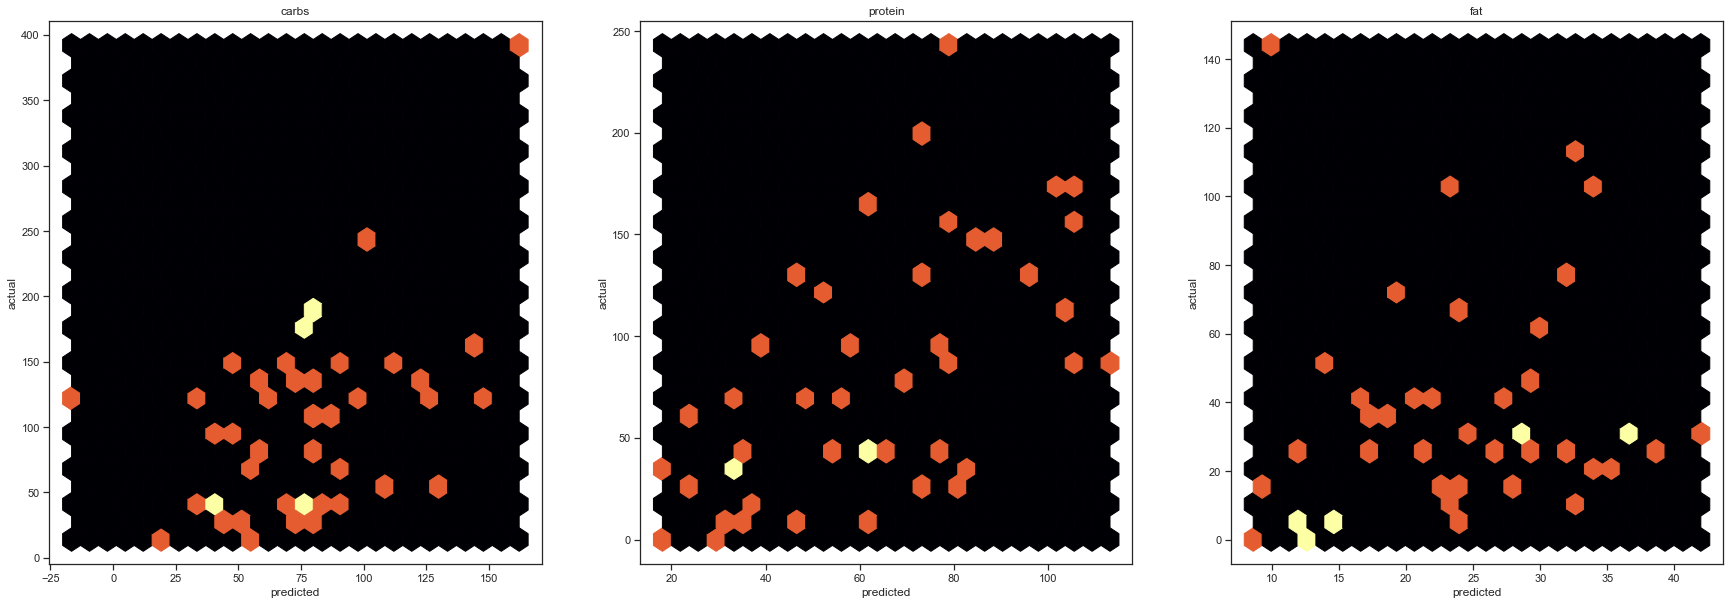

In [260]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.hexbin(Y_pred[:, 0], Y_test.values[:, 0], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('carbs')

plt.subplot(1, 3, 2)
plt.hexbin(Y_pred[:, 1], Y_test.values[:, 1], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('protein')

plt.subplot(1, 3, 3)
plt.hexbin(Y_pred[:, 2], Y_test.values[:, 2], cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('fat')

plt.show()

While in general the results seem to be in the "right" direction, the model unfortunately still seems to overfit the training data. Perhaps with more data this method will yield more accurate results.
Like in the previous linear model let's try to examine the nutritional amounts the model learned:

In [262]:
N.value[ingredients.index('flour'), :]

array([ 1.00000139e+00, -1.48829516e-07, -6.09741806e-07])

This is correct - 1g of flour has 1g carbs, nice!

In [265]:
D.value[ingredients.index('flour'), measurements.index('cup')]

169.57131021759693

That's also not very far - 1 cup flour has about 120 grams of flour.

In [269]:
N.value[ingredients.index('beef')] * 100

array([ 0.48898899, 27.38389457,  6.95595183])

This also seems to be really close - 100 grams of beef have 26.6g of protein, 7.7g of fat.

So while the test error for this method was pretty large, it seems to yield quite accurate results for many ingredients, which is very impressive. It's even able to learn a variable that we didn't explicitly have - amount of grams of the ingredient per measurement unit. I think that mainly for the very common ingredients the variables are relatively accurate.

## 9. Conclusions


Several directions were attempted at prediction: 
* Unregularized non-negative least squares regression
* Several deep learning models, involving both dense networks and networks for sequence (text) processing
* More advanced two-step optimization technique  


Unfortunately none of the models are good enough for use in production, but I think most of them show very promising directions, so I think that with some more data the problem should certainly be solvable. In fact I was surprised at some of the results considering that the problem is highly under-determined. Even considering only the preprocessed ingredients linear problem, we see that there are more than 180 distinct ingredients - more than all of the recipes we have (and certainly much more than the training set size). Therefore I really believe that the amount of data required to get production-level models shouldn't be that large.  

### Possible future directions
Some next steps I would consider for improving the prediction results:
* Get more data: I would try to obtain some more recipe information with macro-nutrient information. Probably the most effective way to do this would be scraping data from recipe websites. This will probably improve the results on its own and also allow us to train more complex models without overfitting.
* Improve ingredient preprocessing: the ingredient preprocessing is far from perfect, and perhaps by using a better identification of ingredients and measurements, and merging similar ingredients, we can improve the reuslts of the linear models.
* Pre-train on unlabelled data: another thing we can try for the networks that learned word embeddings is to collect recipe data with no macro-nutrient information (which shouldn't be very hard to find) and pre-train a term embedding network on it (in the word2vec approach), and use those embeddings instead of learning new embeddings. This can give the networks a very good starting point in interpreting ingredients and measurement units. Apart from the word2vec approach we can try other unsupervised learning tasks that will perhaps enable the model to learn interesting patterns, such as for example pairing together the ingredients and instructions sections of different recipes and having the model distinguish between cases where the ingredients and instructions match and cases where they don't match.

## 10. Personal perspectives

First of all I would like to express gratitude at the opportunity of taking the workshop and doing the project. The workshop was interesting and enriching, and the work on the project was very fun and instructive.

As explained in the introduction, I believe that using data to improve our quality of life is an important and interesting (and ambitious) application of data science and machine learning techniques, and the science of nutrition specifically can benefit a lot from usage of data, allowing food-tracking and food-recommendation services at mass and cheaply.  
Such services require a very solid "understanding" of food that spans many aspects and large volumes of data, and this project was a stab at one of them. Altough the results weren't production level I'm quite happy with them, as they show promise even on a very small dataset.

Technically I enjoyed working on the project and leared a lot: there was some (basic) image processing, NLP, machine learning (learned how to use functional models in Keras), and even convex optimization (first time trying two-step optimization).

Thanks for reading so far (and again for the great opportunity),

Daniel